In [1]:
# Import relevant packages
import gurobipy as gp                 # Gurobi Python API
from gurobipy import GRB              # Gurobi constants (e.g., GRB.MAXIMIZE)

import pandas as pd                   # DataFrames
import matplotlib.pyplot as plt       # Plotting
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import numpy as np                    # Numerical operations (similar to Julia base)

import warnings
warnings.filterwarnings("ignore", message=".*All values for SymLogScale are below linthresh.*")

In [2]:
# Import auxiliary functions
from functions_data import *
from functions_model import *
from functions_plots import *
from functions_policy import *

In [3]:
from main import main

In [4]:
def plot_market_price_summary(results, season="Winter", player_counts=[0,1,2,4,6,8], selected_hours=[8, 12, 18], save=False):
    avg_prices, peak_prices, weighted_avg_prices = [], [], []
    hour_prices = {h: [] for h in selected_hours}

    for n in player_counts:
        output = results[season][n]
        price = output[0][3]

        avg_prices.append(np.mean(price))
        peak_prices.append(np.max(price))
        for h in selected_hours:
            hour_prices[h].append(price[h])
    
        if n != 0:
            discharge = [sum(output[p][1][t] for p in output) for t in range(len(price))]
            weighted_avg_prices.append(np.average(price, weights=discharge))
    
    if player_counts[0] == 0:
        player_counts_without_zero = player_counts[1:]
    else:
        player_counts_without_zero = player_counts

    plt.figure(figsize=(10, 6))
    plt.plot(player_counts, avg_prices, 'o-', label="Average Price")
    plt.plot(player_counts, peak_prices, 'o-', label="Peak Price")
    plt.plot(player_counts_without_zero, weighted_avg_prices, 'o-', label="Weighted Avg Price")

    for i in range(len(player_counts)):
        plt.text(player_counts[i], avg_prices[i] * 1.1, f"{avg_prices[i]:.2f}", ha='center', va='bottom', fontsize=9)
        plt.text(player_counts[i], peak_prices[i] * 1.03, f"{peak_prices[i]:.2f}", ha='center', va='bottom', fontsize=9)
        
    for i in range(len(player_counts_without_zero)):        
        plt.text(player_counts_without_zero[i], weighted_avg_prices[i] * 1.05, f"{weighted_avg_prices[i]:.2f}", ha='center', va='bottom', fontsize=9)

    for h in selected_hours:
        plt.plot(player_counts, hour_prices[h], 'o--', label=f"Price at {h}:00")

    plt.xlabel("Number of Players")
    plt.ylabel("Market Price [€/MWh]")
    plt.ylim(top=max(peak_prices)*1.1)
    plt.title(f"Market Price Summary - {season}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    if save:
        plt.savefig(f"figs_competition/market_price_summary_{season}.pdf")
        results_df = pd.DataFrame({
            "average_prices": avg_prices,
            "weighted_average_prices": np.insert(weighted_avg_prices, 0, 0),
            "peak_prices": peak_prices
        })
        results_df.to_csv(f"csv_competition\{season}-market_summary.csv")
    plt.show()


In [5]:
def plot_stacked_welfare(results, season="Winter", player_counts=[0,1,2,4,6,8], save=False):
    cs_list, ps_list = [], []
    for n in player_counts:
        output = results[season][n]
        cs_list.append(sum(output[0][7])/1e3)
        ps_list.append(sum(output[0][8])/1e3)

    ind = np.arange(start=1, stop=1+len(player_counts))
    width = 0.6

    plt.figure(figsize=(8, 5))
    plt.bar(ind, cs_list, width, label='Consumer Surplus', color='skyblue')
    plt.bar(ind, ps_list, width, bottom=cs_list, label='Producer Surplus', color='orange')
    plt.xticks(ind, player_counts)
    plt.xlabel("Number of Players")
    plt.ylabel("Monetary Value [thousands €]")
    plt.title(f"Evolution of Market Welfare under Competition - {season}")
    plt.legend()
    plt.tight_layout()
    if save:
        plt.savefig(f"figs_competition/stacked_surplus_{season}.pdf")
        results_df = pd.DataFrame({
            "consumer_surplus": cs_list,
            "producer_surplus": ps_list
        })
        results_df.to_csv(f"csv_competition\{season}-welfare_metrics.csv")
    plt.show()


In [6]:
def plot_curtail_unmet_groupedbars(results, season="Winter", player_counts=[0,1,2,4,6,8], save=False):
    curtailed, unmet = [], []
    for n in player_counts:
        output = results[season][n]
        curtailed.append(np.mean(output[0][10]))
        unmet.append(np.mean(output[0][9]))

    x = np.arange(start=1, stop=1+len(player_counts))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 5))
    bar1 = ax.bar(x - width/2, curtailed, width, label='Curtailed Energy', color='salmon')
    bar2 = ax.bar(x + width/2, unmet, width, label='Unmet Demand', color='steelblue')

    ax.set_xlabel("Number of Players")
    ax.set_ylabel("Energy [MWh]")
    ax.set_title(f"Curtailed and Unmet Energy - {season}")
    ax.set_xticks(x)
    ax.set_xticklabels(player_counts)
    ax.legend(loc='lower left')
    ax.grid(axis='y', linestyle='--', alpha=0.5)

    # Add text annotations
    for bars in [bar1, bar2]:
        for bar in bars:
            height = bar.get_height()
            offset = max(0.01 * max(curtailed + unmet), 0.05)  # adaptive offset
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + offset,
                f"{height:.1f}",
                ha='center', va='bottom',
                fontsize=9
            )
    ax.set_ylim(top=max(curtailed)*1.05, bottom=min(unmet)*0.8)

    plt.tight_layout()
    if save:
        plt.savefig(f"figs_competition/curtailment_unmet_grouped_{season}.pdf")
    plt.show()

In [7]:
def plot_curtailment_and_unmet_subplots(results, season="Winter", player_counts=[0,1,2,4,6,8], mode="Total", save=False):
    curtailed, unmet = [], []
    curtailed_total, curtailed_average, unmet_total, unmet_average = [], [], [], []
    for n in player_counts:
        output = results[season][n]

        curtailed_total.append(sum(output[0][10]))
        unmet_total.append(sum(output[0][9]))
        curtailed_average.append(np.mean(output[0][10]))
        unmet_average.append(np.mean(output[0][9]))

    if mode == "Total":
        curtailed = curtailed_total
        unmet = unmet_total
    else:
        curtailed = curtailed_average
        unmet = unmet_average

    x = np.arange(len(player_counts))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

    # --- Curtailed Energy ---
    bars1 = ax1.bar(x, curtailed, color='salmon')
    ax1.set_title(f"{mode} Curtailed Energy")
    ax1.set_xlabel("Number of Players")
    ax1.set_ylabel("Energy [MWh]")
    ax1.set_ylim(top=max(curtailed)*1.05, bottom=min(curtailed)*0.75)
    ax1.set_xticks(x)
    ax1.set_xticklabels(player_counts)
    ax1.grid(axis='y', linestyle='--', alpha=0.5)
    for bar in bars1:
        height = bar.get_height()
        offset = max(0.01 * max(curtailed), 0.05)
        ax1.text(bar.get_x() + bar.get_width()/2, height + offset,
                 f"{height:.1f}", ha='center', va='bottom', fontsize=9)

    # --- Unmet Demand ---
    bars2 = ax2.bar(x, unmet, color='steelblue')
    ax2.set_title(f"{mode} Unmet Demand")
    ax2.set_xlabel("Number of Players")
    ax2.set_xticks(x)
    ax2.set_xticklabels(player_counts)
    ax2.set_ylim(top=max(unmet)*1.1, bottom=min(unmet)*0.5)
    ax2.grid(axis='y', linestyle='--', alpha=0.5)
    for bar in bars2:
        height = bar.get_height()
        offset = max(0.01 * max(unmet), 0.05)
        ax2.text(bar.get_x() + bar.get_width()/2, height + offset,
                 f"{height:.1f}", ha='center', va='bottom', fontsize=9)

    fig.suptitle(f"Evolution of Market Flexibility Metrics under Competition - {season}", fontsize=14)
    # plt.tight_layout()
    
    if save:
        plt.savefig(f"figs_competition/curtailment_unmet_{mode}_{season}.pdf")
        results_df = pd.DataFrame({
            "curtailement-average": curtailed_average,
            "unmet_demand-average": unmet_average,
            "curtailement-total": curtailed_total,
            "unmet_demand-total": unmet_total           
        })
        results_df.to_csv(f"csv_competition\{season}-flexibility_metrics.csv")
    plt.show()


In [8]:
def plot_revenue_per_mwh(results, season="Winter", player_counts=[1, 2, 4, 6, 8], save=False):
    rev_per_mwh = []
    weighted_avg_rev_per_mwh = []
    rev_per_capacity = []

    capacity = {
        "Winter": 6330.0,
        "Summer": 11520.0,
        "LowLoad": 9140.0
    }

    for n in player_counts:
        output = results[season][n]

        total_rev, total_dis = 0, 0
        for p in output:
            revenue = sum(output[p][4])
            discharged = sum(output[p][1])
            total_rev += revenue
            total_dis += discharged
        avg = total_rev / total_dis if total_dis > 0 else 0
        rev_per_mwh.append(avg)
        rev_per_capacity.append(total_rev / capacity[season])

        revenue, discharged = [], []
        for t in range(24):
            revenue.append(sum(output[p][4][t] for p in output))
            discharged.append(sum(output[p][1][t] for p in output))
        weighted_avg_rev_per_mwh.append(np.average(revenue, weights=discharged))


    plt.figure(figsize=(8, 5))
    plt.plot(player_counts, rev_per_mwh, 'o-', color='darkgreen', label='Revenue per MWh')
    plt.plot(player_counts, rev_per_capacity, 'o-', label='Revenue per Capacity')
    # plt.plot(player_counts, weighted_avg_rev_per_mwh, 'o-', label='Weighted Average Revenue per MWh')

    for i, val in enumerate(rev_per_mwh):
        plt.text(player_counts[i], val*1.03, f"{val:.1f}", ha='center', va='bottom', fontsize=9)
    for i, val in enumerate(rev_per_capacity):
        plt.text(player_counts[i], val*1.1, f"{val:.2f}", ha='center', va='bottom', fontsize=9)
    # for i, val in enumerate(weighted_avg_rev_per_mwh):
    #     plt.text(player_counts[i], val*1.01, f"{val:.1f}", ha='center', va='bottom', fontsize=9)
    
    bottom, top = plt.ylim()
    plt.ylim(top=1.15*top)

    plt.xlabel("Number of Players")
    plt.ylabel("Revenue [€/MWh]")
    plt.title(f"Average Revenue Summary - {season}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    if save:
        plt.savefig(f"figs_competition/revenue_summary_{season}.pdf")
    plt.show()


In [9]:
def plot_total_discharge(results, season="Winter", player_counts=[1, 2, 4, 6, 8], save=False):
    total_discharge = []

    for n in player_counts:
        output = results[season][n]
        total_dis = sum(sum(output[p][1]) for p in output)
        total_discharge.append(total_dis)

    plt.figure(figsize=(8, 5))
    plt.plot(player_counts, total_discharge, 'o-', color='slateblue')
    plt.xlabel("Number of Players")
    plt.ylabel("Total Energy Discharged [MWh]")
    plt.title(f"Total Discharge - {season}")
    plt.grid(True)

    # Dynamic y-axis and text settings
    sorted_vals = sorted(total_discharge)
    if len(sorted_vals) >= 2 and abs(sorted_vals[-1] - sorted_vals[0]) < 1:
        # Minor differences in values → Using linear y-scale
        plt.ylim(bottom=sorted_vals[0]-1, top=sorted_vals[-1]+1)
        for i, val in enumerate(total_discharge):
            plt.text(player_counts[i], val+0.1, f"{val:.1f}", ha='center', va='bottom', fontsize=9)
    # elif len(sorted_vals) >= 2 and sorted_vals[-1] > 1.5 * sorted_vals[-2]:
    #     # Outlier value → Using symlog y-scale with linthresh = {linthresh:.1f}
    #     linthresh = sorted_vals[-2] * 1.2  # Small buffer above 2nd-largest
    #     plt.yscale('symlog', linthresh=linthresh)
    else:
        # Usual case → Using linear y-scale
        plt.ylim(top=sorted_vals[-1]*1.05)
        for i, val in enumerate(total_discharge):
            plt.text(player_counts[i], val * 1.02, f"{val:.1f}", ha='center', va='bottom', fontsize=9)

    
    plt.tight_layout()

    if save:
        plt.savefig(f"figs_competition/total_discharge_{season}.pdf")
        results_df = pd.DataFrame({
            "total_discharge": total_discharge        
        })
        results_df.to_csv(f"csv_competition\{season}-storage_discharge.csv")
    plt.show()


In [10]:
# --- Define scenario space ---
seasons = ['Winter', 'Summer', 'LowLoad']
player_counts = [1, 2, 4, 6, 8]

storage_capacity = None


# --- Store results ---
results = {}

# Impact of competition

**From none to 8 storage players**

Running Winter - 1 players
  Player   OC   Eta   E_max   Q_max  \
0      A  0.5  0.85  6330.0  3168.0   

                                             Q_steps  
0  [0.0, 316.8, 633.6, 950.4, 1267.2, 1584.0, 190...  
Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-28


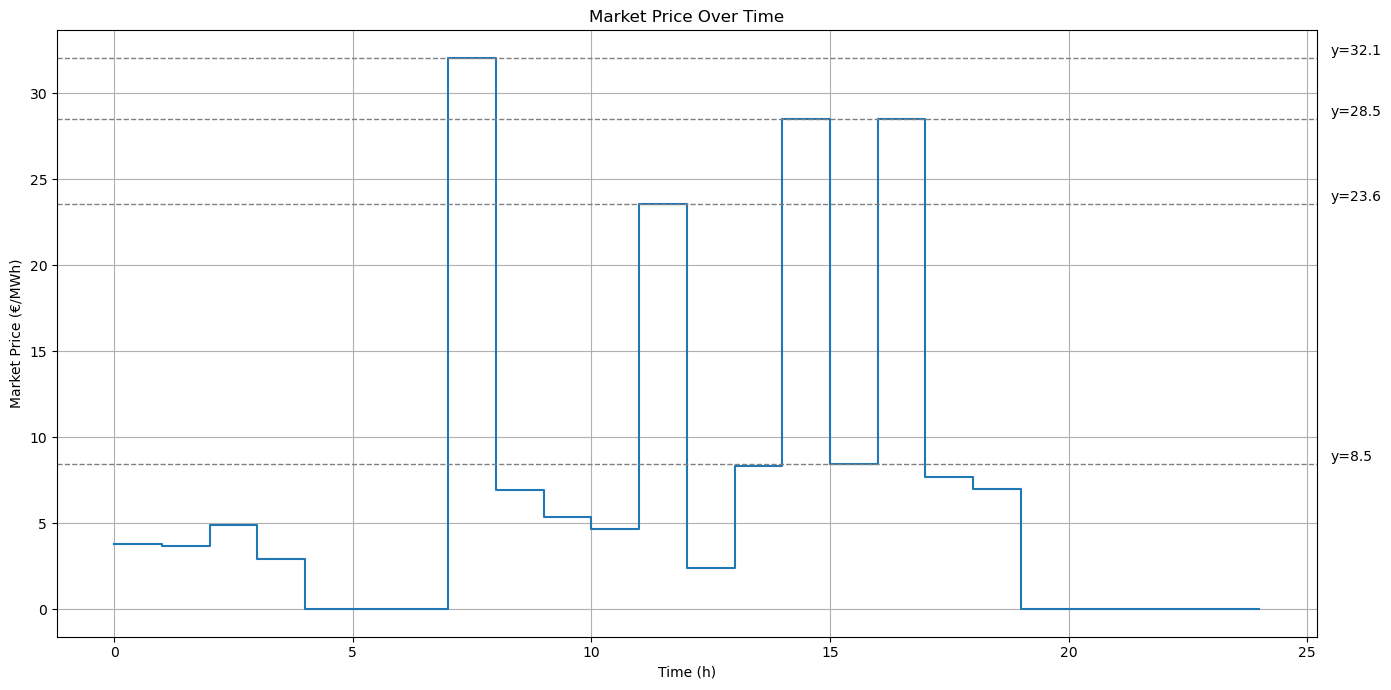

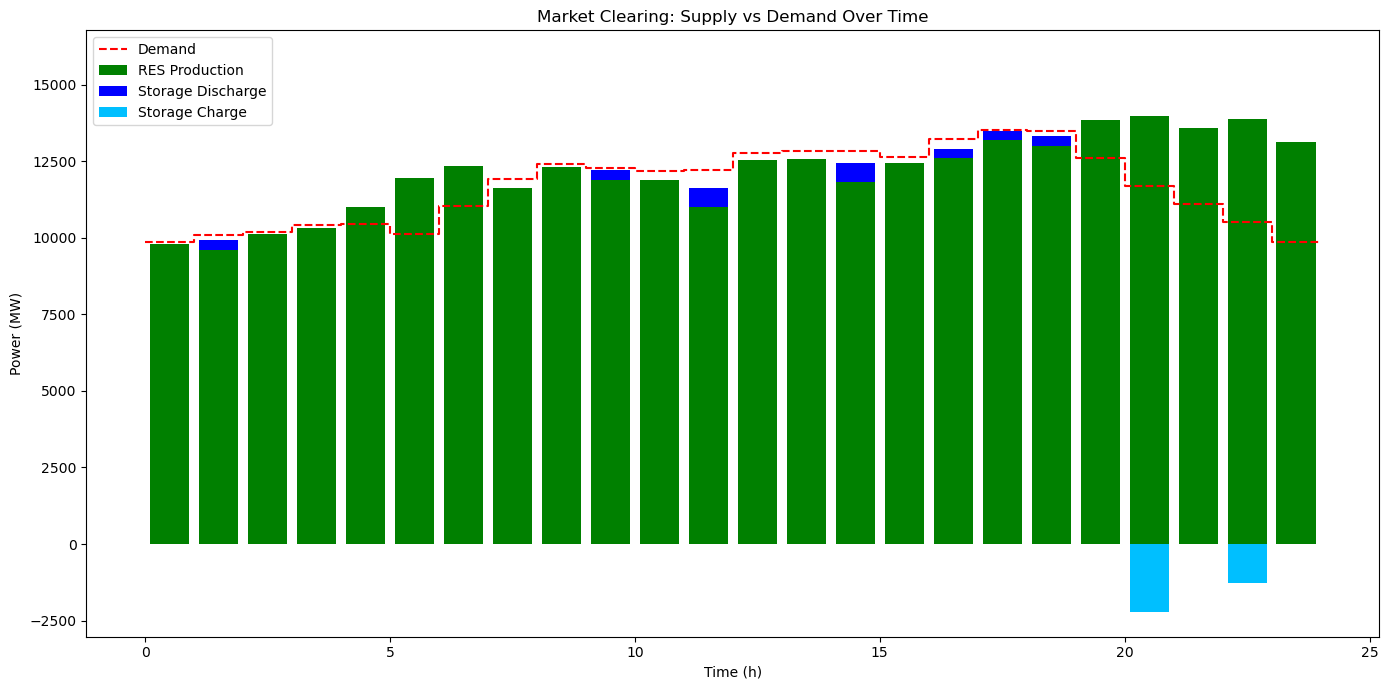

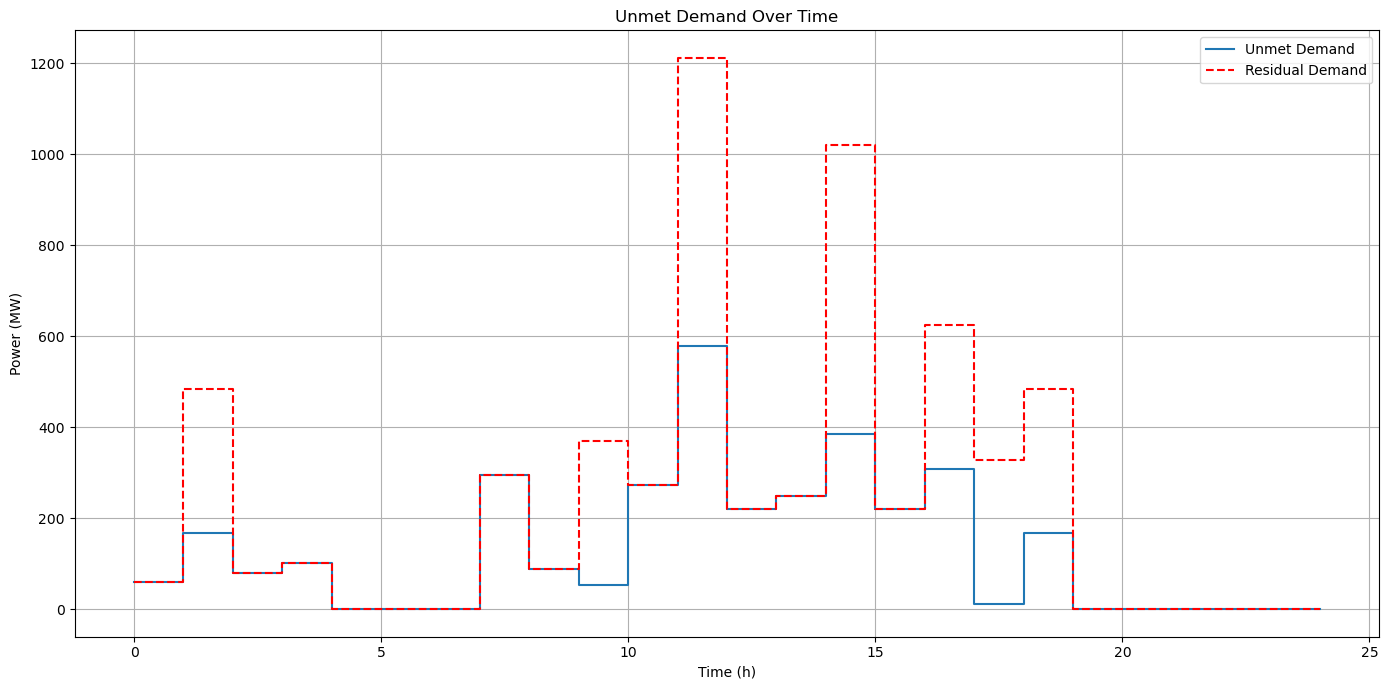

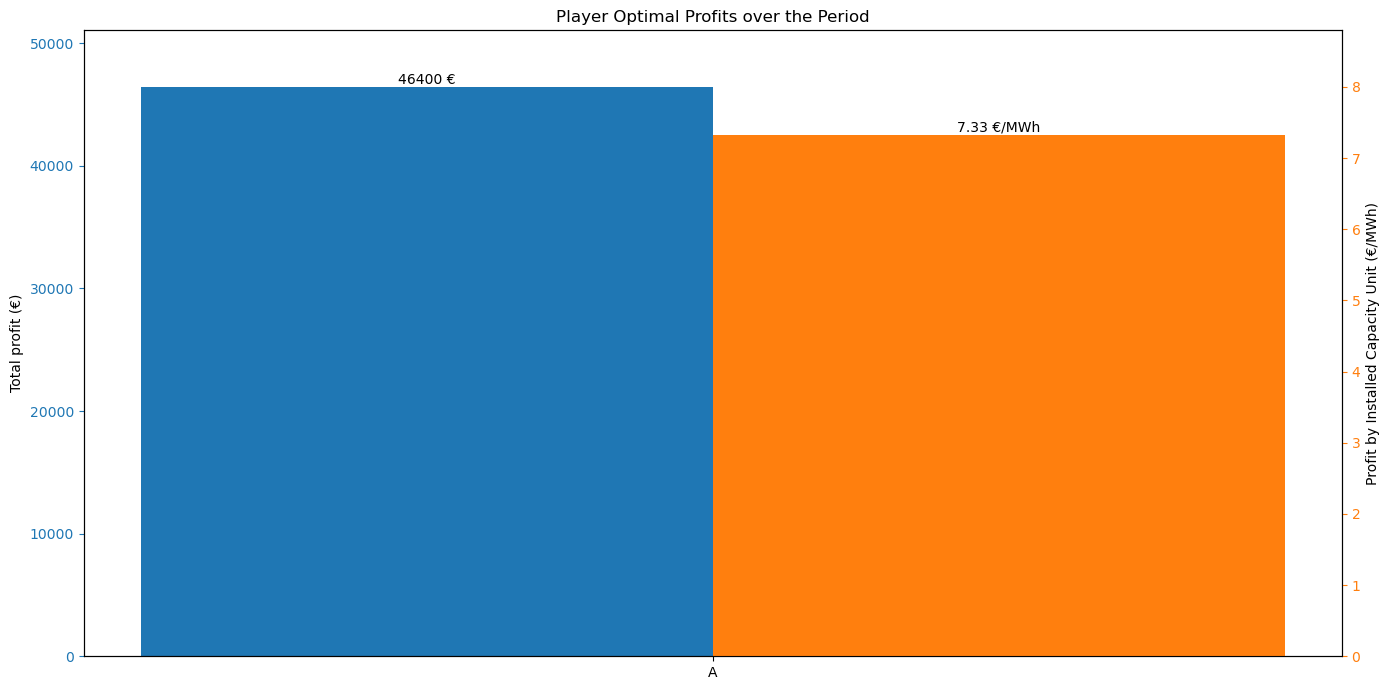

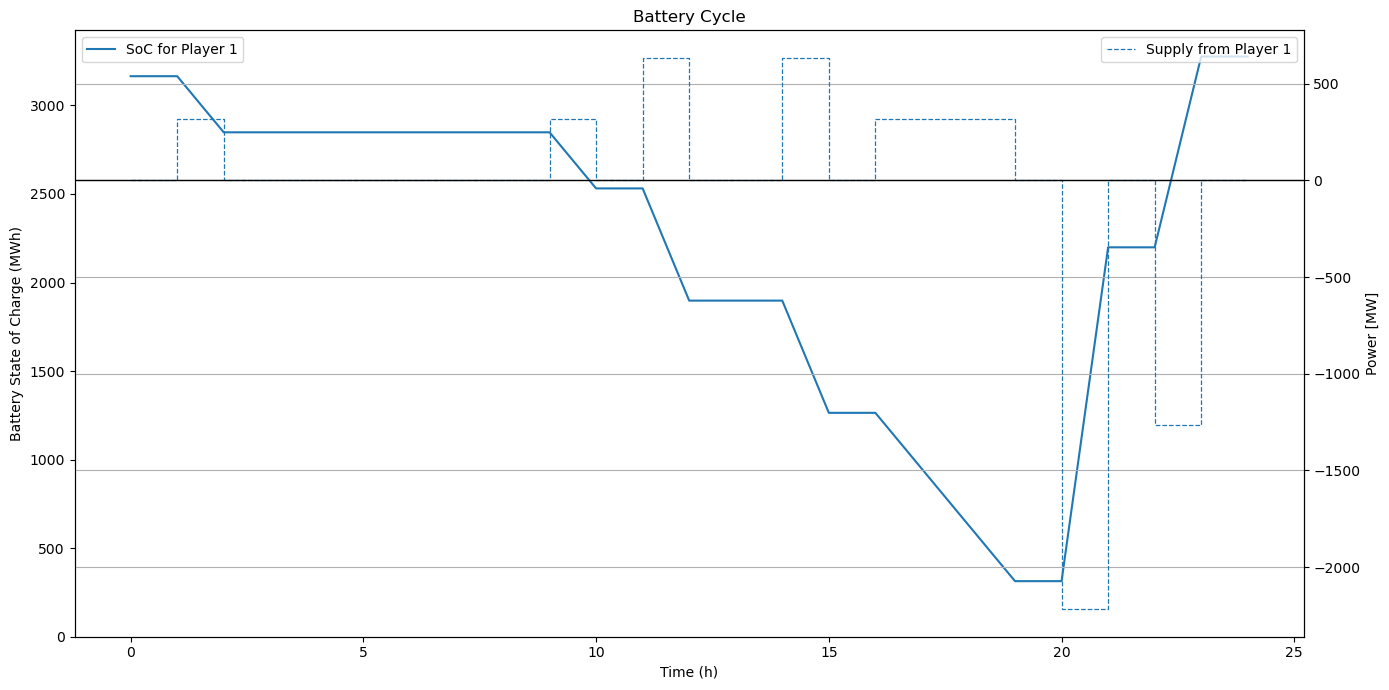

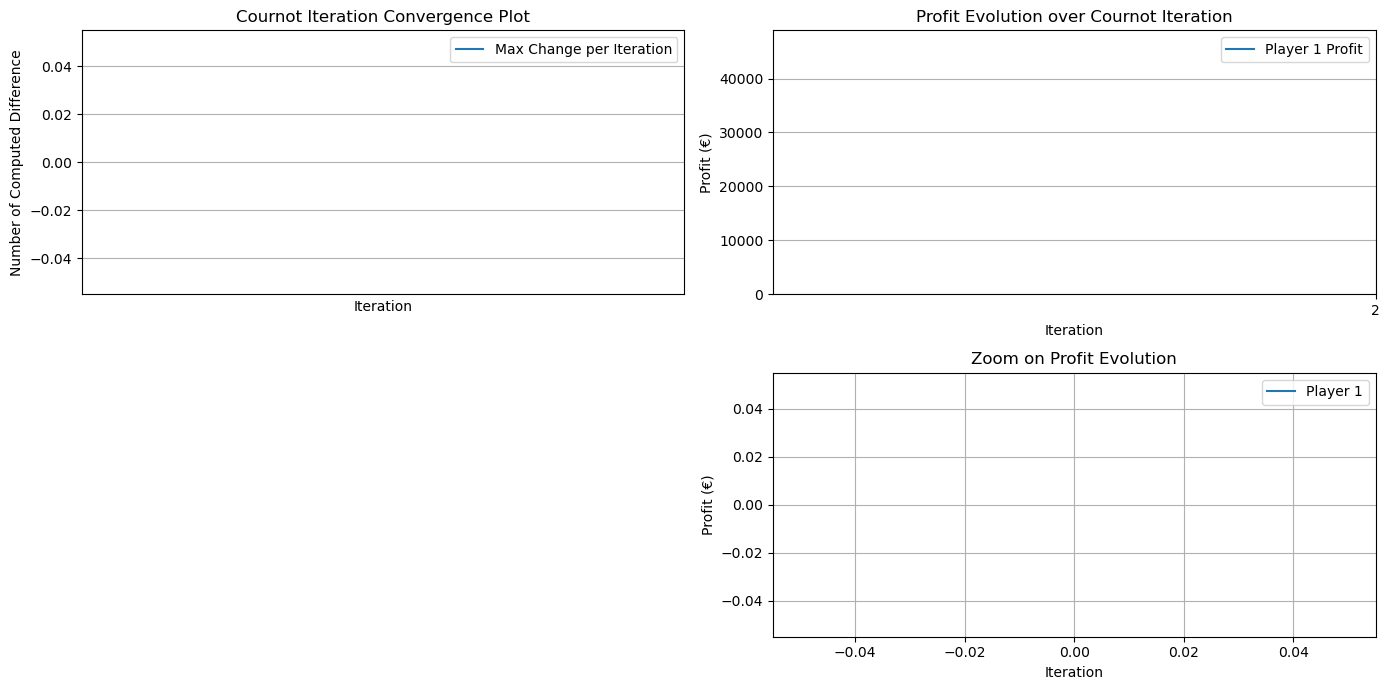

Running Winter - 2 players
  Player   OC   Eta   E_max   Q_max  \
0      A  0.5  0.85  2110.0  1056.0   
1      B  0.5  0.85  4220.0  2112.0   

                                             Q_steps  
0  [0.0, 105.6, 211.2, 316.8, 422.4, 528.0, 633.6...  
1  [0.0, 211.2, 422.4, 633.6, 844.8, 1056.0, 1267...  
Optimization was successful. It converged in 4 iterations.


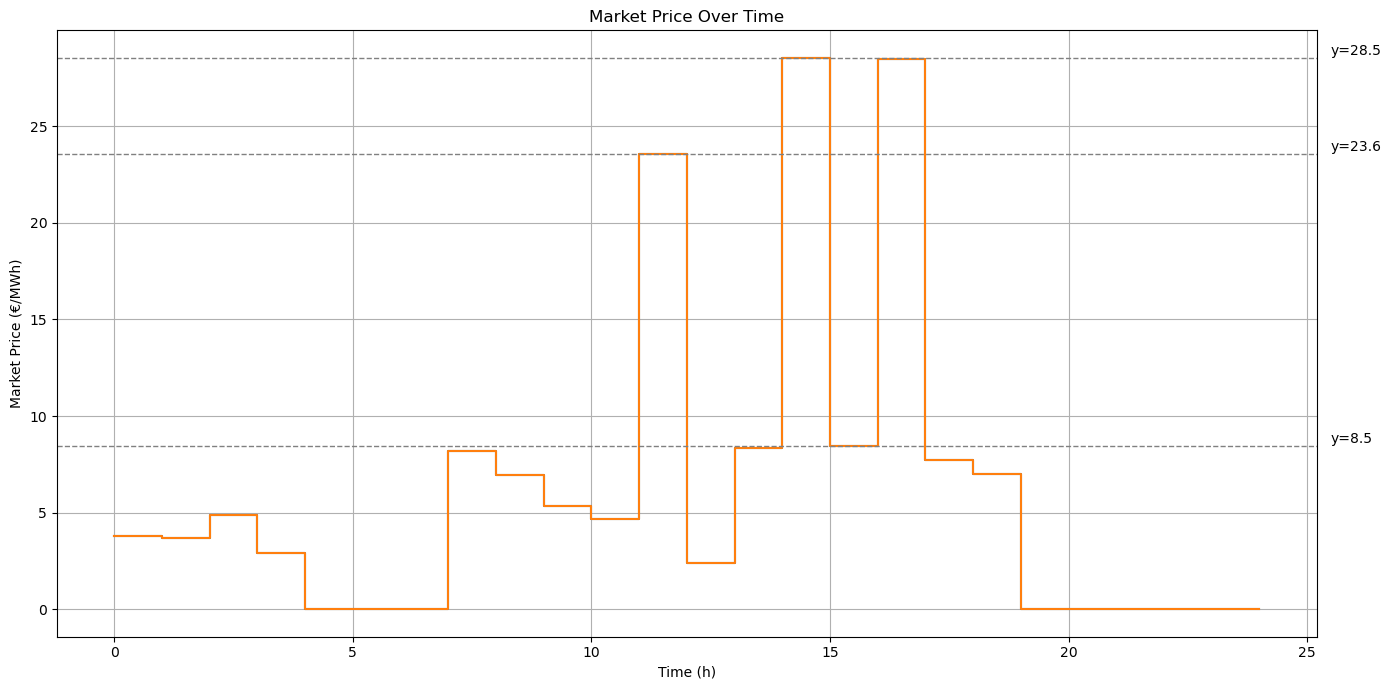

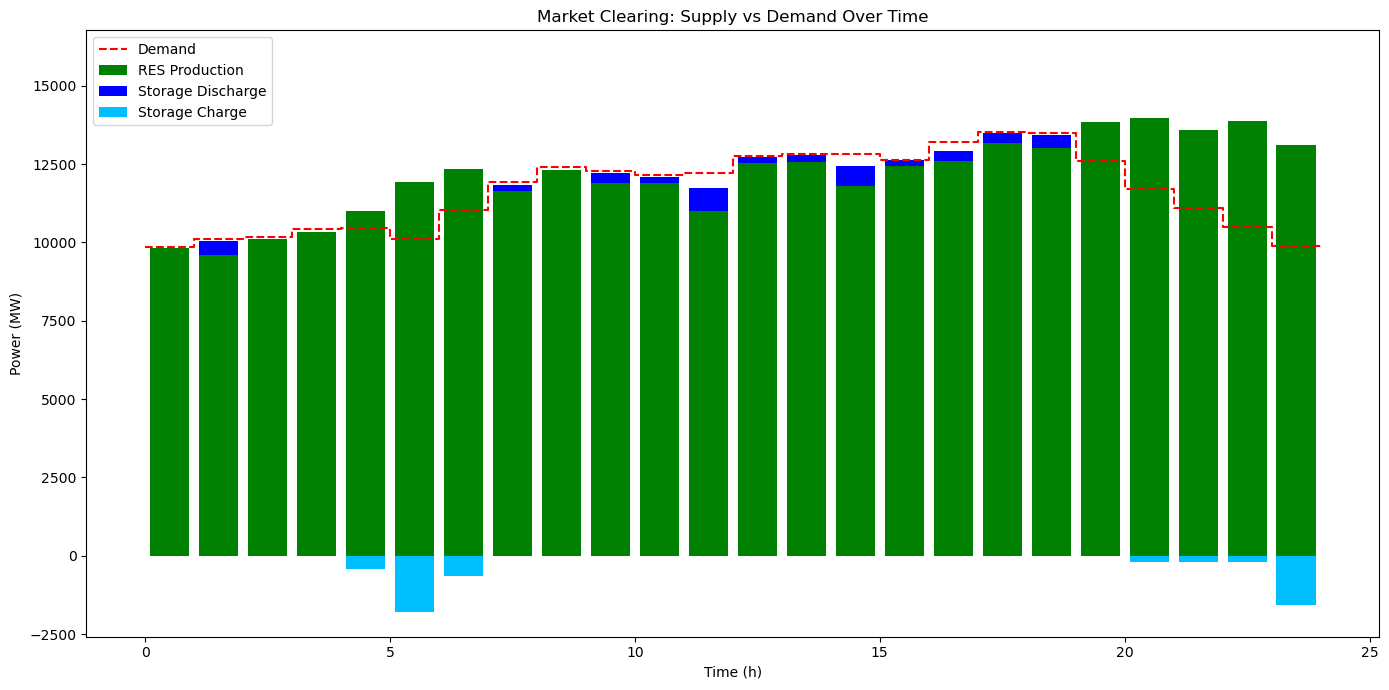

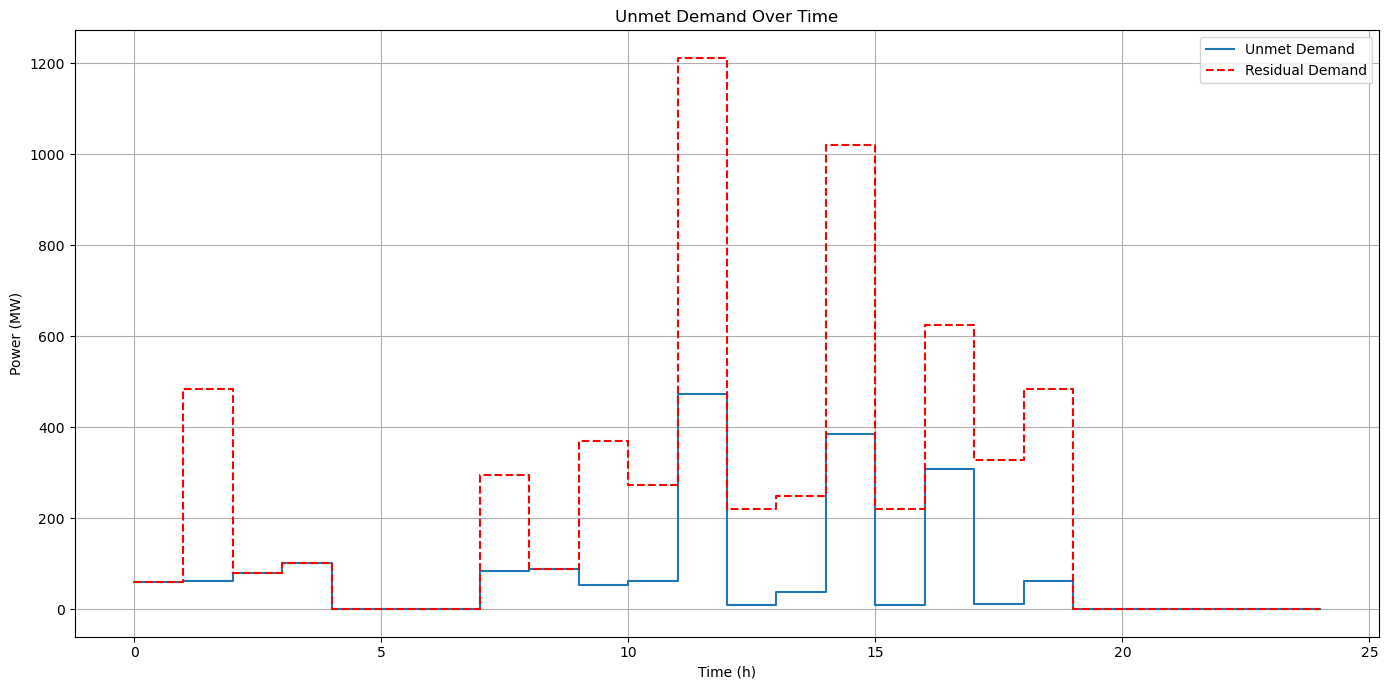

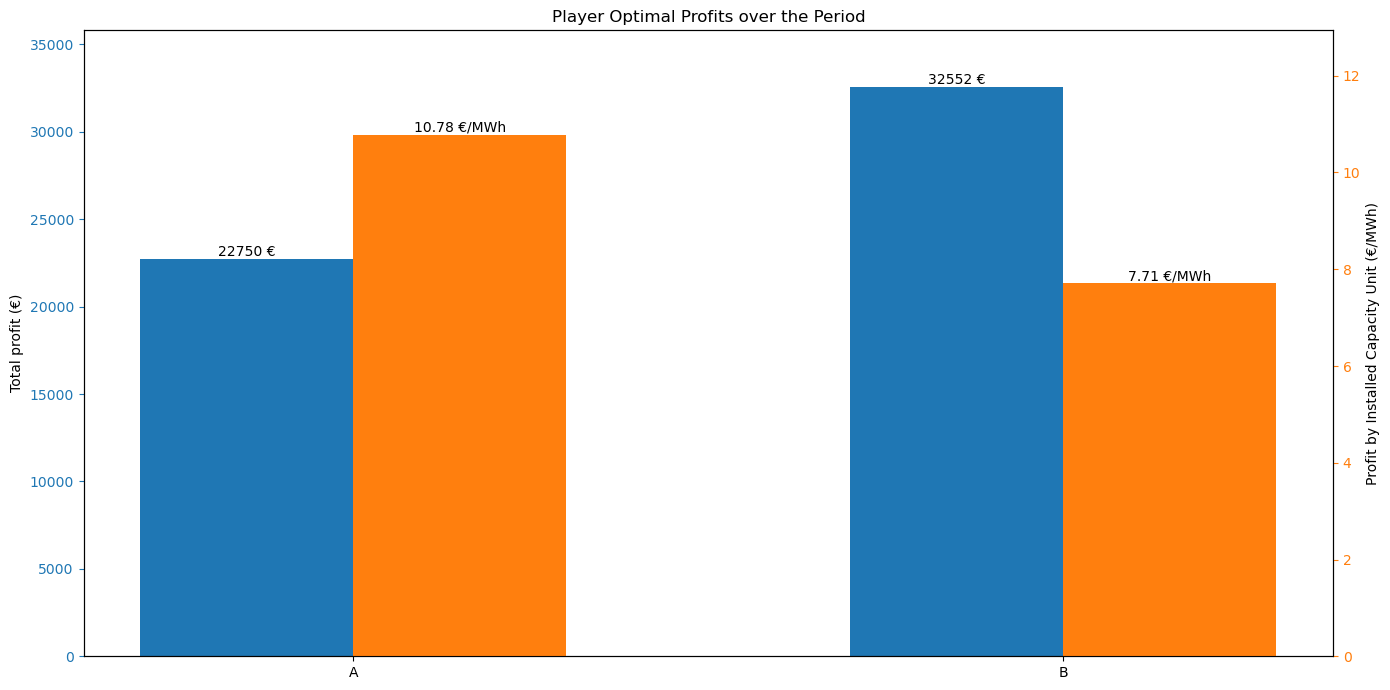

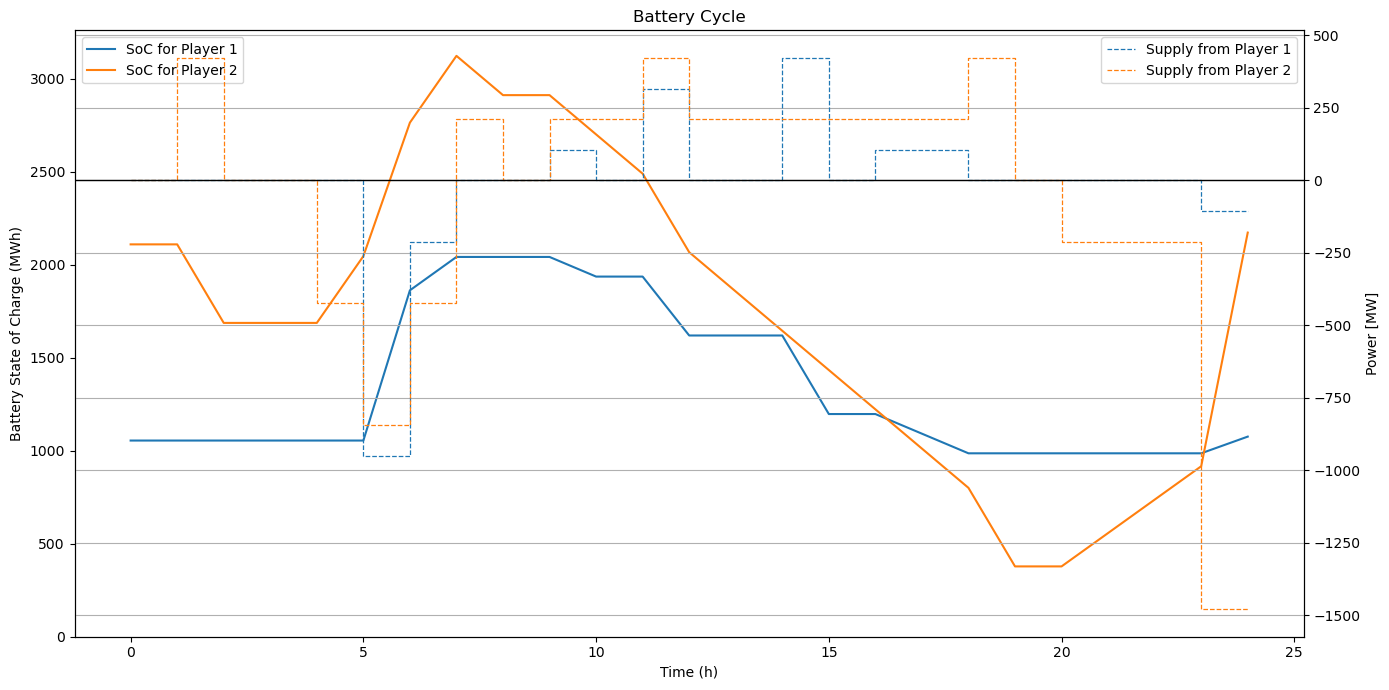

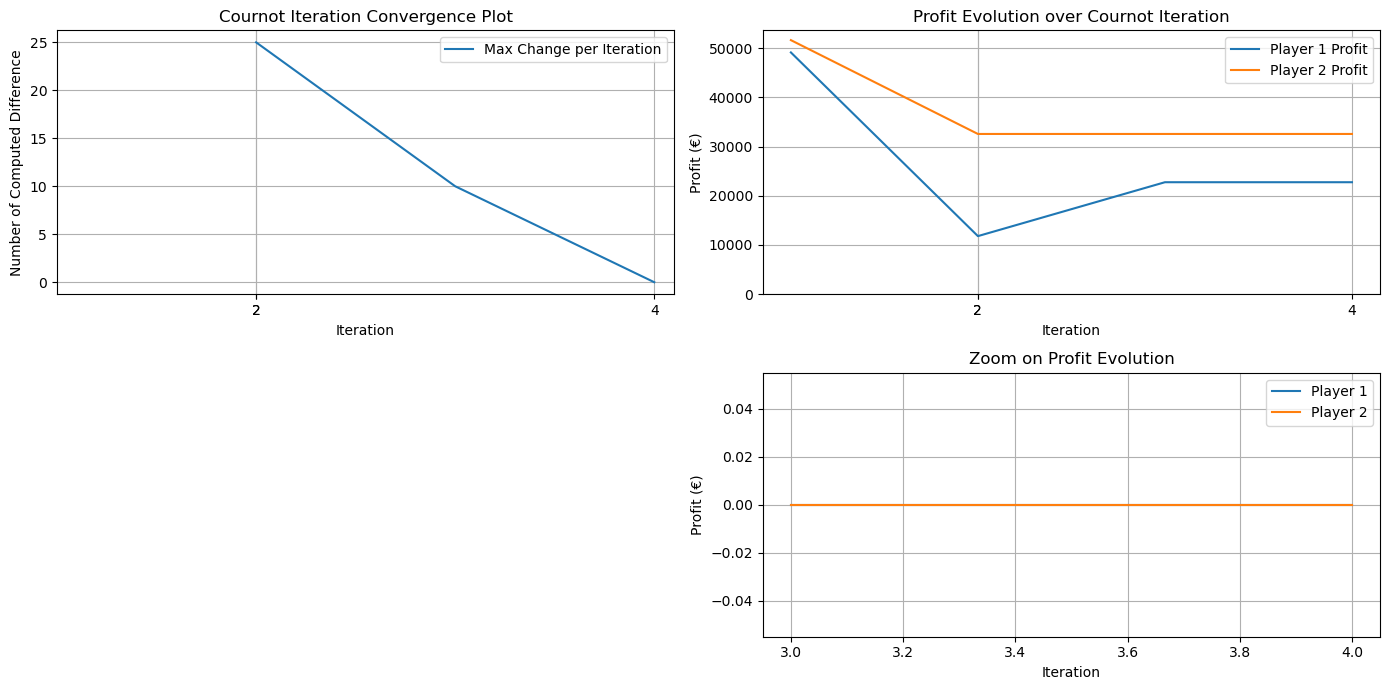

Running Winter - 4 players
  Player   OC   Eta   E_max   Q_max  \
0      A  0.5  0.85   630.0   316.0   
1      B  0.5  0.85  1260.0   633.0   
2      C  0.5  0.85  1900.0   950.0   
3      D  0.5  0.85  2530.0  1267.0   

                                             Q_steps  
0  [0.0, 31.6, 63.2, 94.8, 126.4, 158.0, 189.6, 2...  
1  [0.0, 63.3, 126.6, 189.9, 253.2, 316.5, 379.8,...  
2  [0.0, 95.0, 190.0, 285.0, 380.0, 475.0, 570.0,...  
3  [0.0, 126.7, 253.4, 380.1, 506.8, 633.5, 760.2...  
Optimization was successful. It converged in 8 iterations.


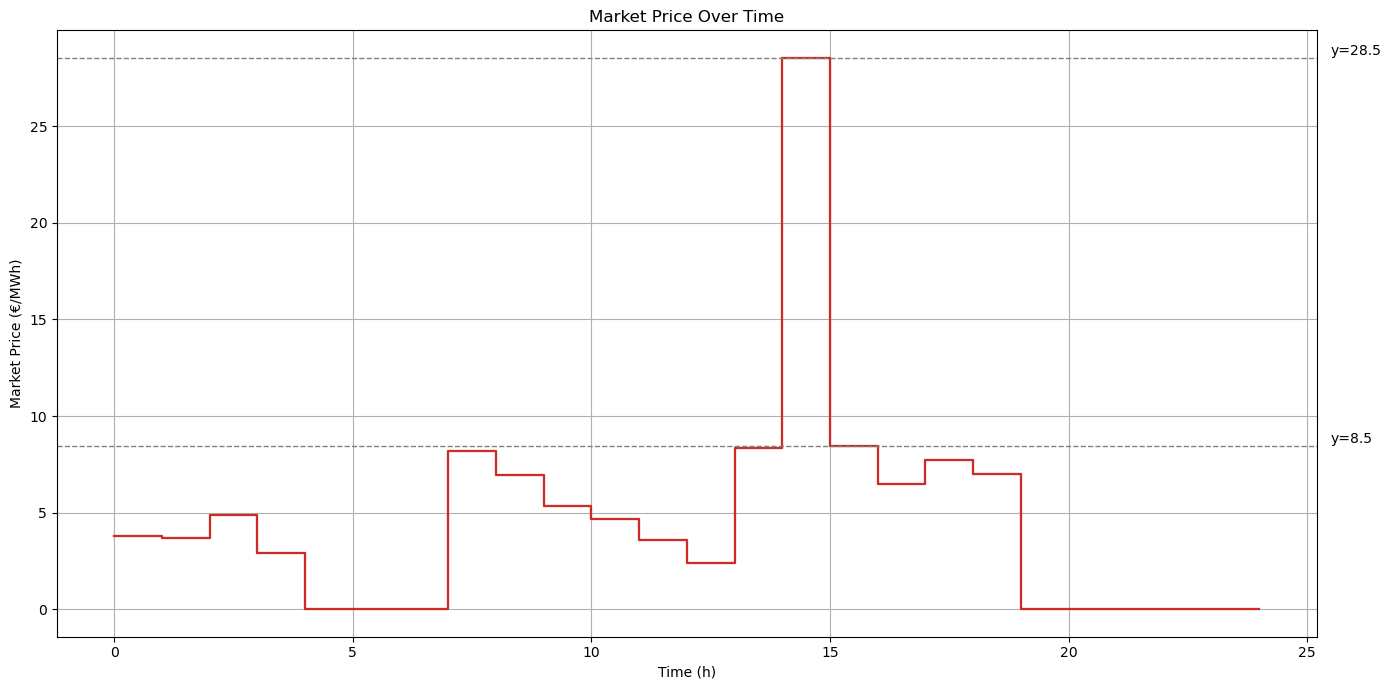

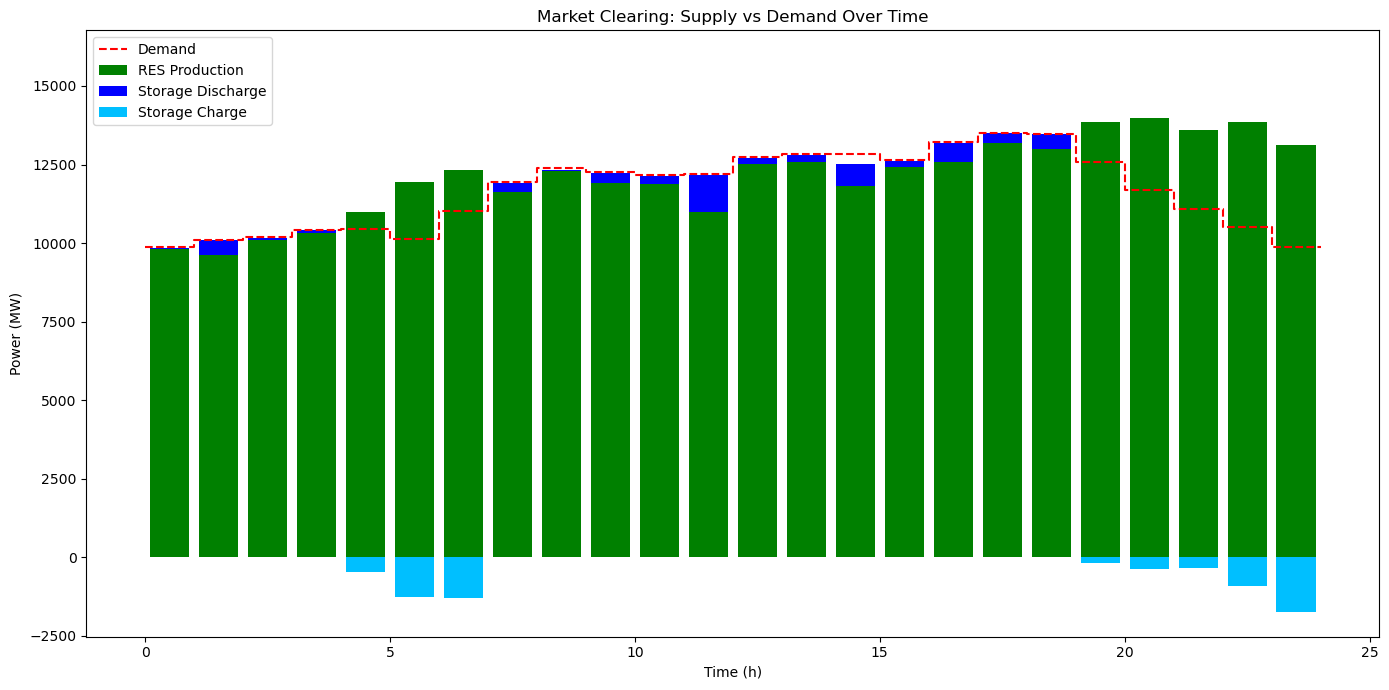

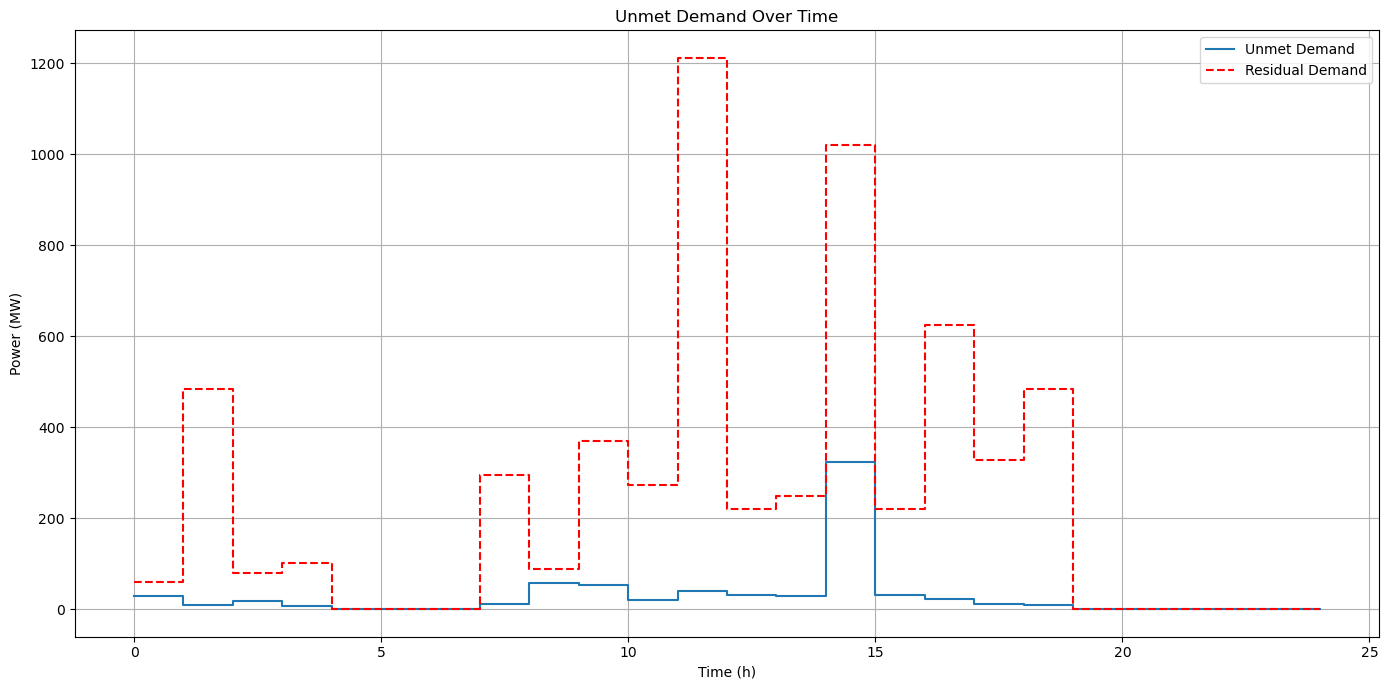

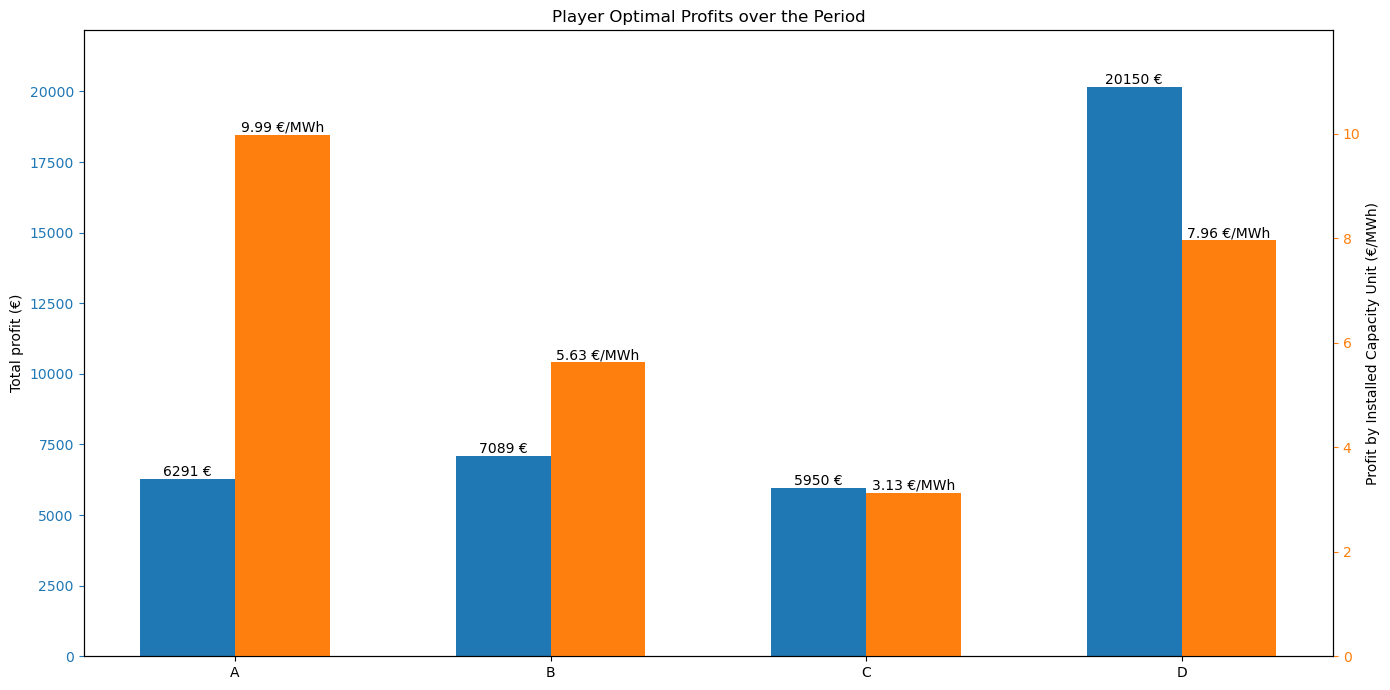

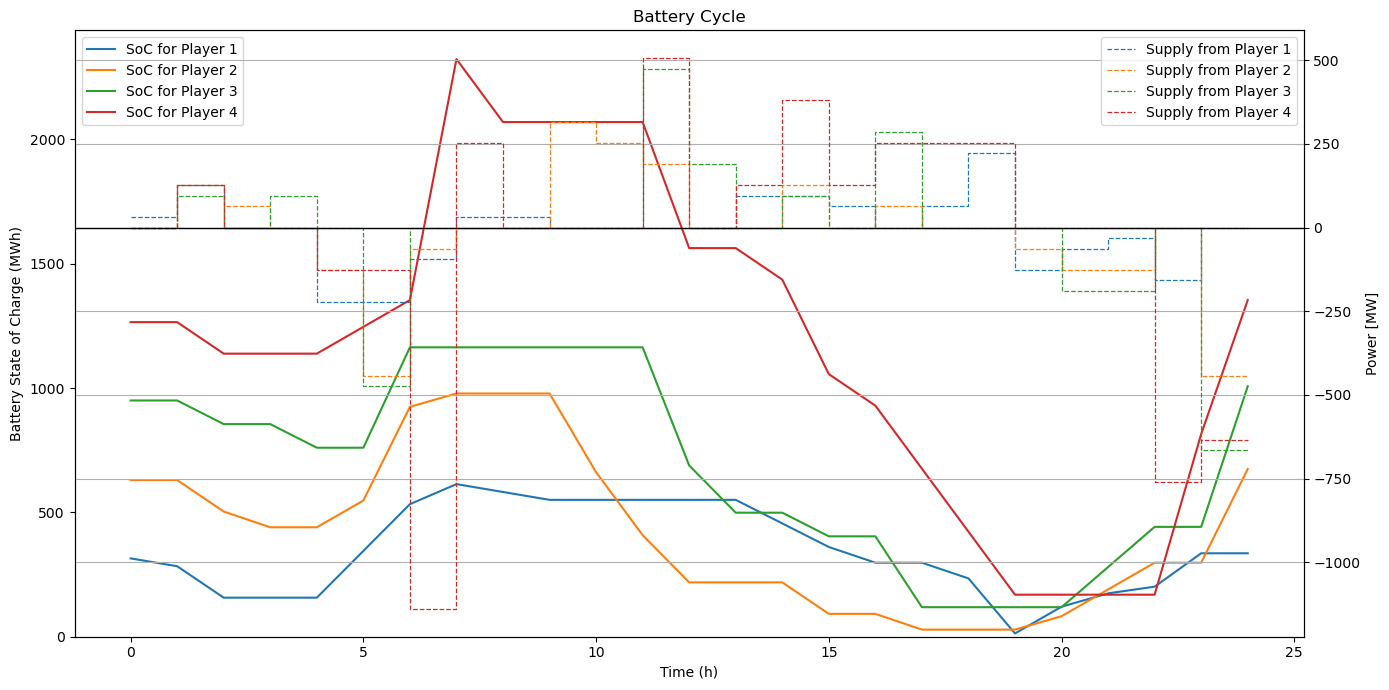

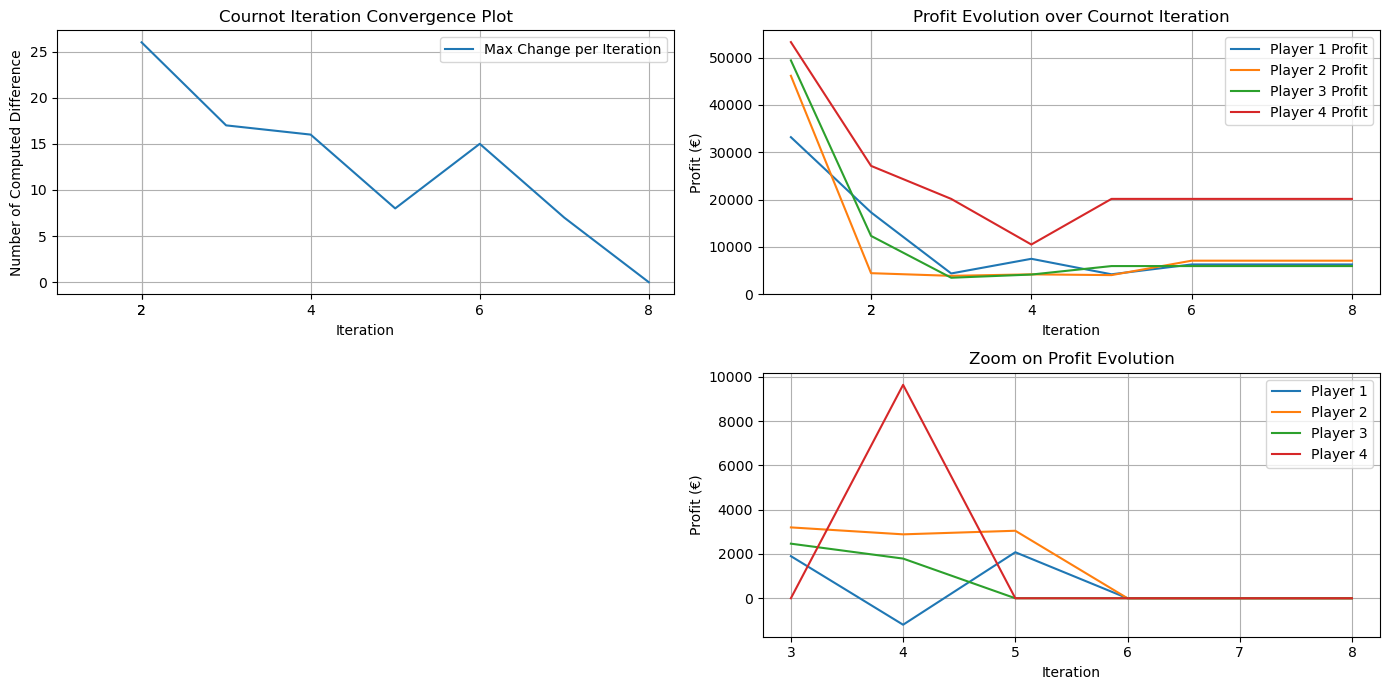

Running Winter - 6 players
  Player   OC   Eta   E_max   Q_max  \
0      A  0.5  0.85   310.0   158.0   
1      B  0.5  0.85   630.0   316.0   
2      C  0.5  0.85   630.0   316.0   
3      D  0.5  0.85   950.0   475.0   
4      E  0.5  0.85  1580.0   792.0   
5      F  0.5  0.85  2210.0  1108.0   

                                             Q_steps  
0  [0.0, 15.8, 31.6, 47.4, 63.2, 79.0, 94.8, 110....  
1  [0.0, 31.6, 63.2, 94.8, 126.4, 158.0, 189.6, 2...  
2  [0.0, 31.6, 63.2, 94.8, 126.4, 158.0, 189.6, 2...  
3  [0.0, 47.5, 95.0, 142.5, 190.0, 237.5, 285.0, ...  
4  [0.0, 79.2, 158.4, 237.6, 316.8, 396.0, 475.2,...  
5  [0.0, 110.8, 221.6, 332.4, 443.2, 554.0, 664.8...  
Optimization was successful. It converged in 10 iterations.


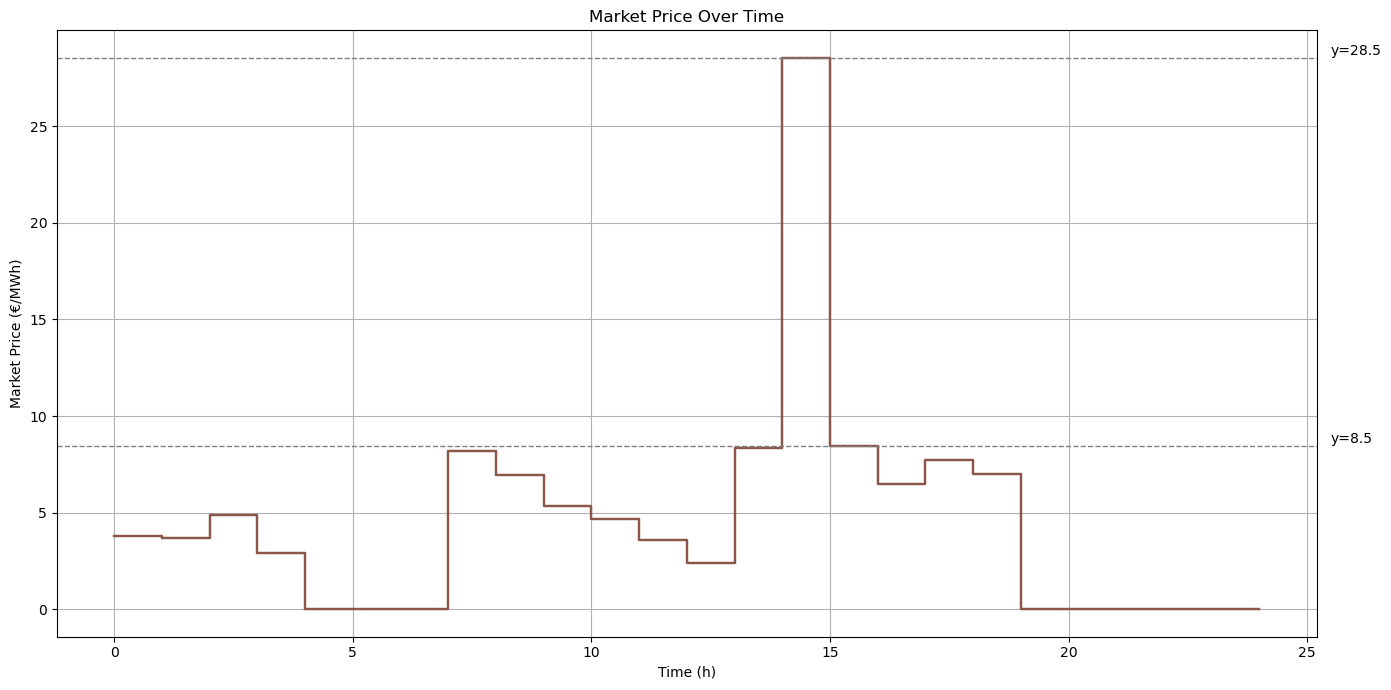

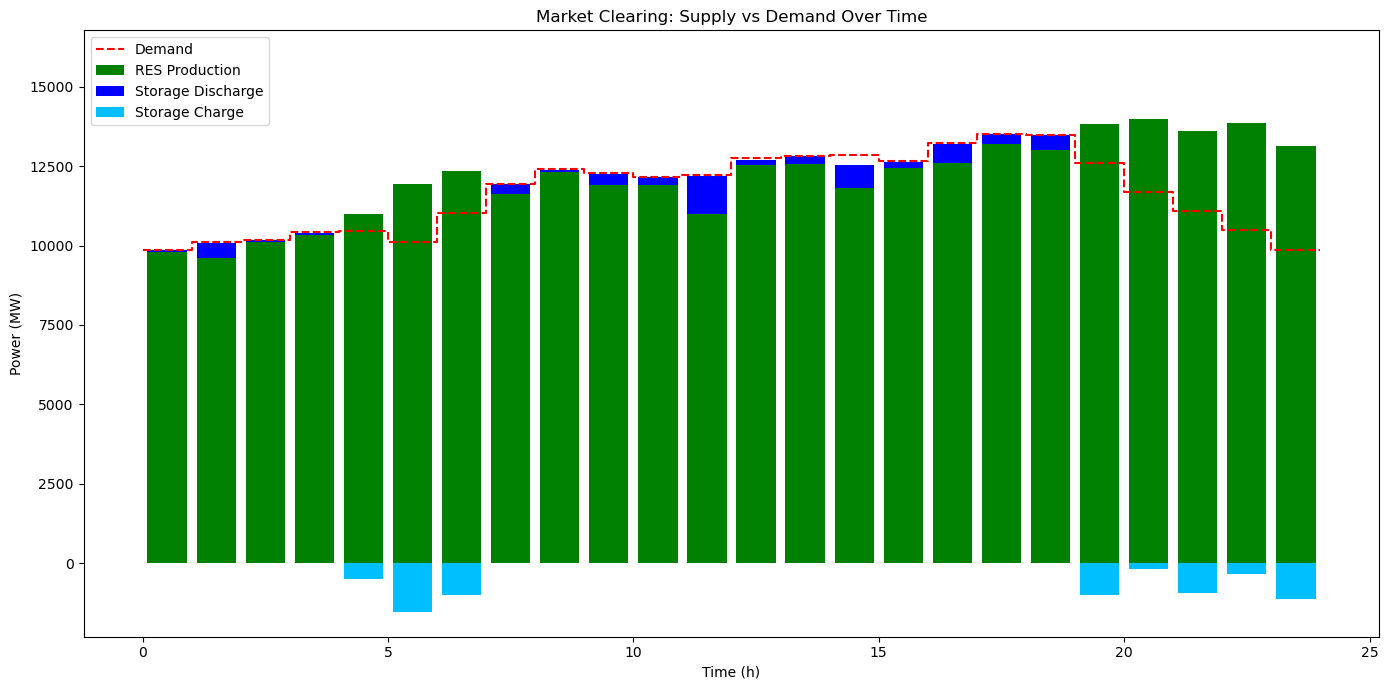

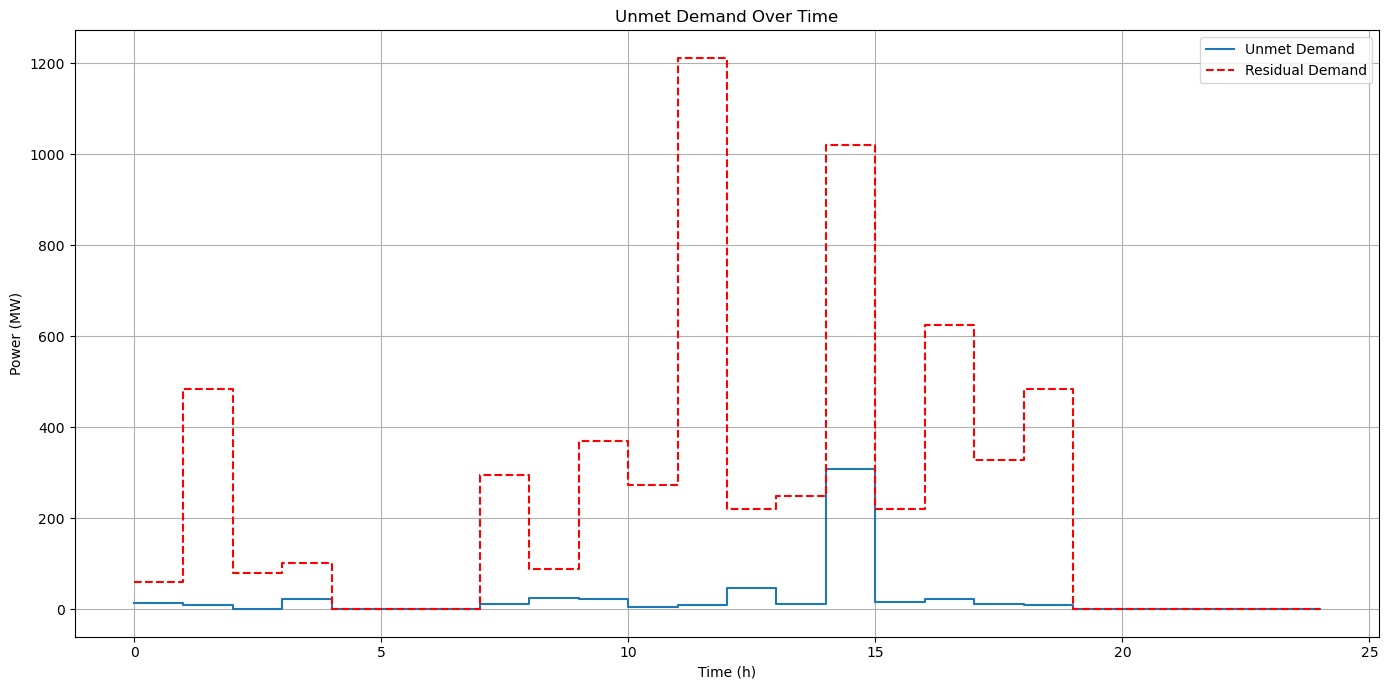

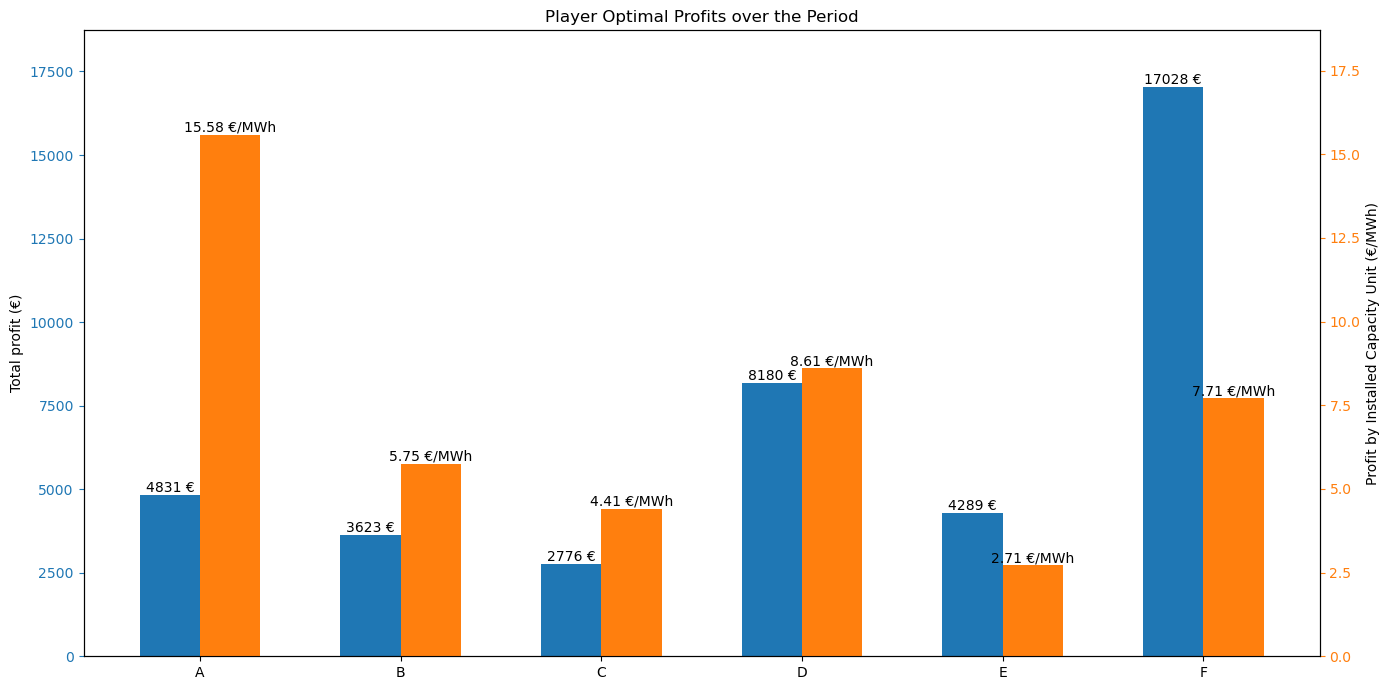

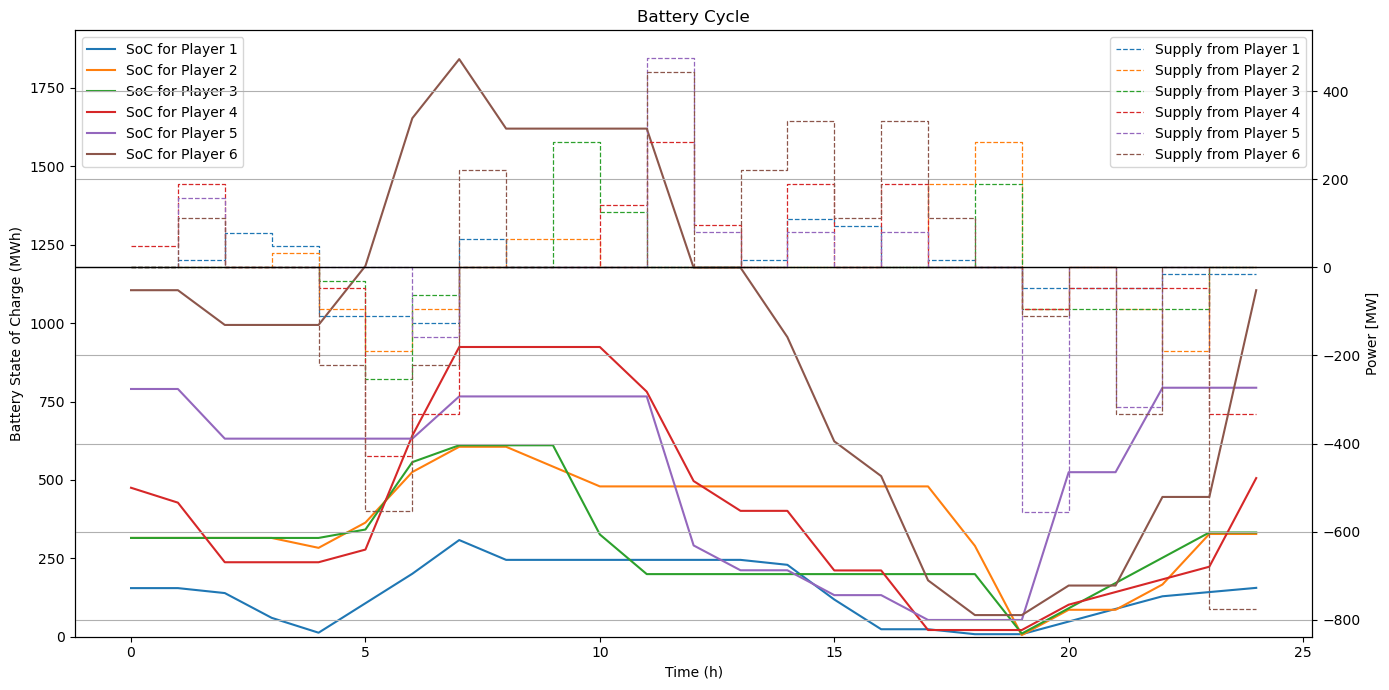

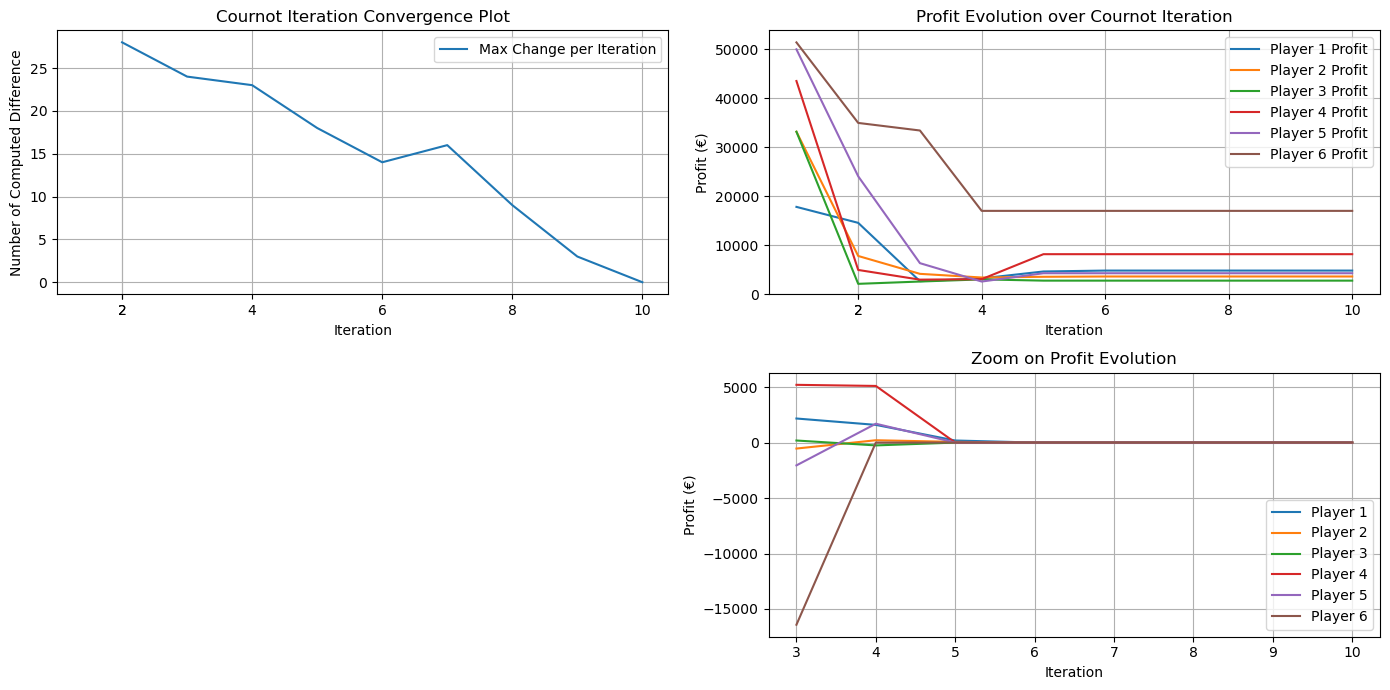

Running Winter - 8 players
  Player   OC   Eta   E_max  Q_max  \
0      A  0.5  0.85   310.0  158.0   
1      B  0.5  0.85   310.0  158.0   
2      C  0.5  0.85   630.0  316.0   
3      D  0.5  0.85   630.0  316.0   
4      E  0.5  0.85   630.0  316.0   
5      F  0.5  0.85   950.0  475.0   
6      G  0.5  0.85  1260.0  633.0   
7      H  0.5  0.85  1580.0  792.0   

                                             Q_steps  
0  [0.0, 15.8, 31.6, 47.4, 63.2, 79.0, 94.8, 110....  
1  [0.0, 15.8, 31.6, 47.4, 63.2, 79.0, 94.8, 110....  
2  [0.0, 31.6, 63.2, 94.8, 126.4, 158.0, 189.6, 2...  
3  [0.0, 31.6, 63.2, 94.8, 126.4, 158.0, 189.6, 2...  
4  [0.0, 31.6, 63.2, 94.8, 126.4, 158.0, 189.6, 2...  
5  [0.0, 47.5, 95.0, 142.5, 190.0, 237.5, 285.0, ...  
6  [0.0, 63.3, 126.6, 189.9, 253.2, 316.5, 379.8,...  
7  [0.0, 79.2, 158.4, 237.6, 316.8, 396.0, 475.2,...  
Optimization was successful. It converged in 14 iterations.


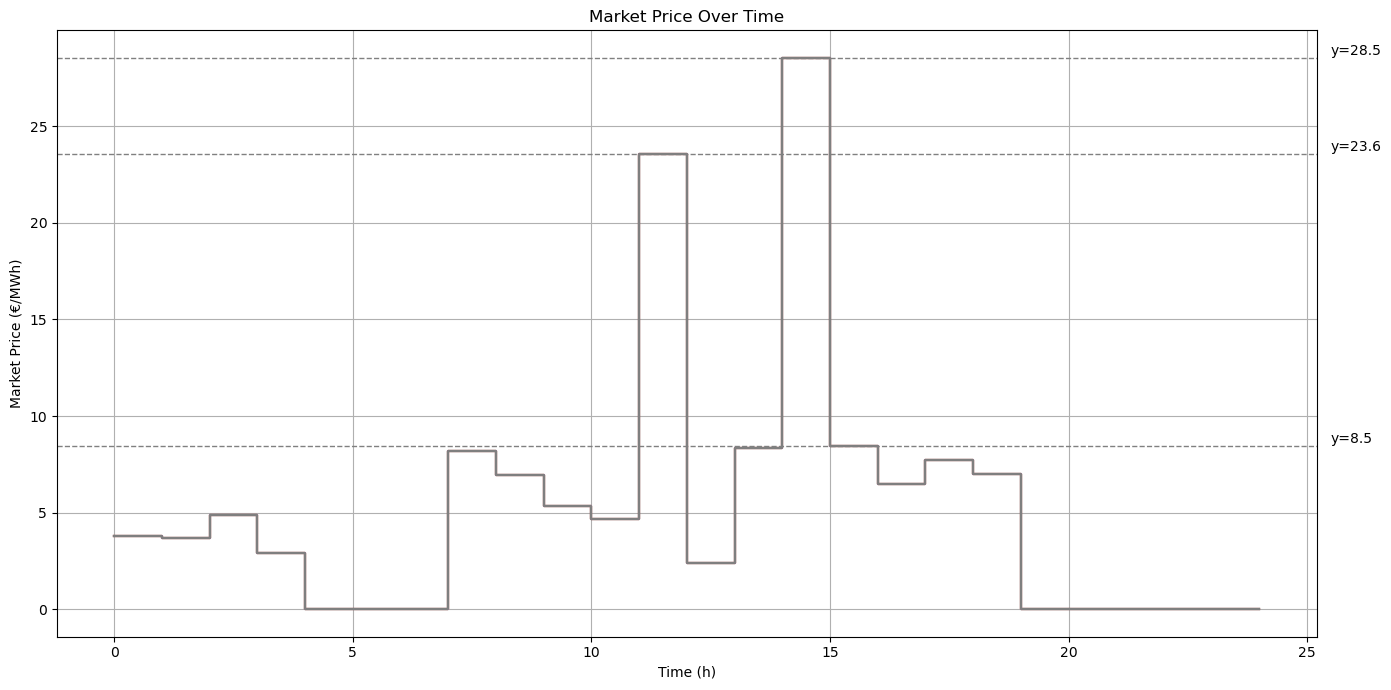

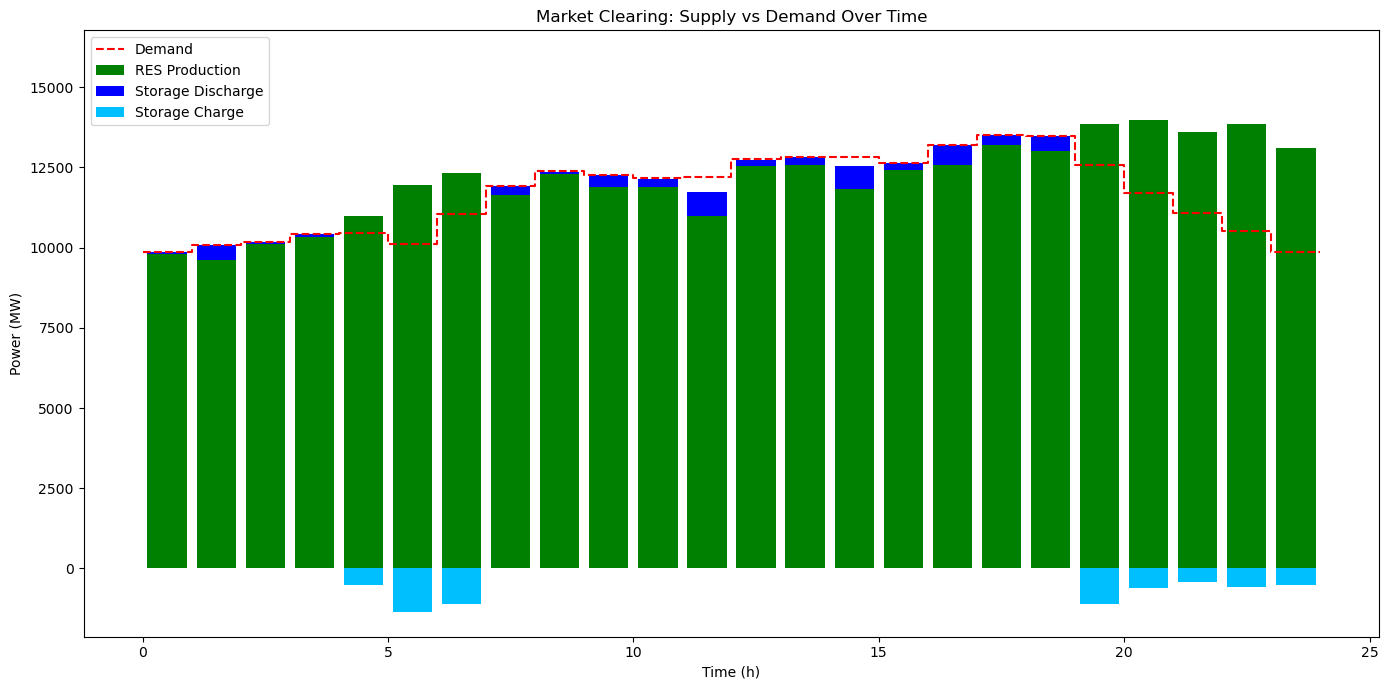

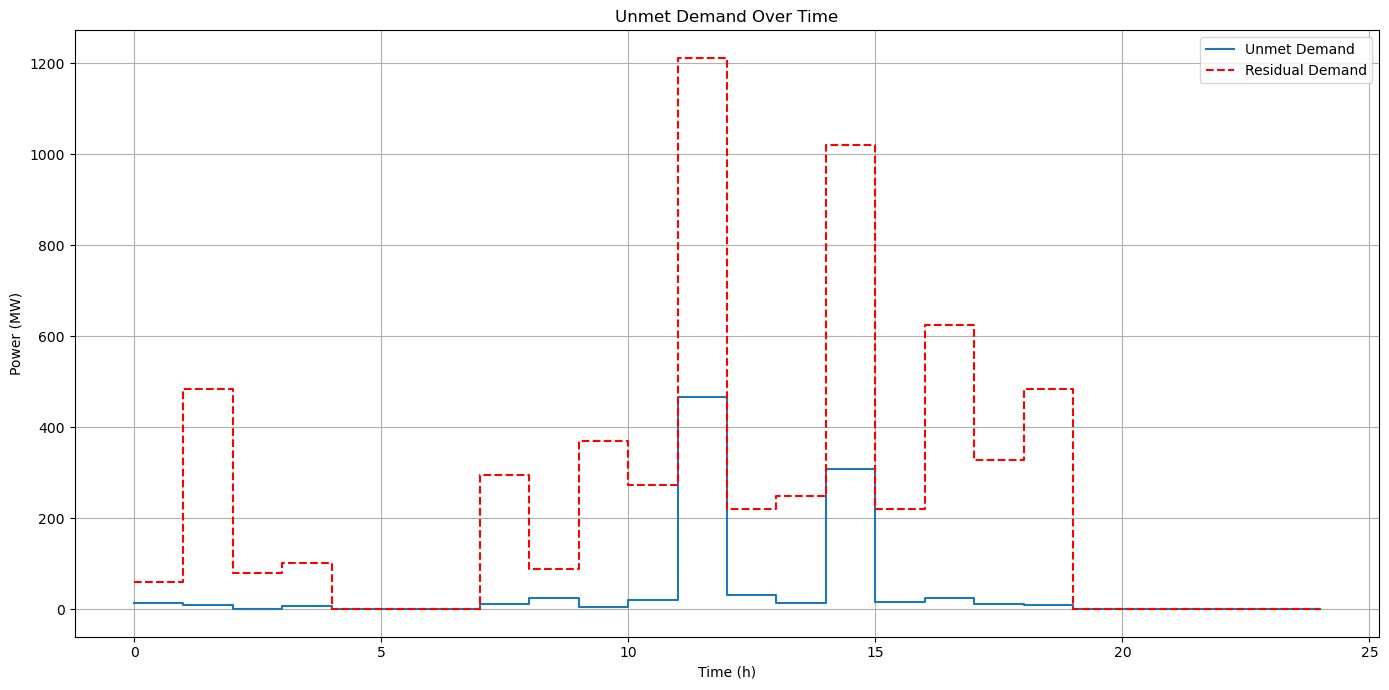

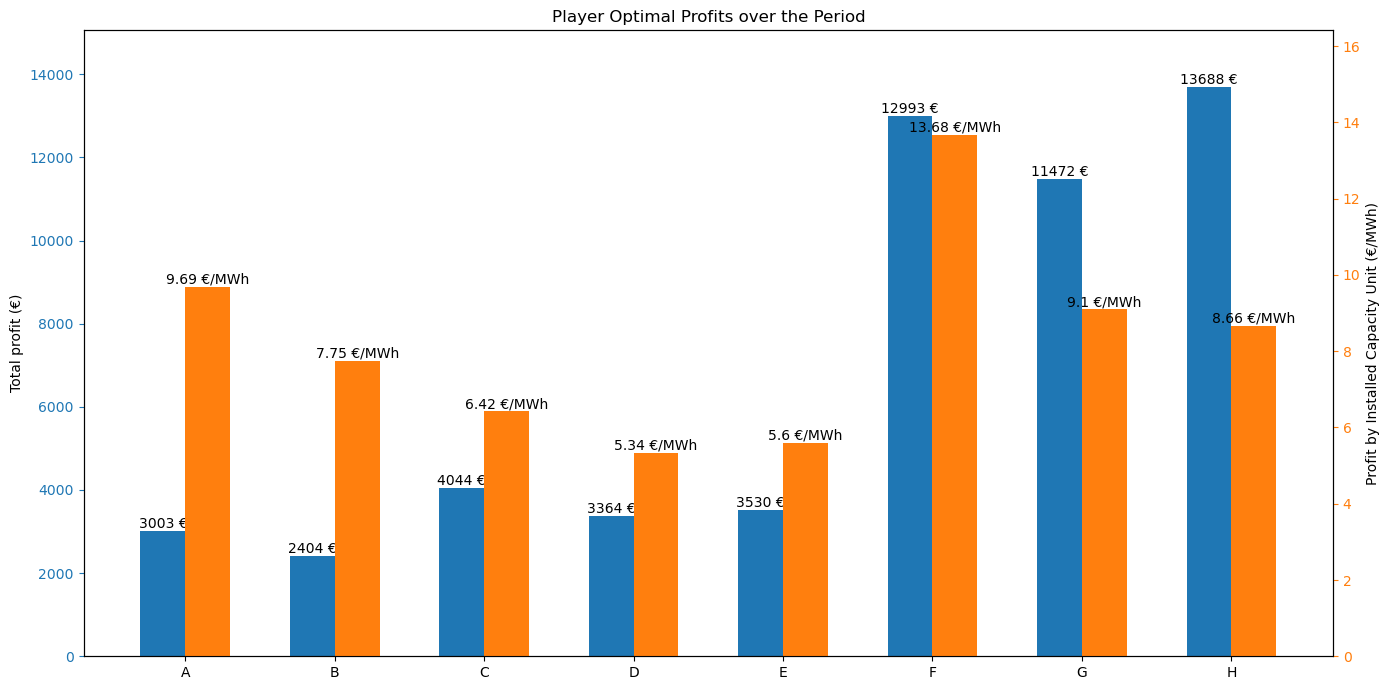

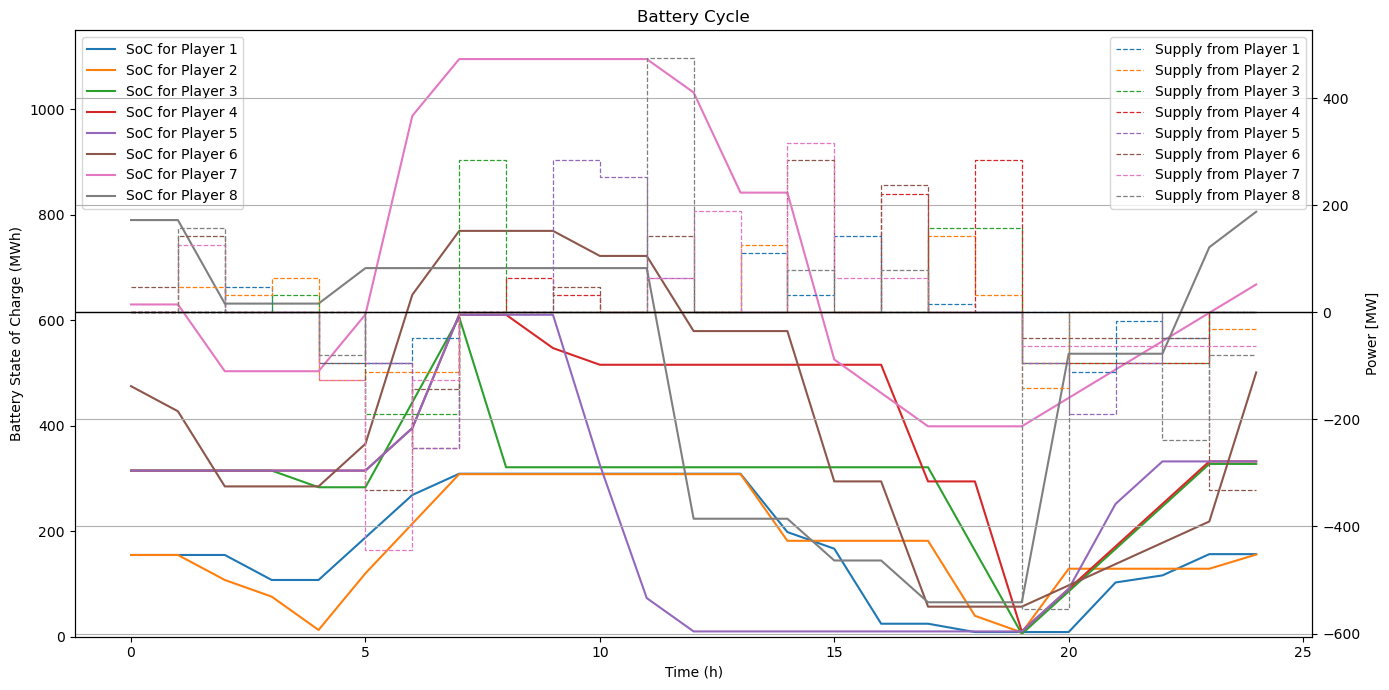

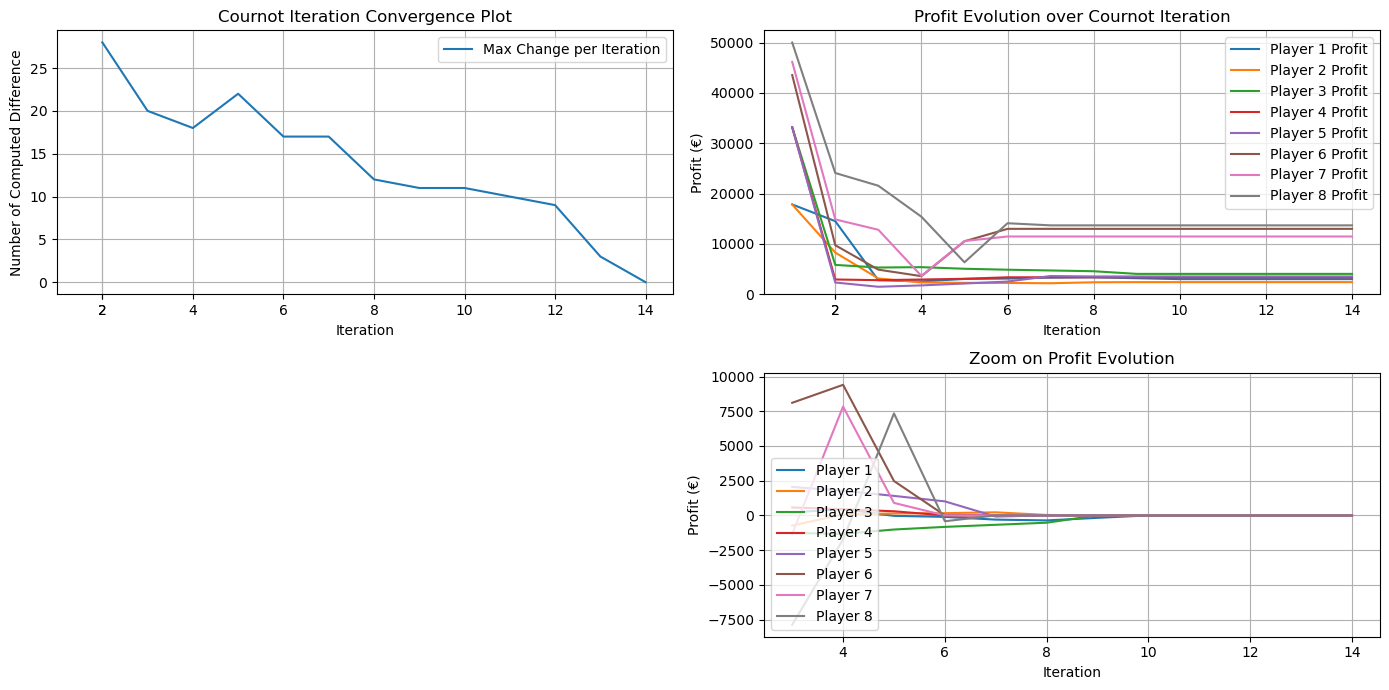

Running Summer - 1 players
  Player   OC   Eta    E_max   Q_max  \
0      A  0.5  0.85  11520.0  5761.0   

                                             Q_steps  
0  [0.0, 576.1, 1152.2, 1728.3, 2304.4, 2880.5, 3...  


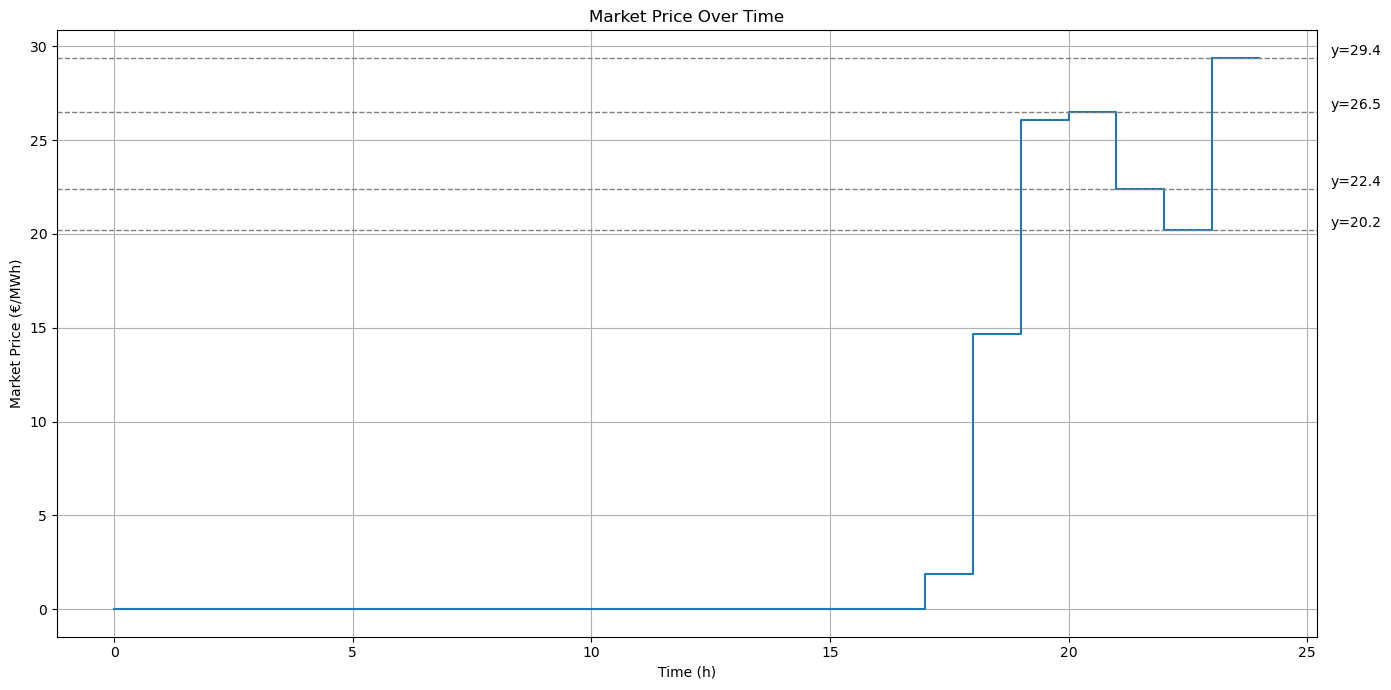

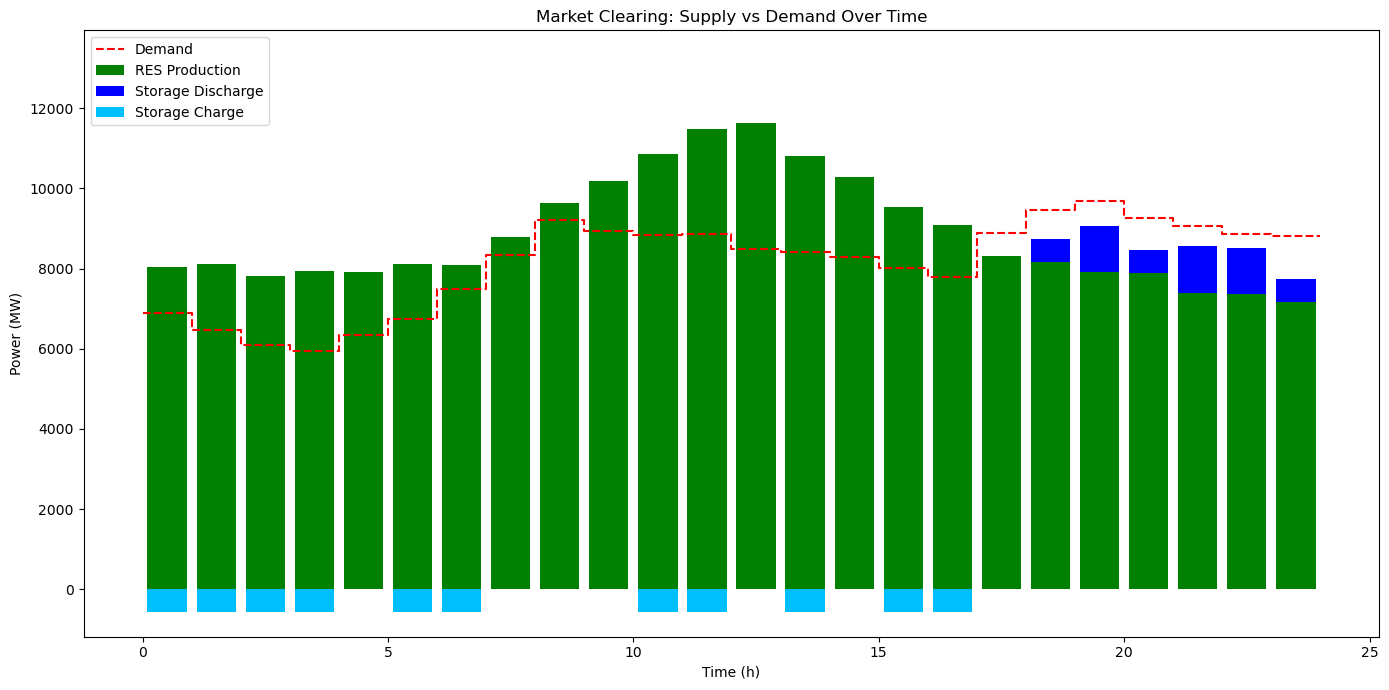

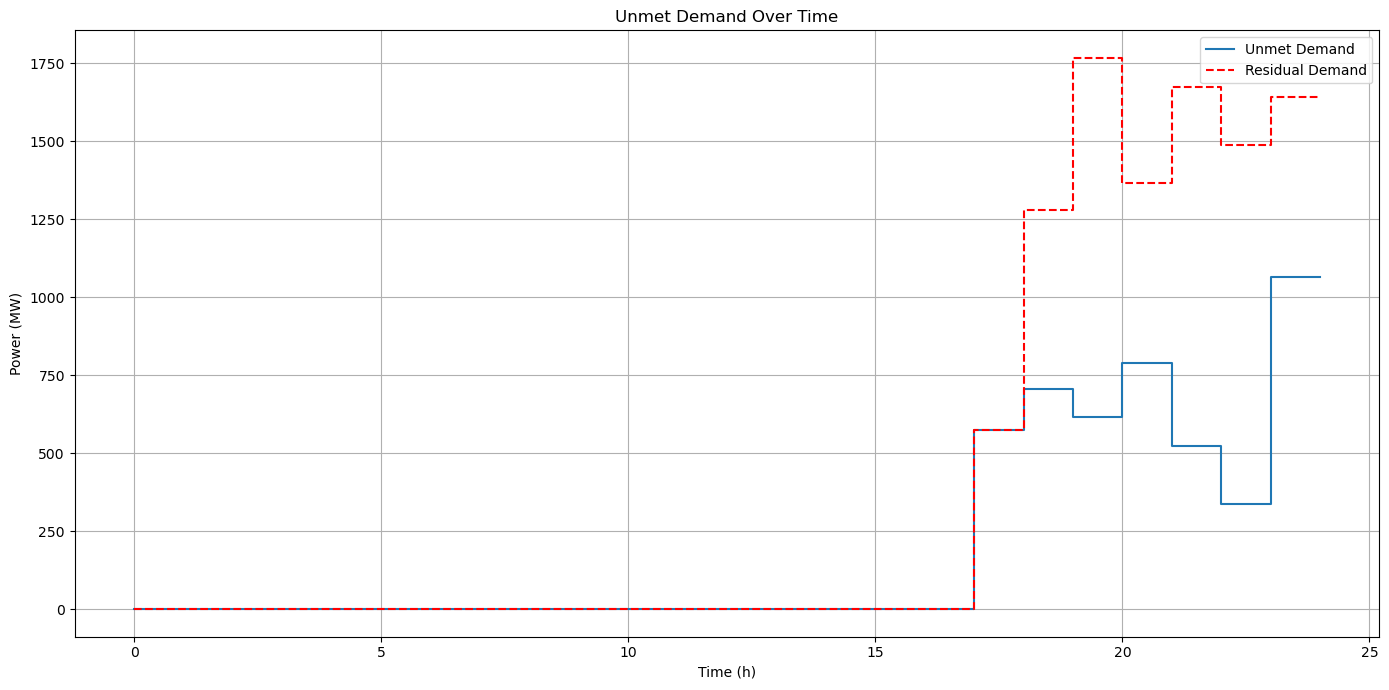

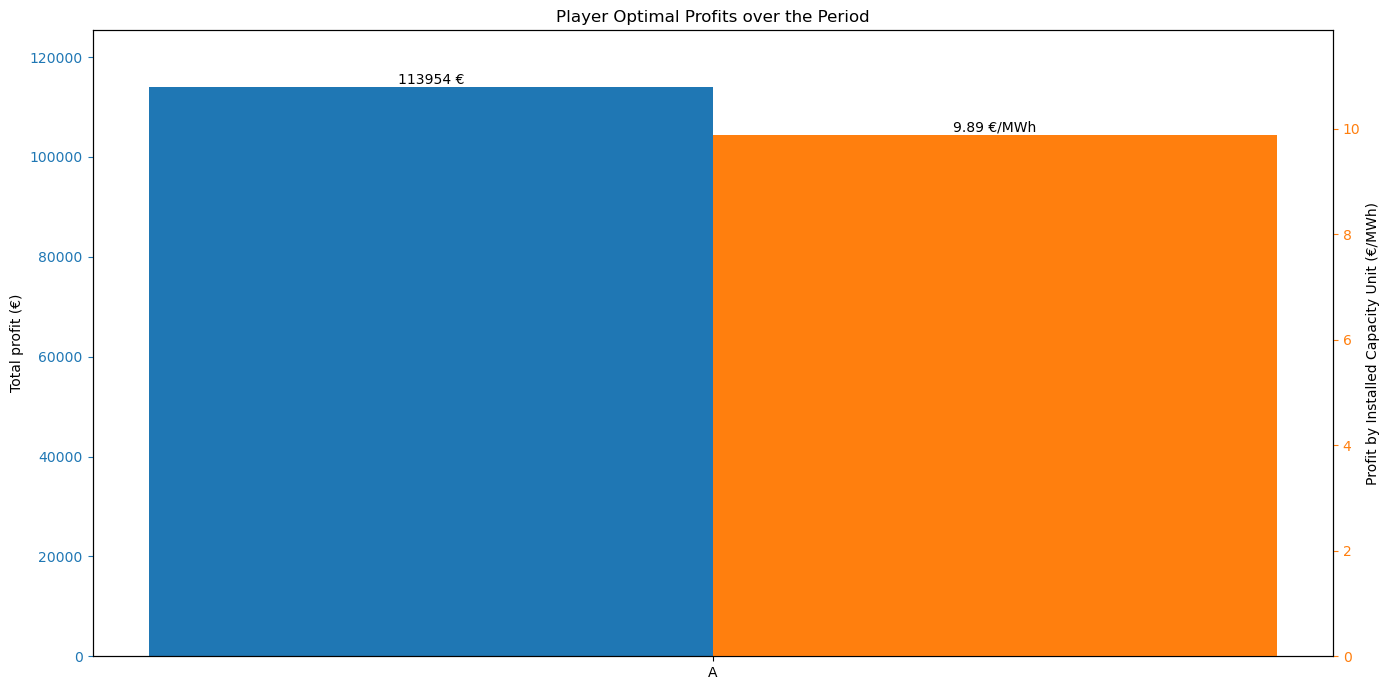

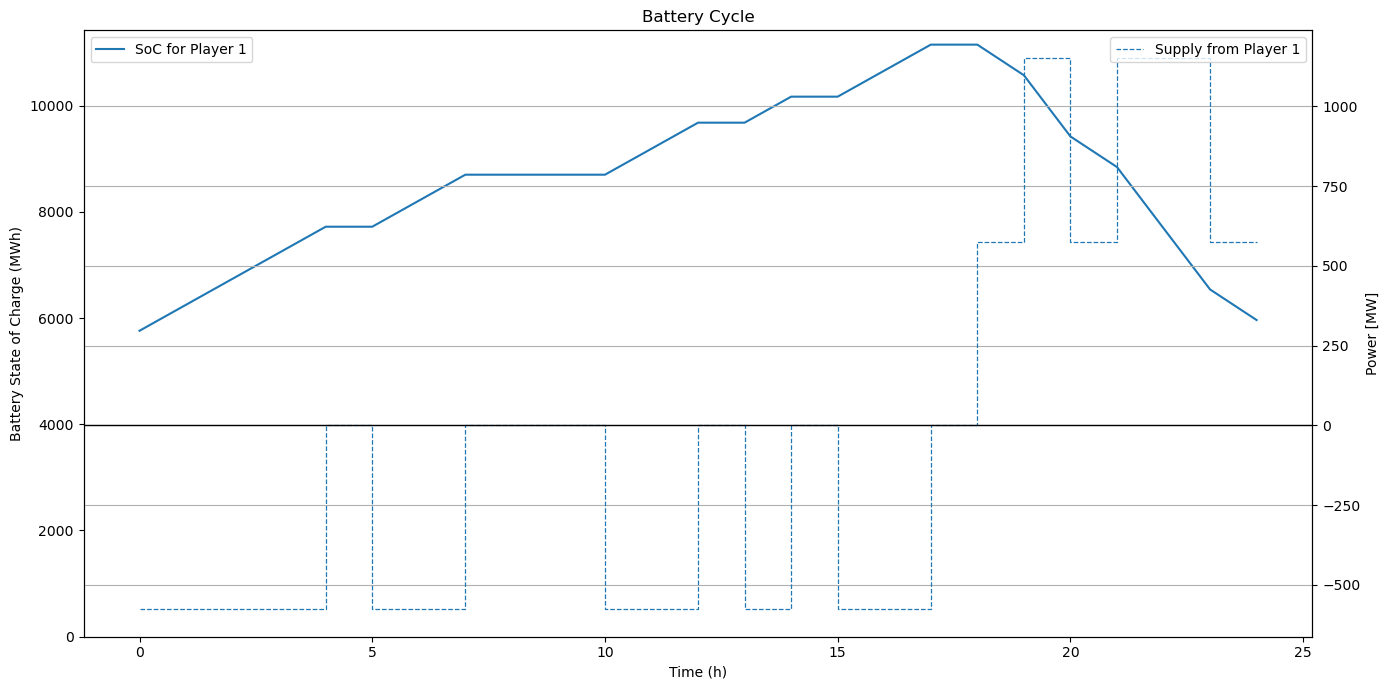

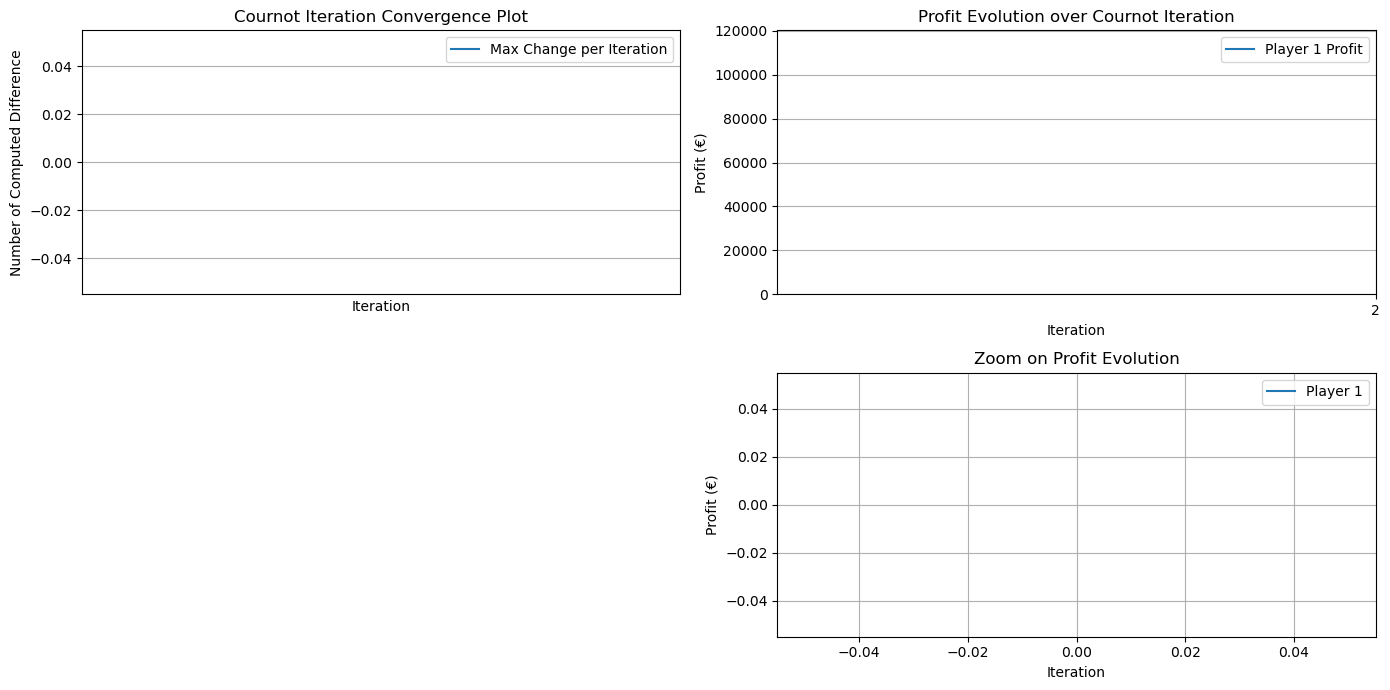

Running Summer - 2 players
  Player   OC   Eta   E_max   Q_max  \
0      A  0.5  0.85  3840.0  1920.0   
1      B  0.5  0.85  7680.0  3840.0   

                                             Q_steps  
0  [0.0, 192.0, 384.0, 576.0, 768.0, 960.0, 1152....  
1  [0.0, 384.0, 768.0, 1152.0, 1536.0, 1920.0, 23...  
Optimization was successful. It converged in 5 iterations.


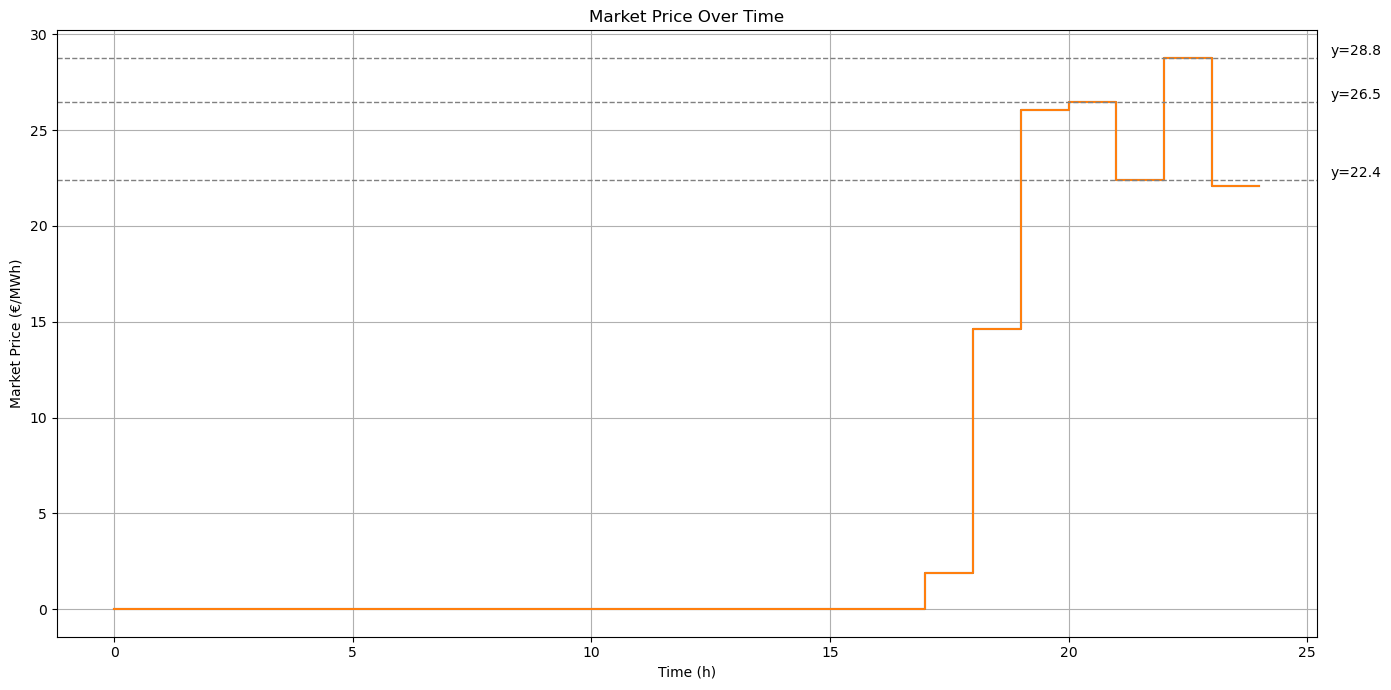

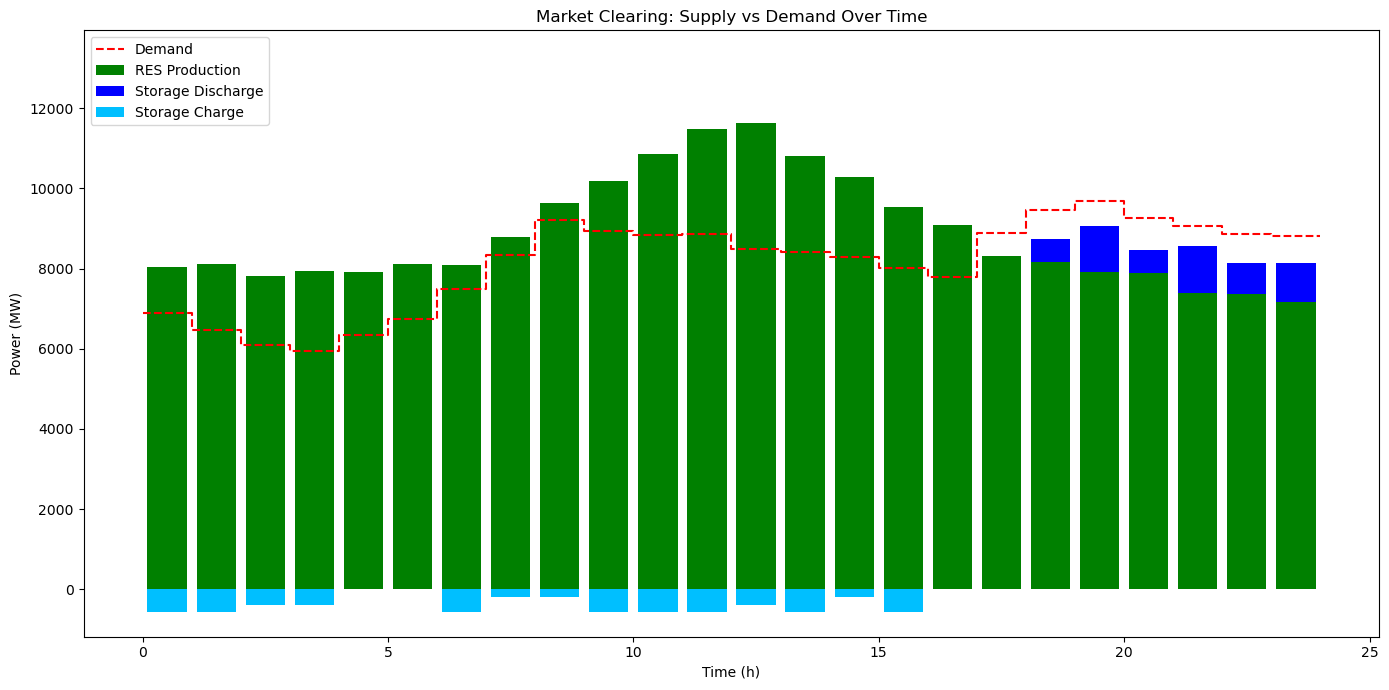

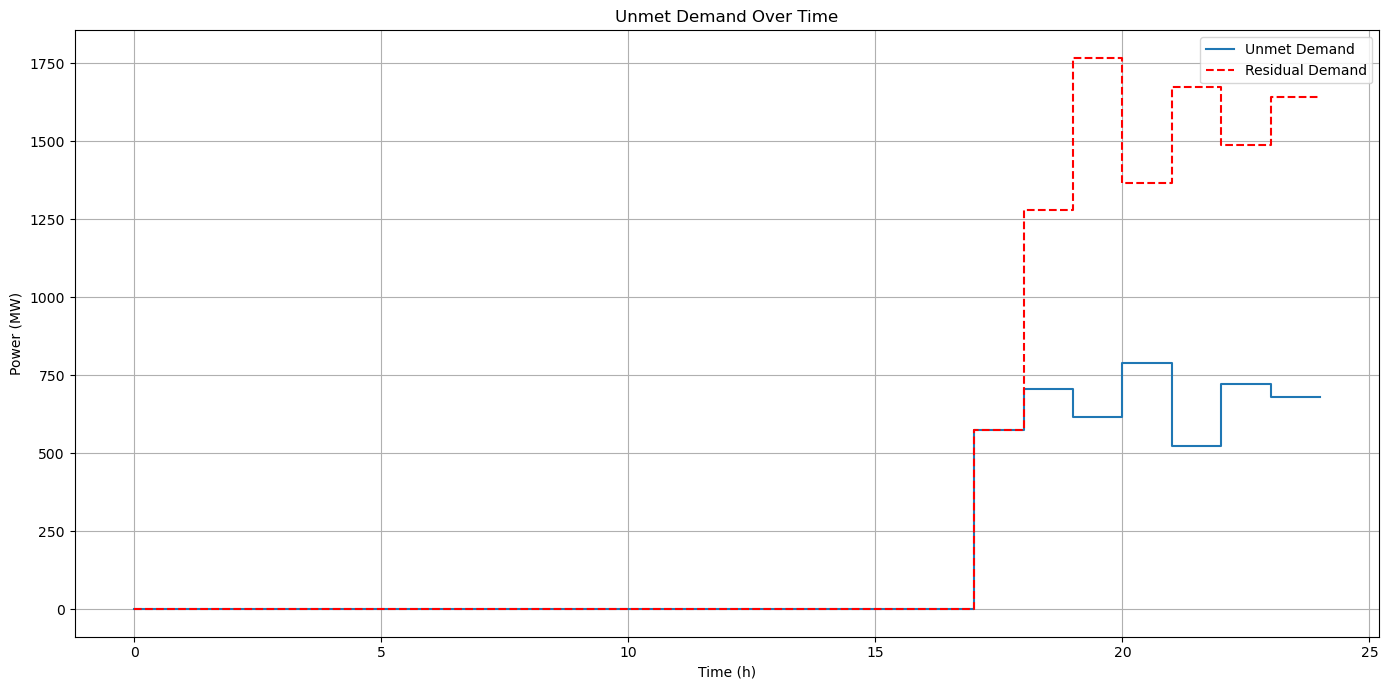

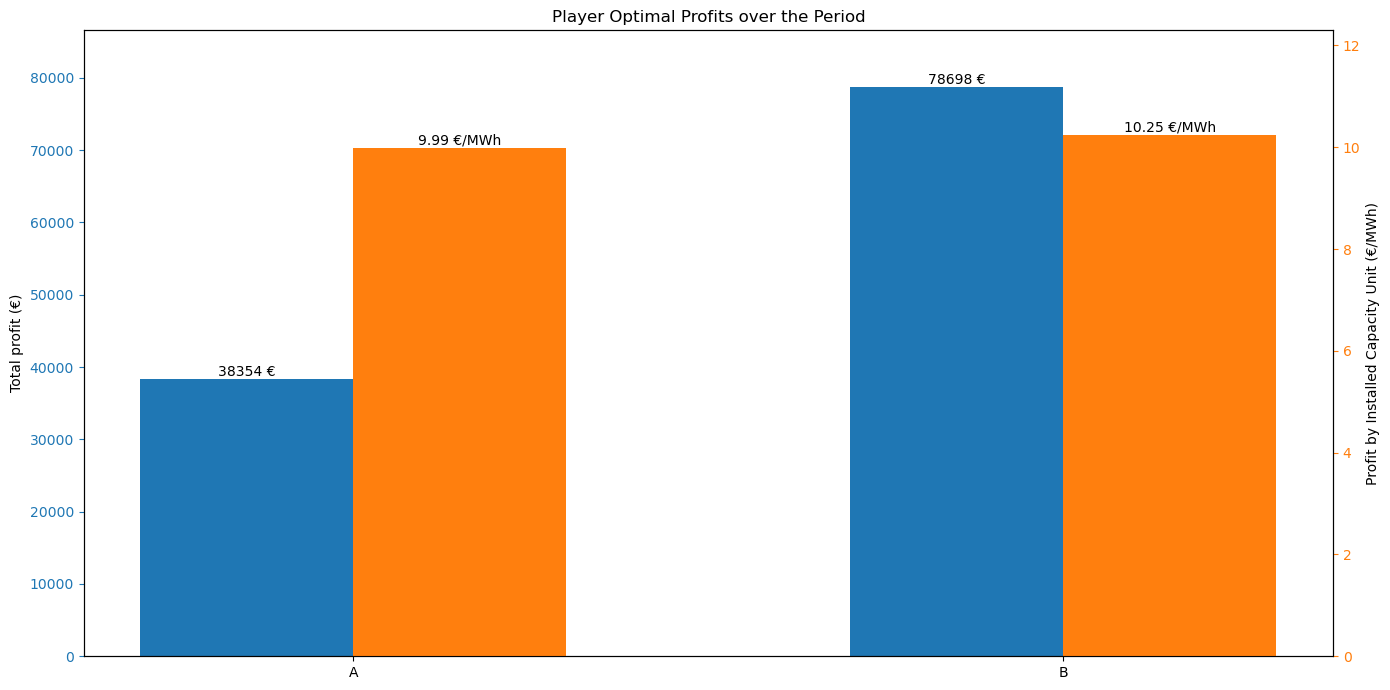

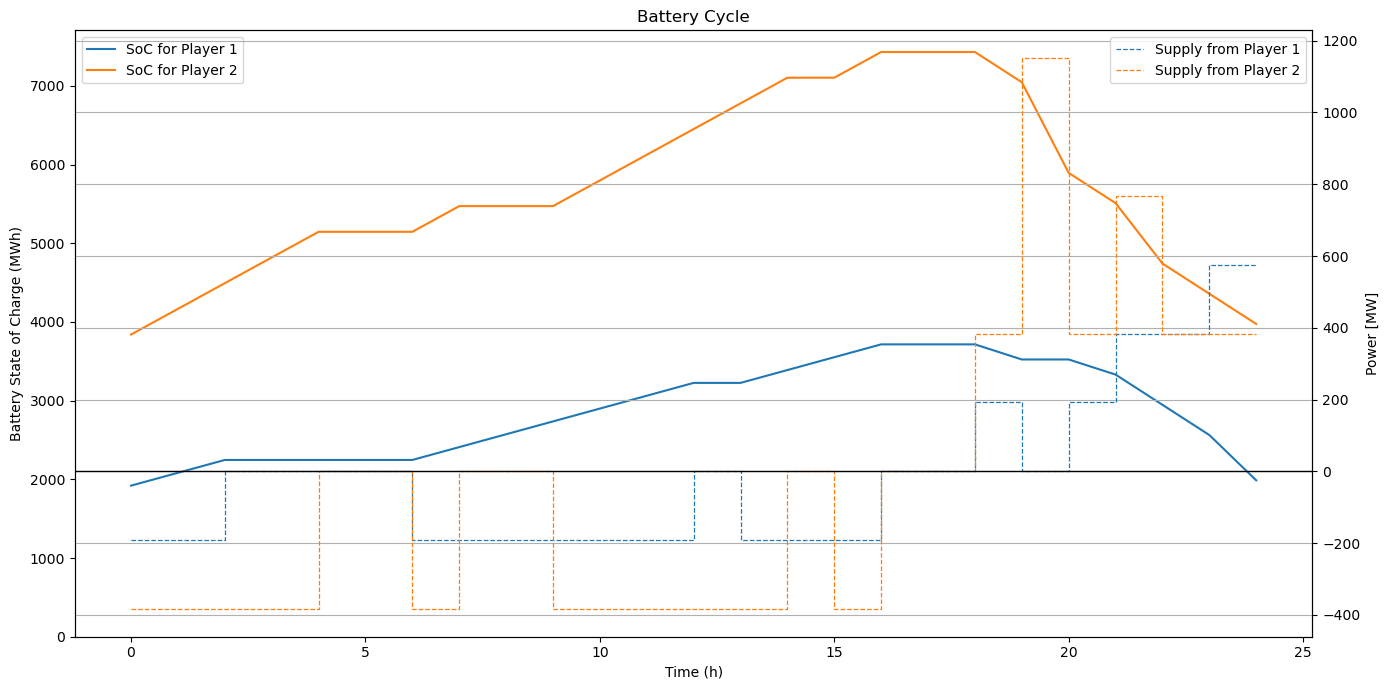

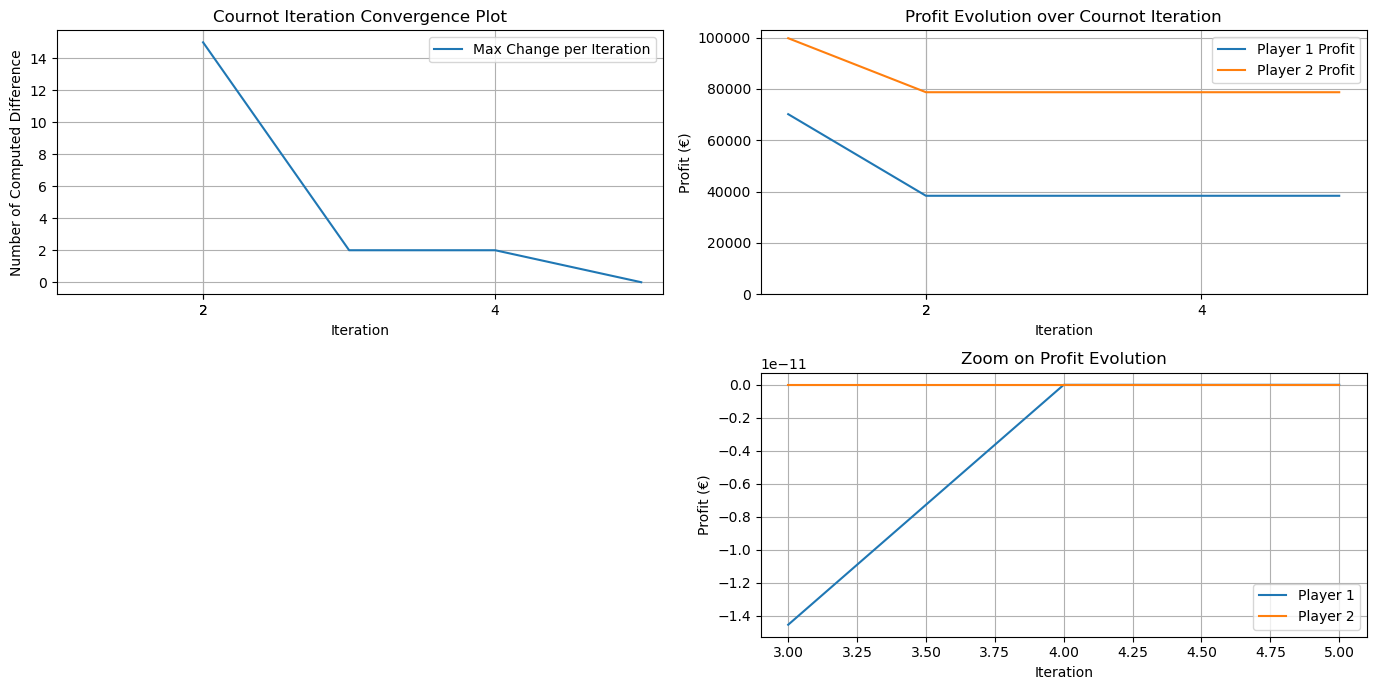

Running Summer - 4 players
  Player   OC   Eta   E_max   Q_max  \
0      A  0.5  0.85  1150.0   576.0   
1      B  0.5  0.85  2300.0  1152.0   
2      C  0.5  0.85  3450.0  1728.0   
3      D  0.5  0.85  4600.0  2304.0   

                                             Q_steps  
0  [0.0, 57.6, 115.2, 172.8, 230.4, 288.0, 345.6,...  
1  [0.0, 115.2, 230.4, 345.6, 460.8, 576.0, 691.2...  
2  [0.0, 172.8, 345.6, 518.4, 691.2, 864.0, 1036....  
3  [0.0, 230.4, 460.8, 691.2, 921.6, 1152.0, 1382...  
Optimization was successful. It converged in 7 iterations.


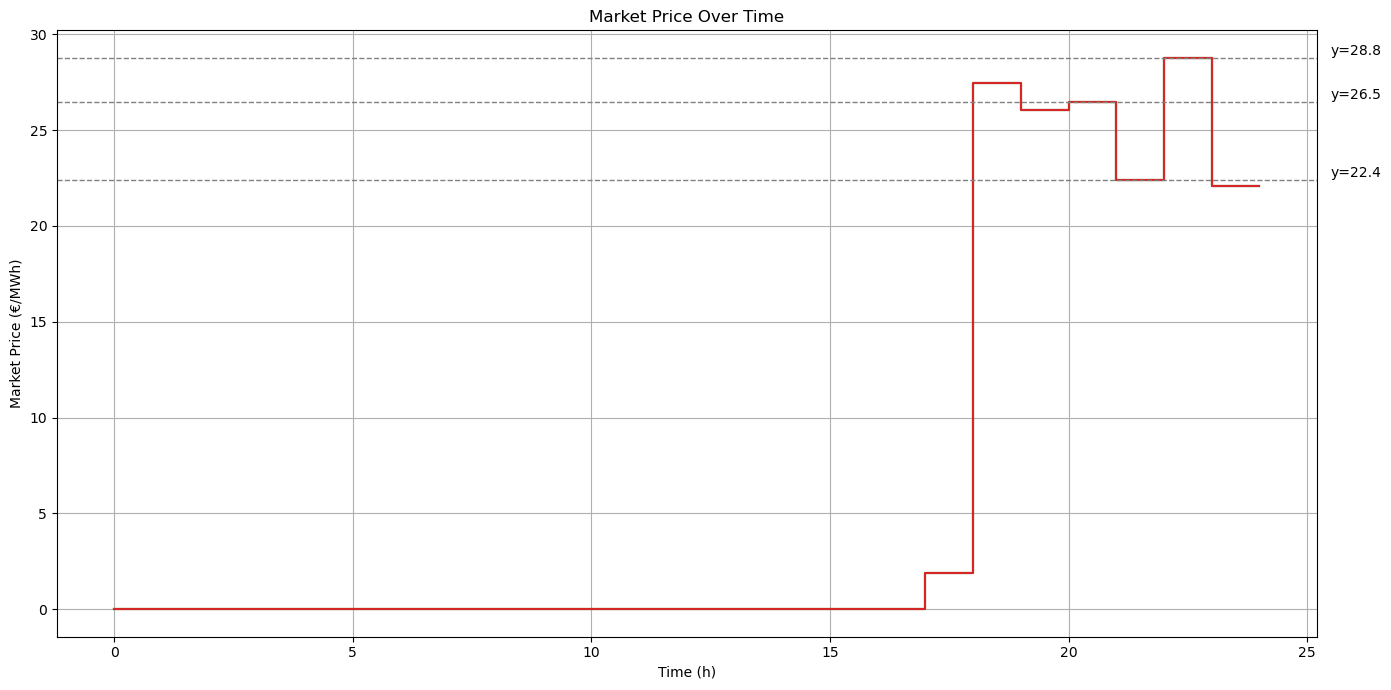

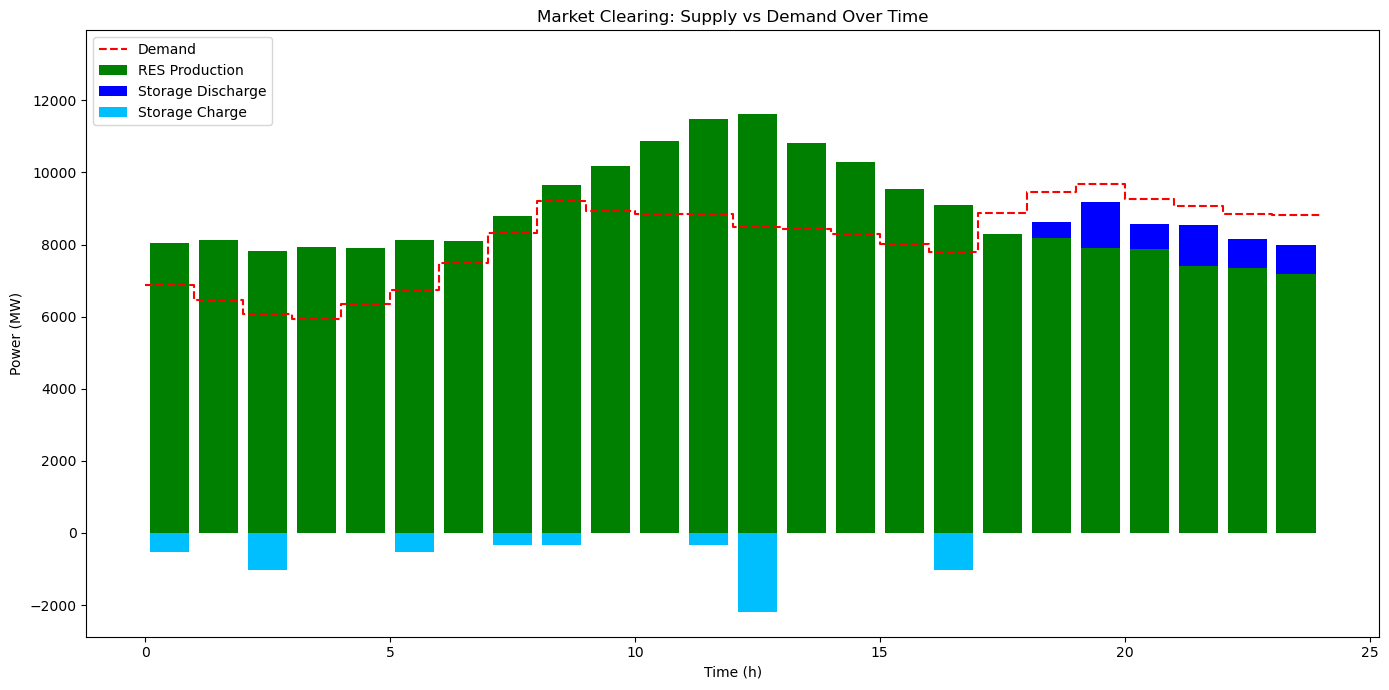

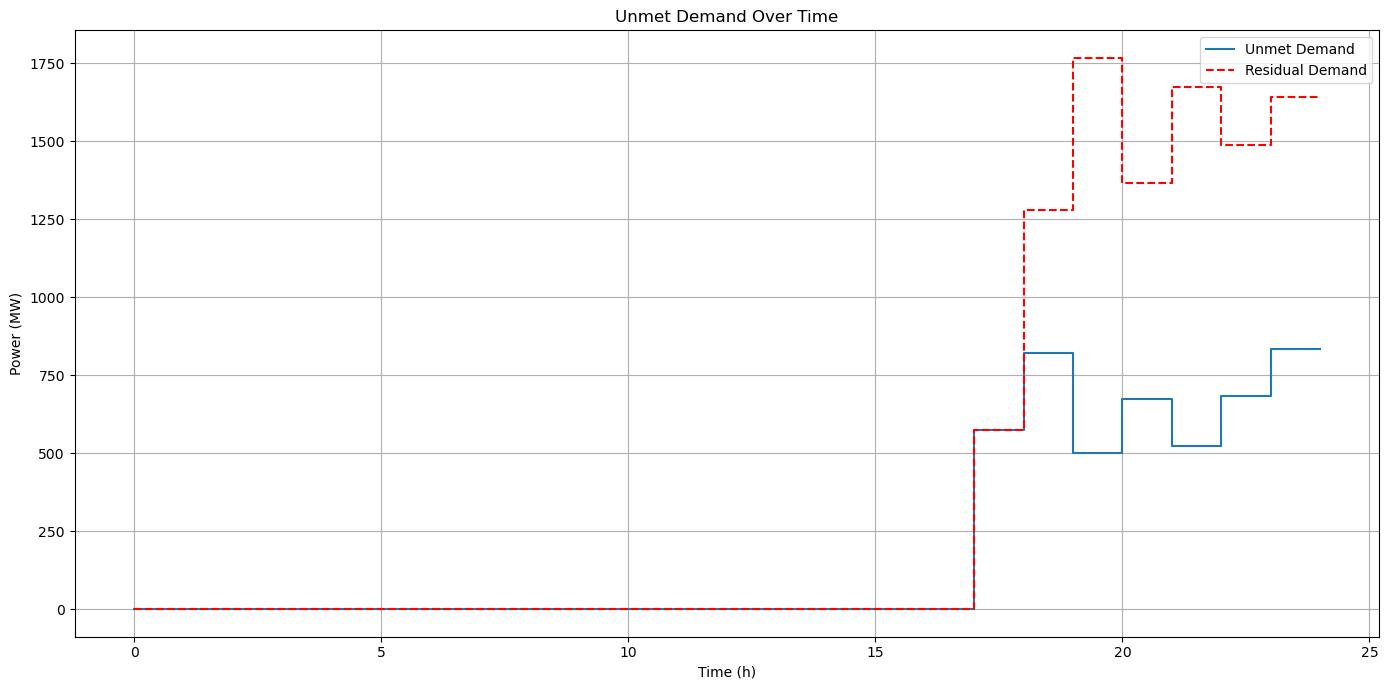

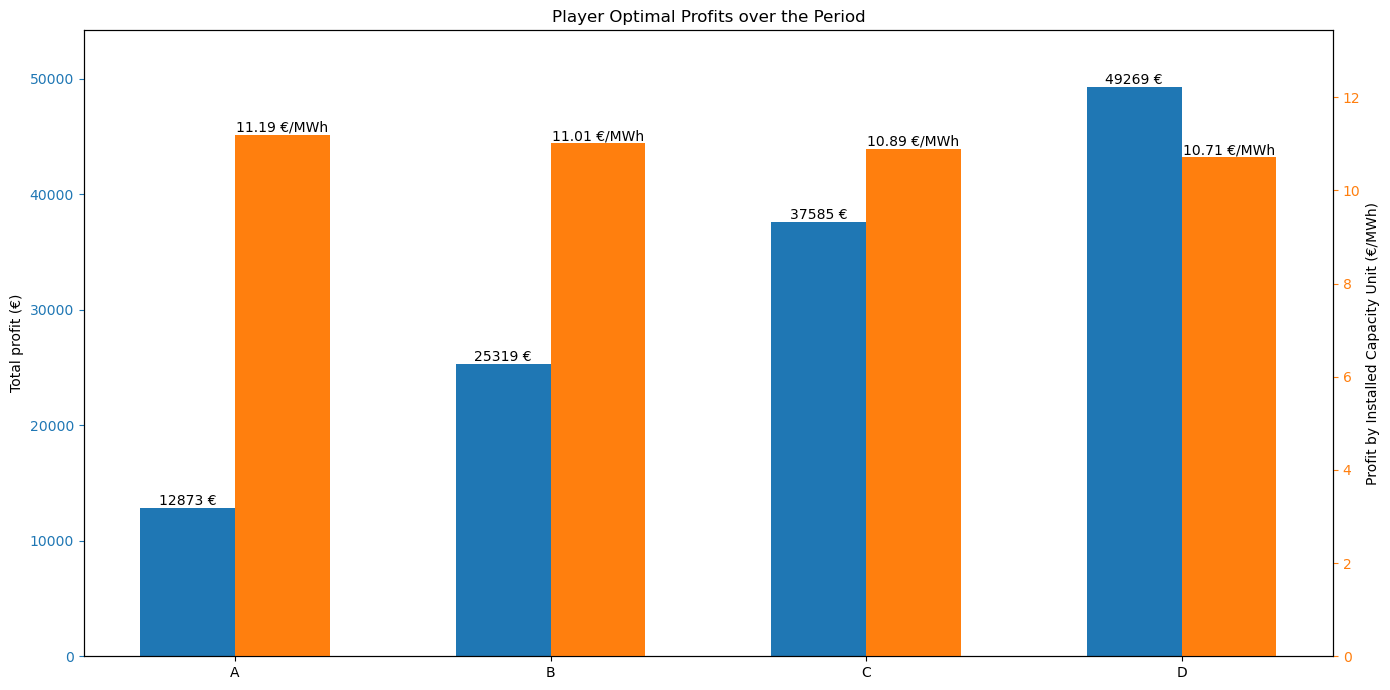

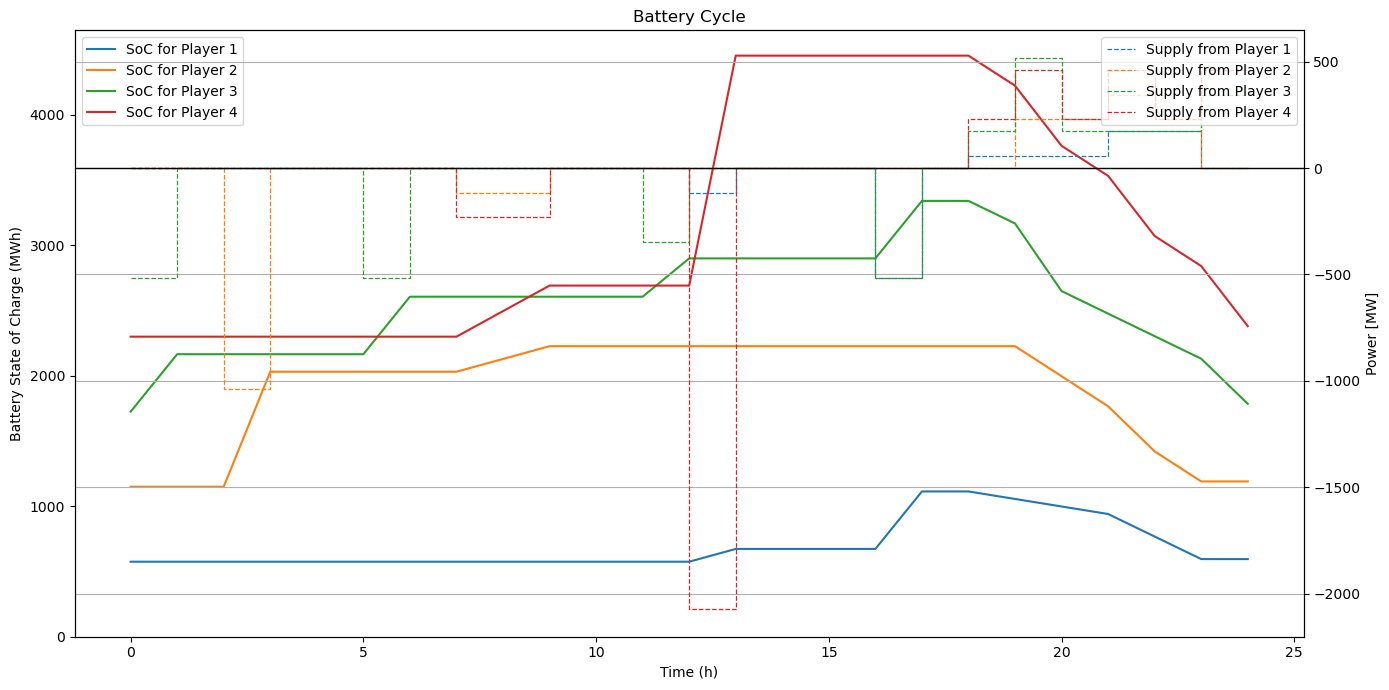

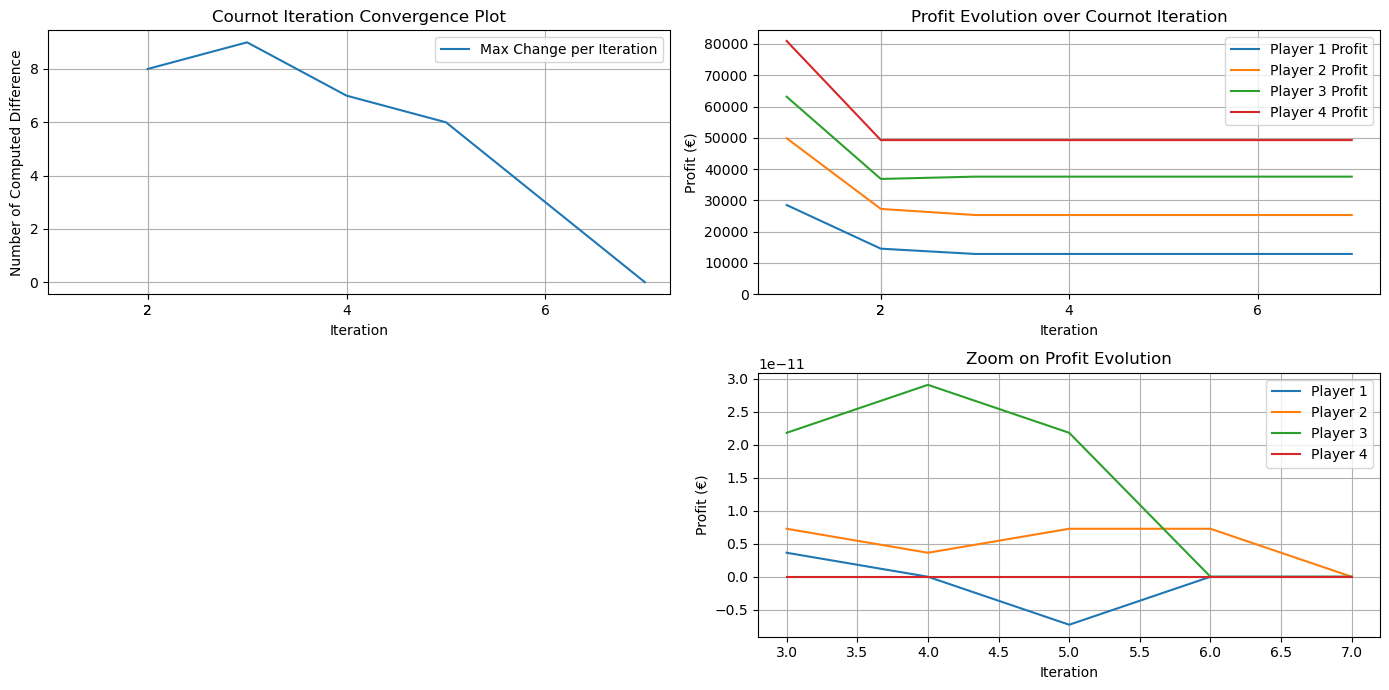

Running Summer - 6 players
  Player   OC   Eta   E_max   Q_max  \
0      A  0.5  0.85   570.0   288.0   
1      B  0.5  0.85  1150.0   576.0   
2      C  0.5  0.85  1150.0   576.0   
3      D  0.5  0.85  1720.0   864.0   
4      E  0.5  0.85  2880.0  1440.0   
5      F  0.5  0.85  4030.0  2016.0   

                                             Q_steps  
0  [0.0, 28.8, 57.6, 86.4, 115.2, 144.0, 172.8, 2...  
1  [0.0, 57.6, 115.2, 172.8, 230.4, 288.0, 345.6,...  
2  [0.0, 57.6, 115.2, 172.8, 230.4, 288.0, 345.6,...  
3  [0.0, 86.4, 172.8, 259.2, 345.6, 432.0, 518.4,...  
4  [0.0, 144.0, 288.0, 432.0, 576.0, 720.0, 864.0...  
5  [0.0, 201.6, 403.2, 604.8, 806.4, 1008.0, 1209...  
Convergence has not been reached. Let's try again by fixing player A outputs.
Convergence has not been reached. Let's try again by fixing player B outputs.
Optimization was successful. It converged in 221 iterations.


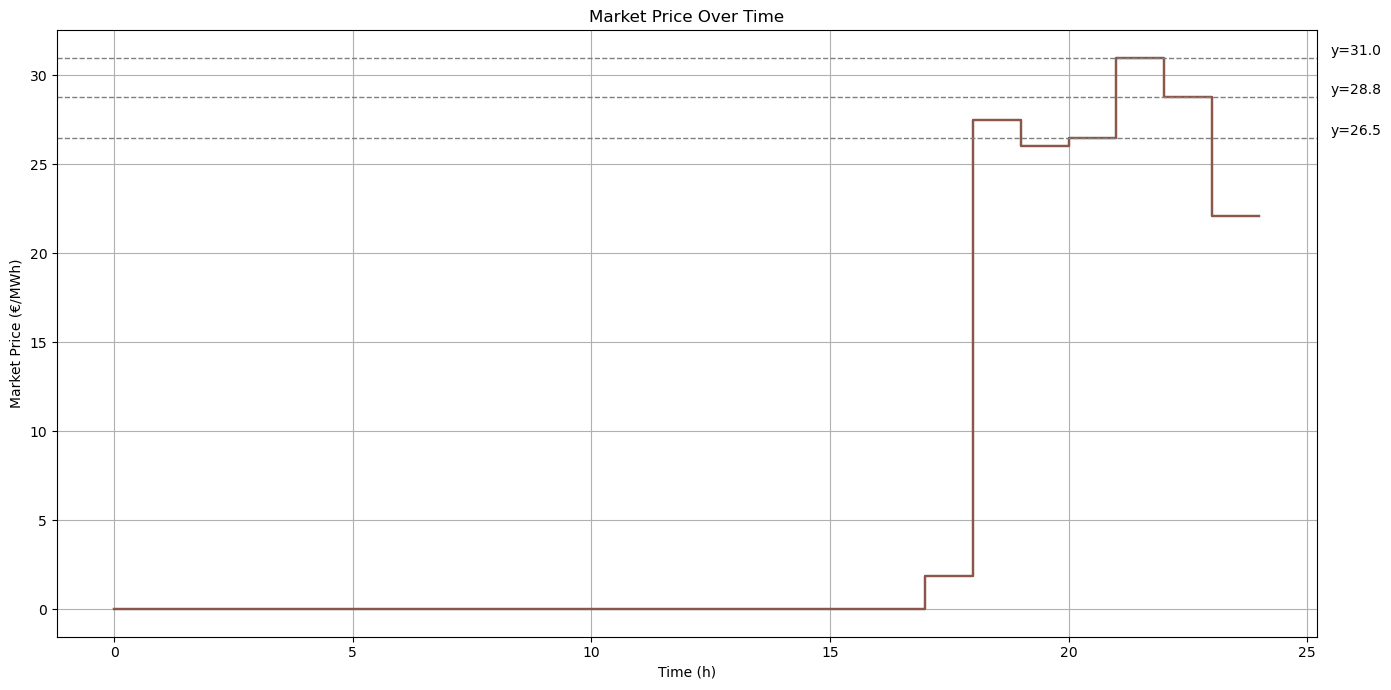

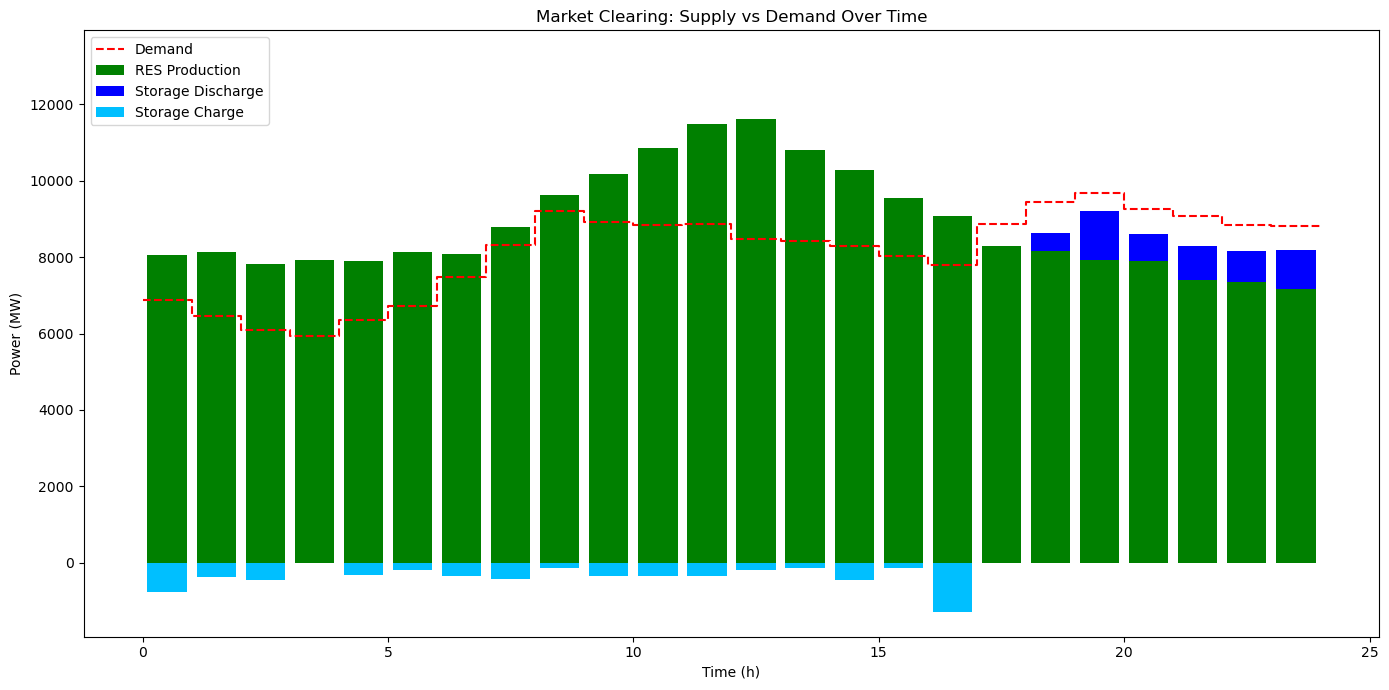

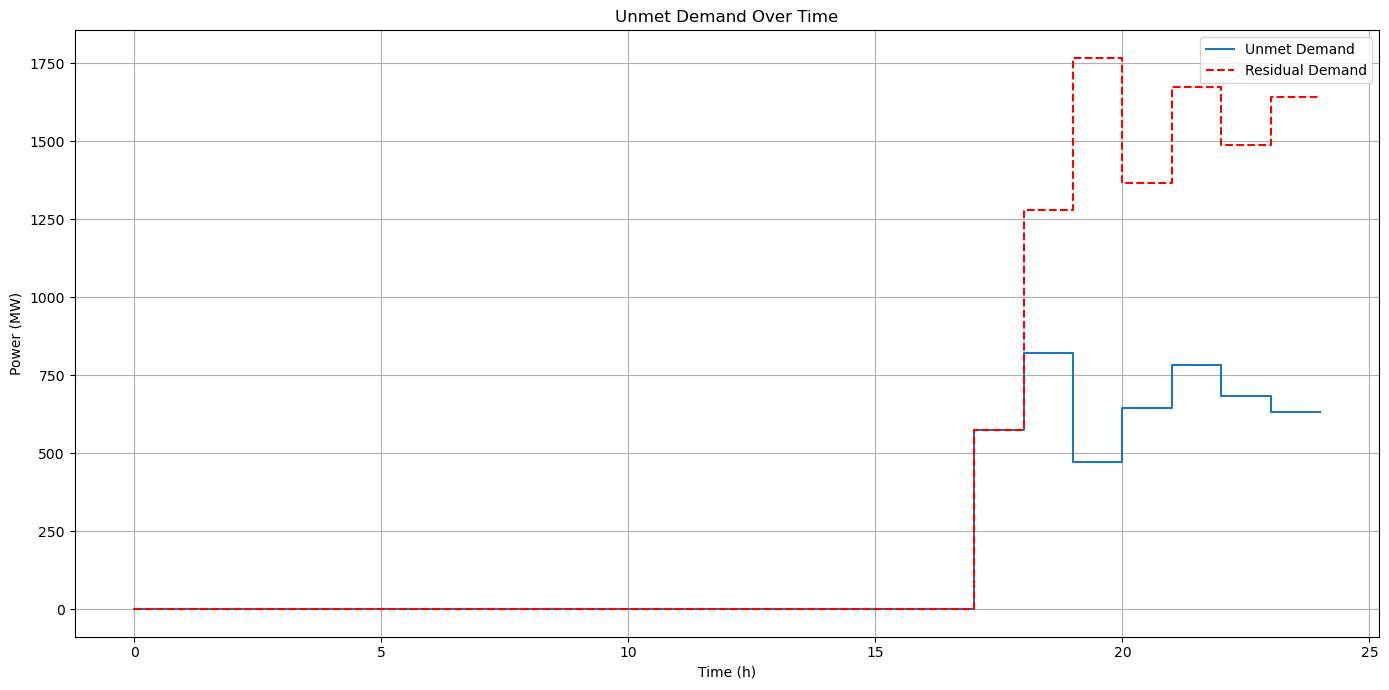

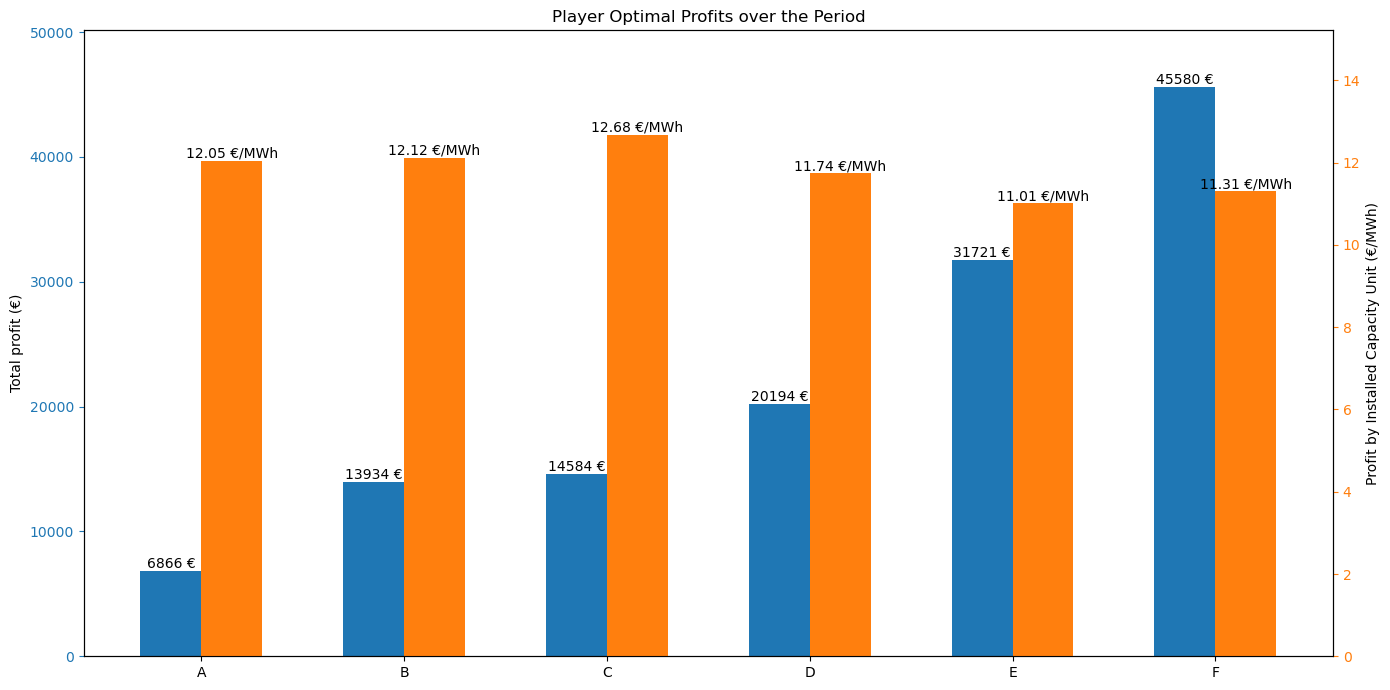

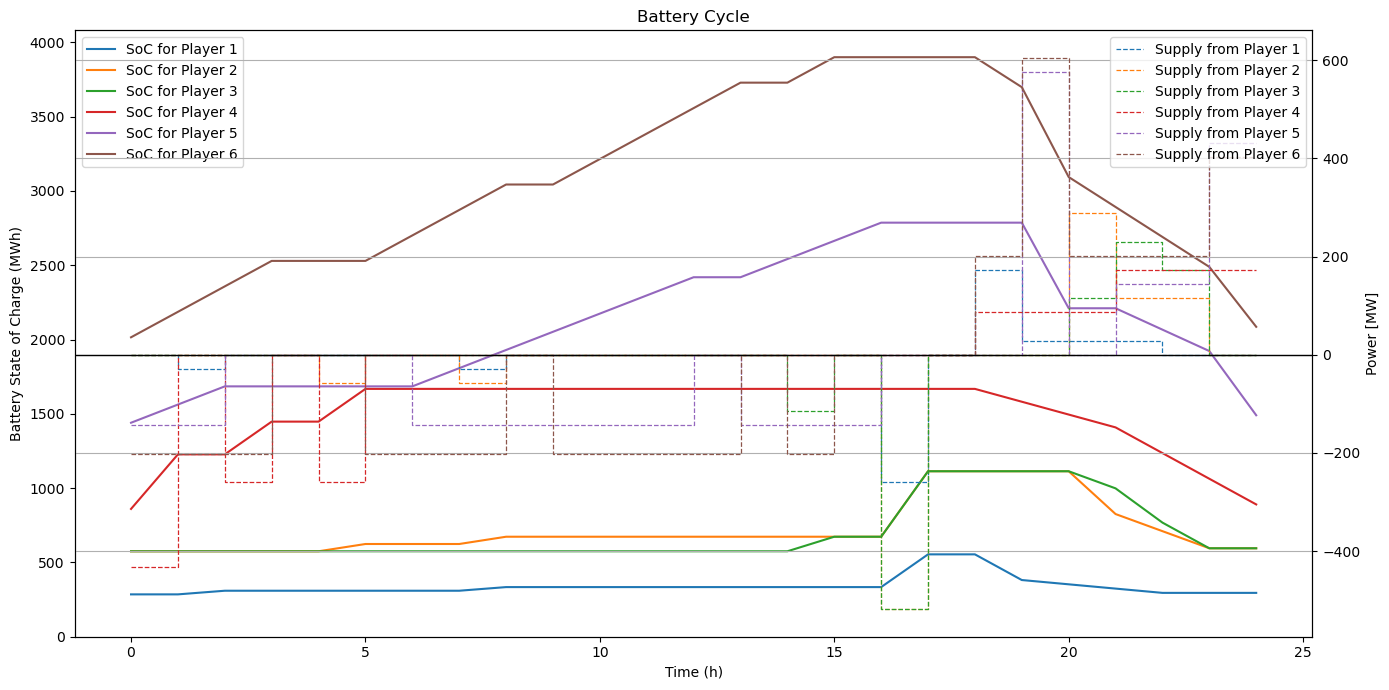

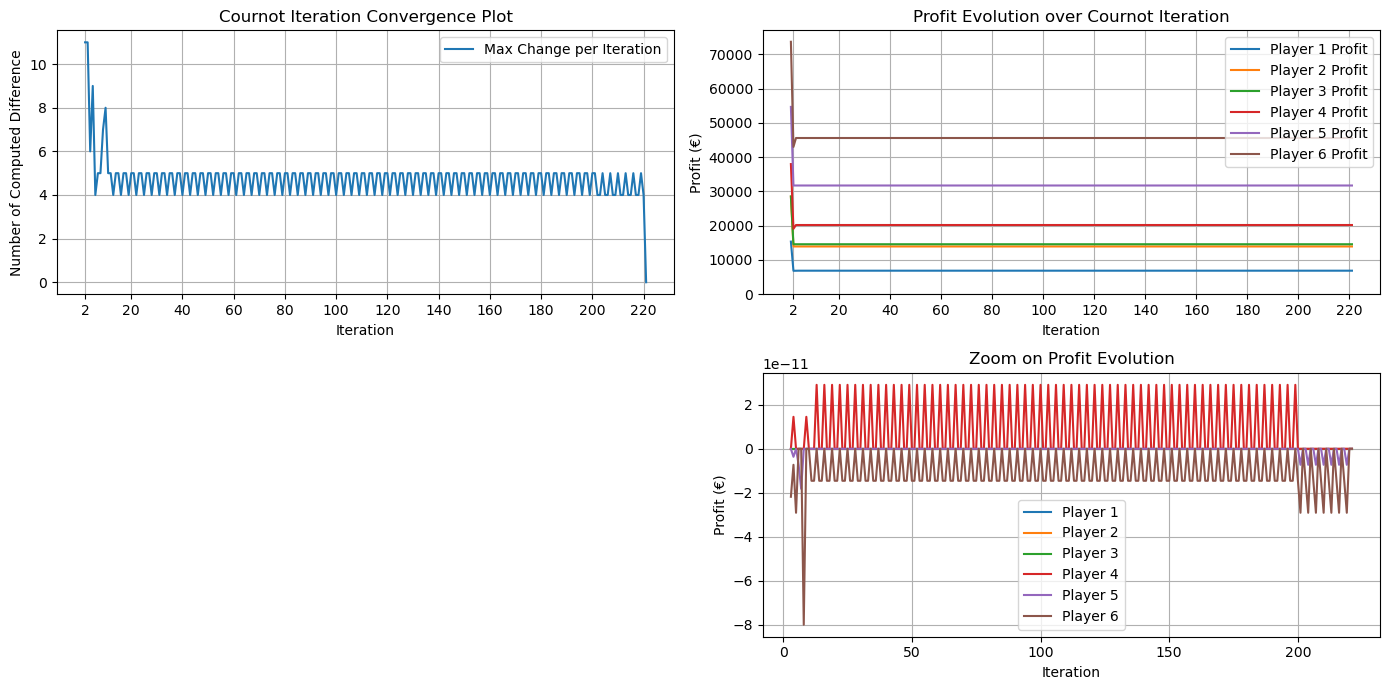

Running Summer - 8 players
  Player   OC   Eta   E_max   Q_max  \
0      A  0.5  0.85   570.0   288.0   
1      B  0.5  0.85   570.0   288.0   
2      C  0.5  0.85  1150.0   576.0   
3      D  0.5  0.85  1150.0   576.0   
4      E  0.5  0.85  1150.0   576.0   
5      F  0.5  0.85  1720.0   864.0   
6      G  0.5  0.85  2300.0  1152.0   
7      H  0.5  0.85  2880.0  1440.0   

                                             Q_steps  
0  [0.0, 28.8, 57.6, 86.4, 115.2, 144.0, 172.8, 2...  
1  [0.0, 28.8, 57.6, 86.4, 115.2, 144.0, 172.8, 2...  
2  [0.0, 57.6, 115.2, 172.8, 230.4, 288.0, 345.6,...  
3  [0.0, 57.6, 115.2, 172.8, 230.4, 288.0, 345.6,...  
4  [0.0, 57.6, 115.2, 172.8, 230.4, 288.0, 345.6,...  
5  [0.0, 86.4, 172.8, 259.2, 345.6, 432.0, 518.4,...  
6  [0.0, 115.2, 230.4, 345.6, 460.8, 576.0, 691.2...  
7  [0.0, 144.0, 288.0, 432.0, 576.0, 720.0, 864.0...  
Convergence has not been reached. Let's try again by fixing player A outputs.
Convergence has not been reached. Let's try agai

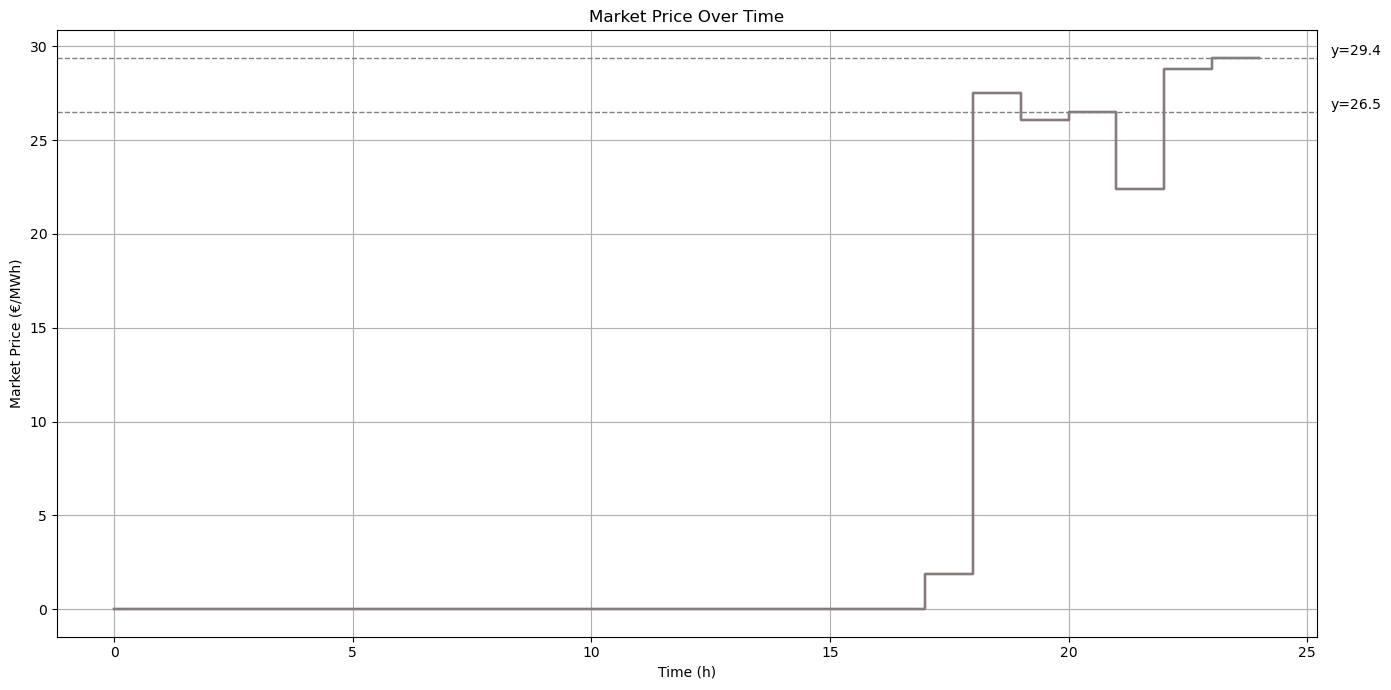

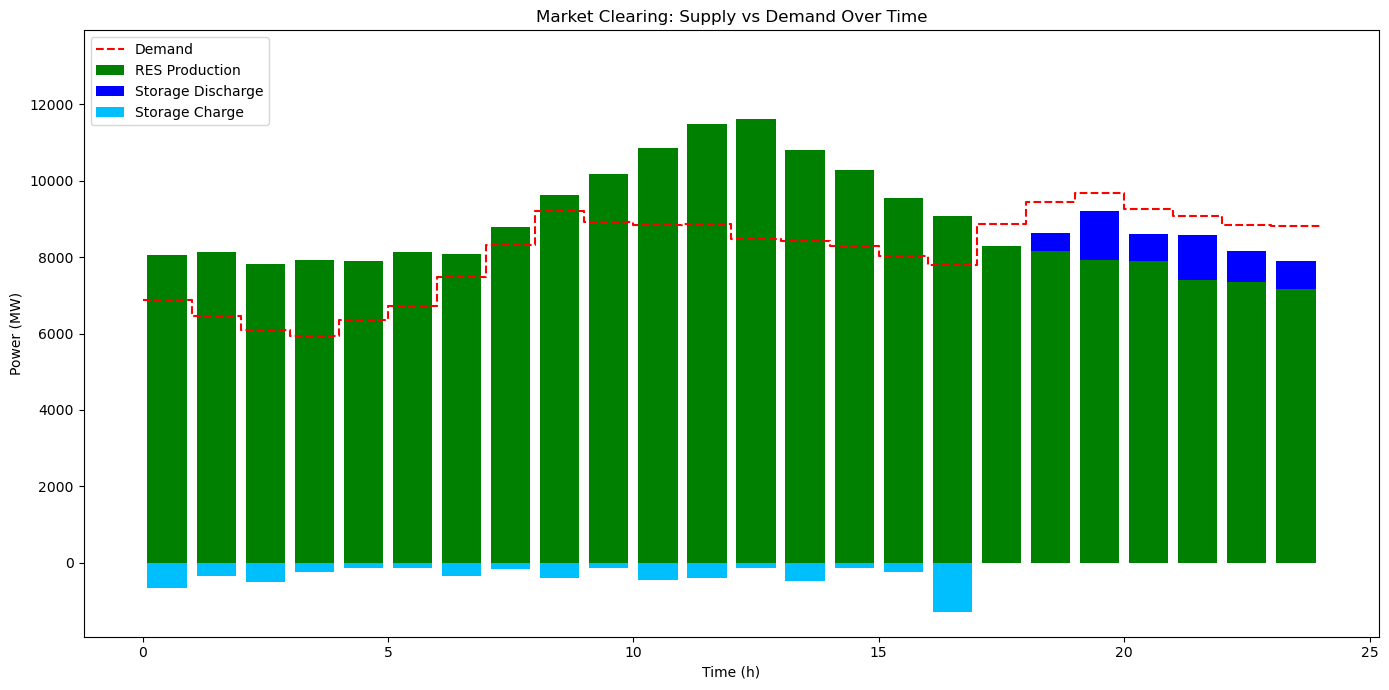

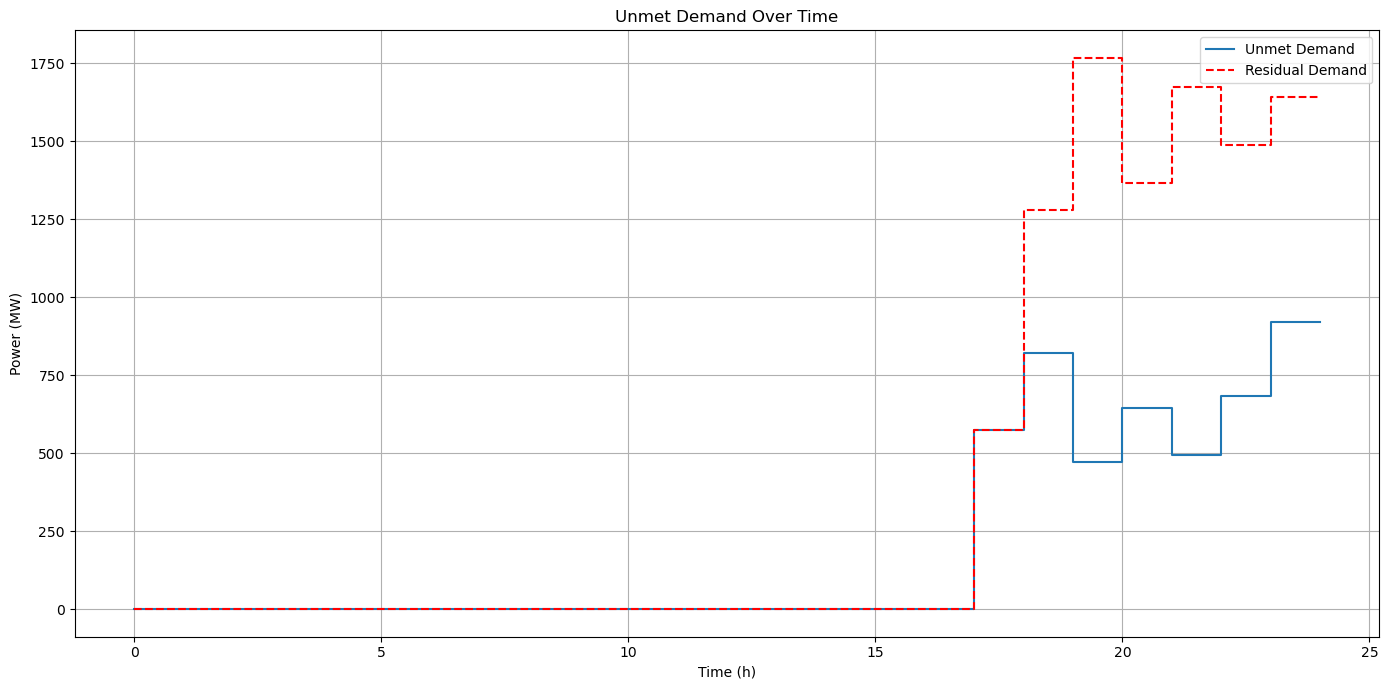

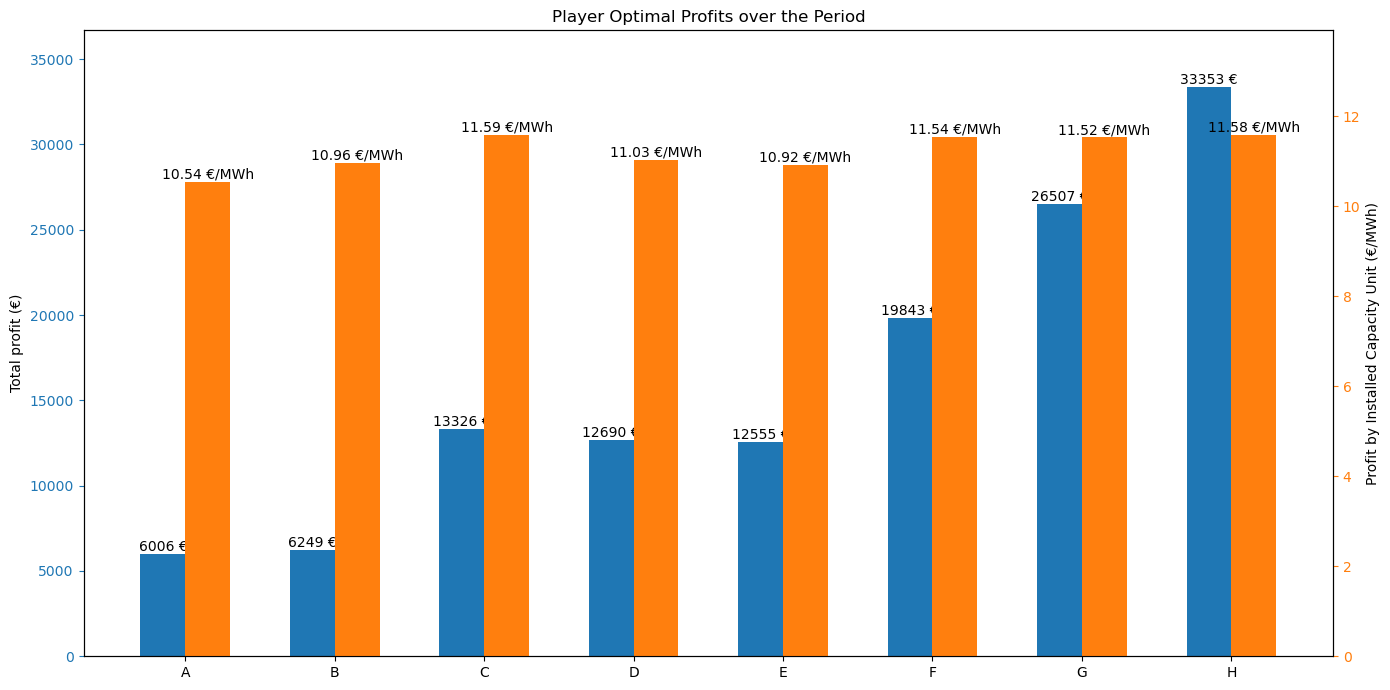

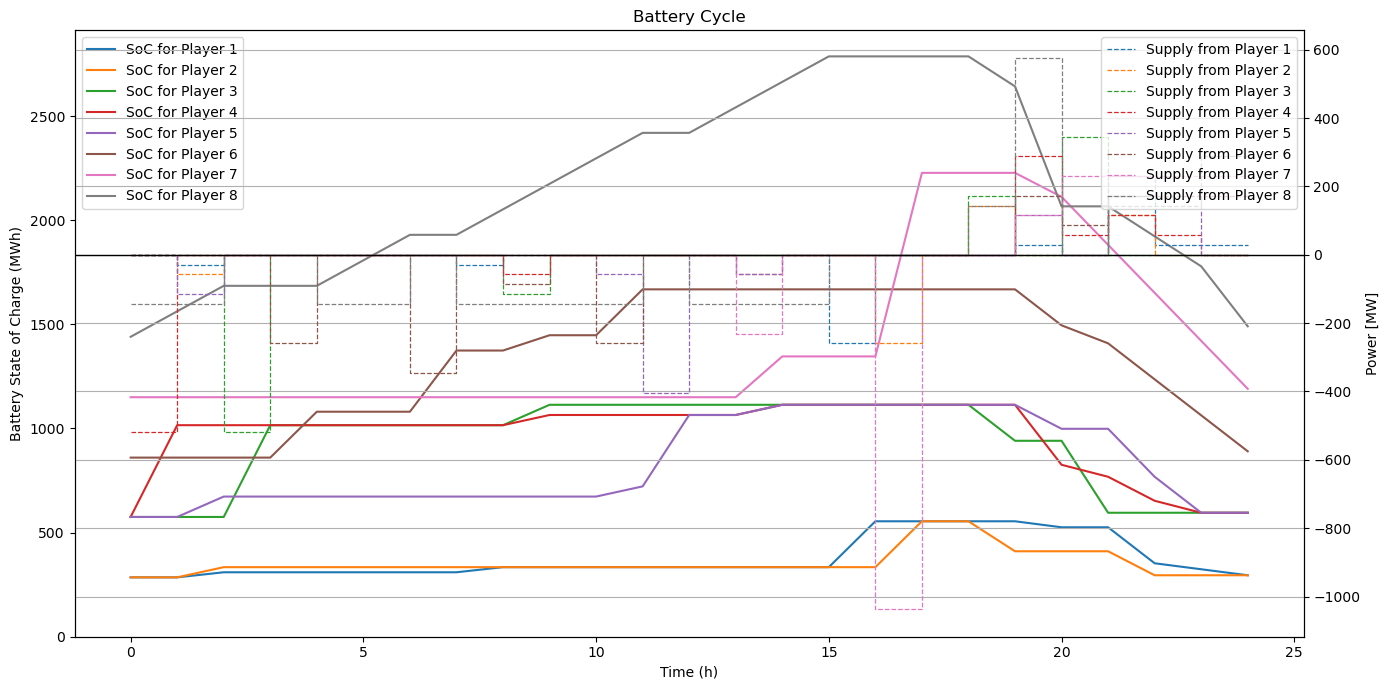

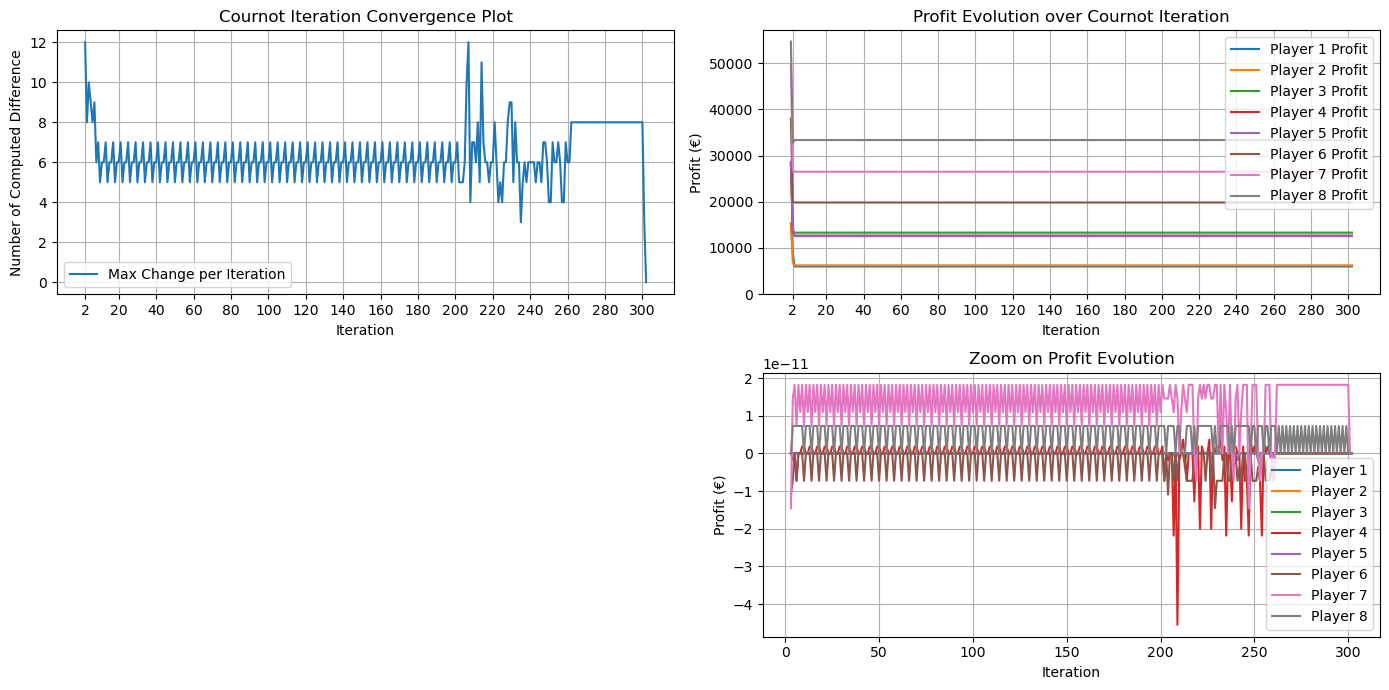

Running LowLoad - 1 players
  Player   OC   Eta   E_max   Q_max  \
0      A  0.5  0.85  9140.0  4571.0   

                                             Q_steps  
0  [0.0, 457.1, 914.2, 1371.3, 1828.4, 2285.5, 27...  


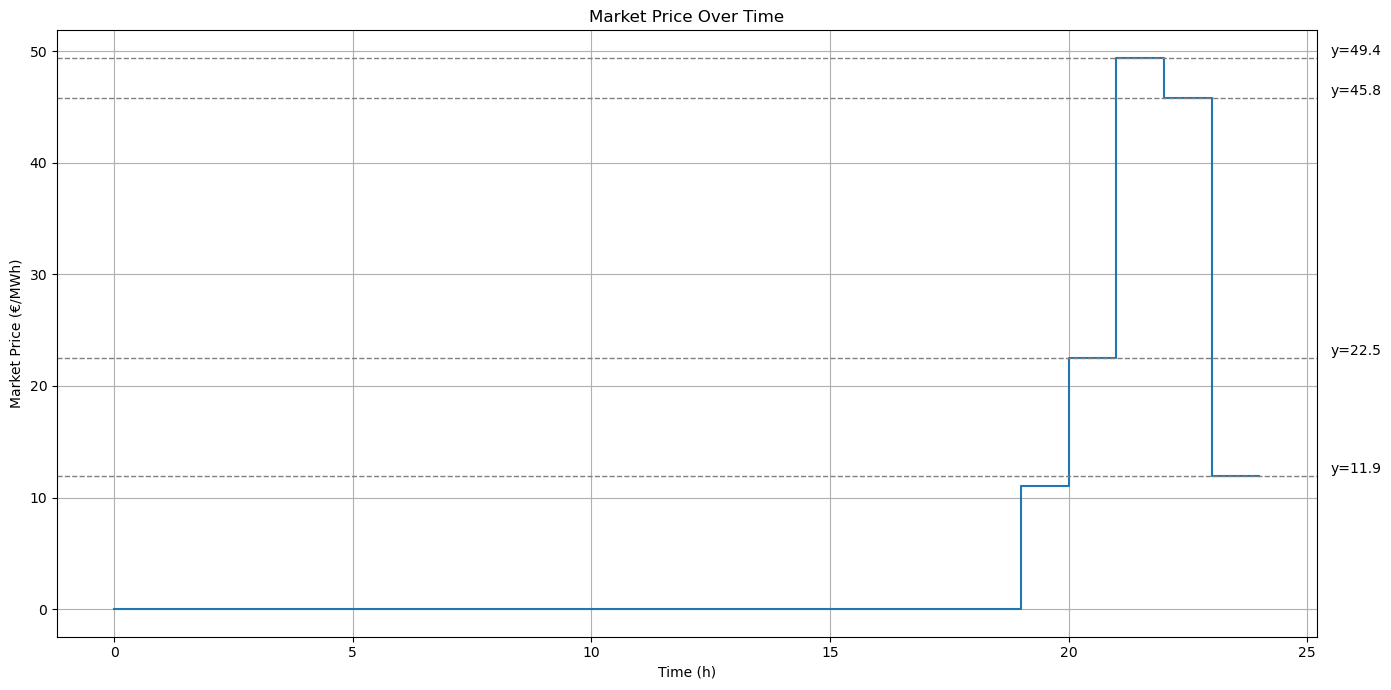

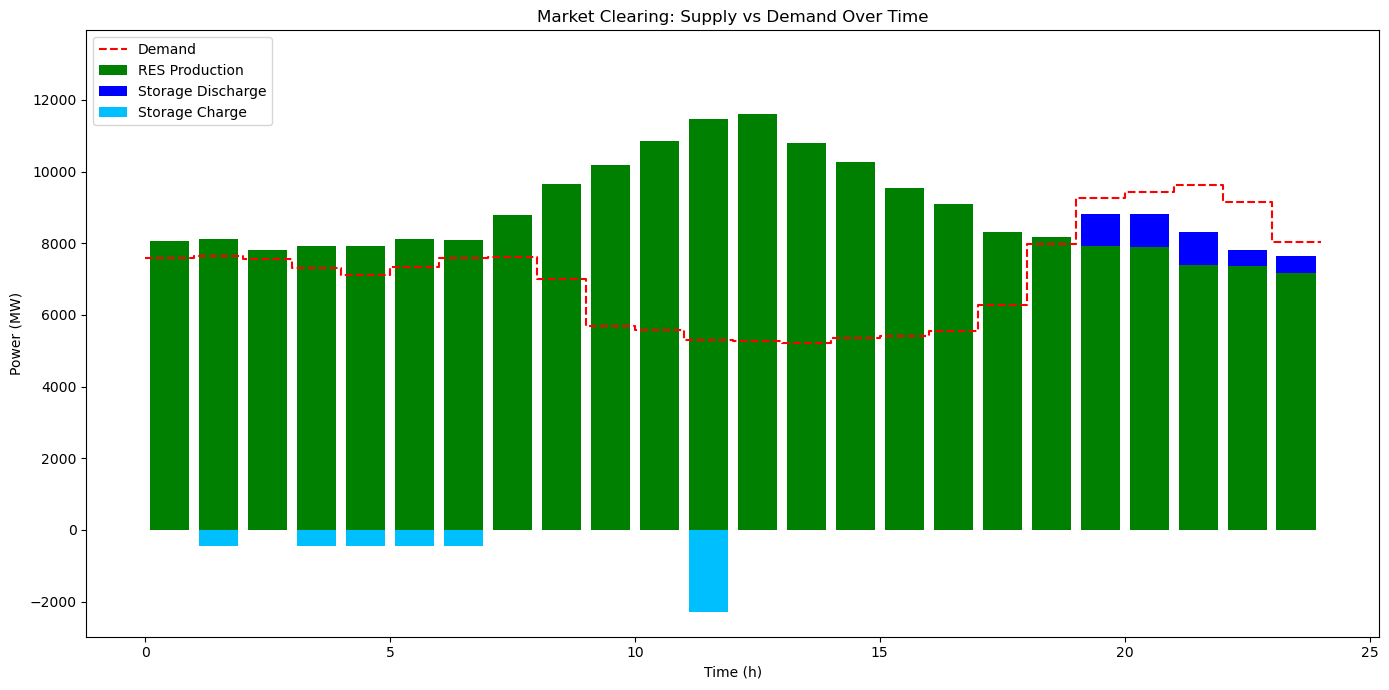

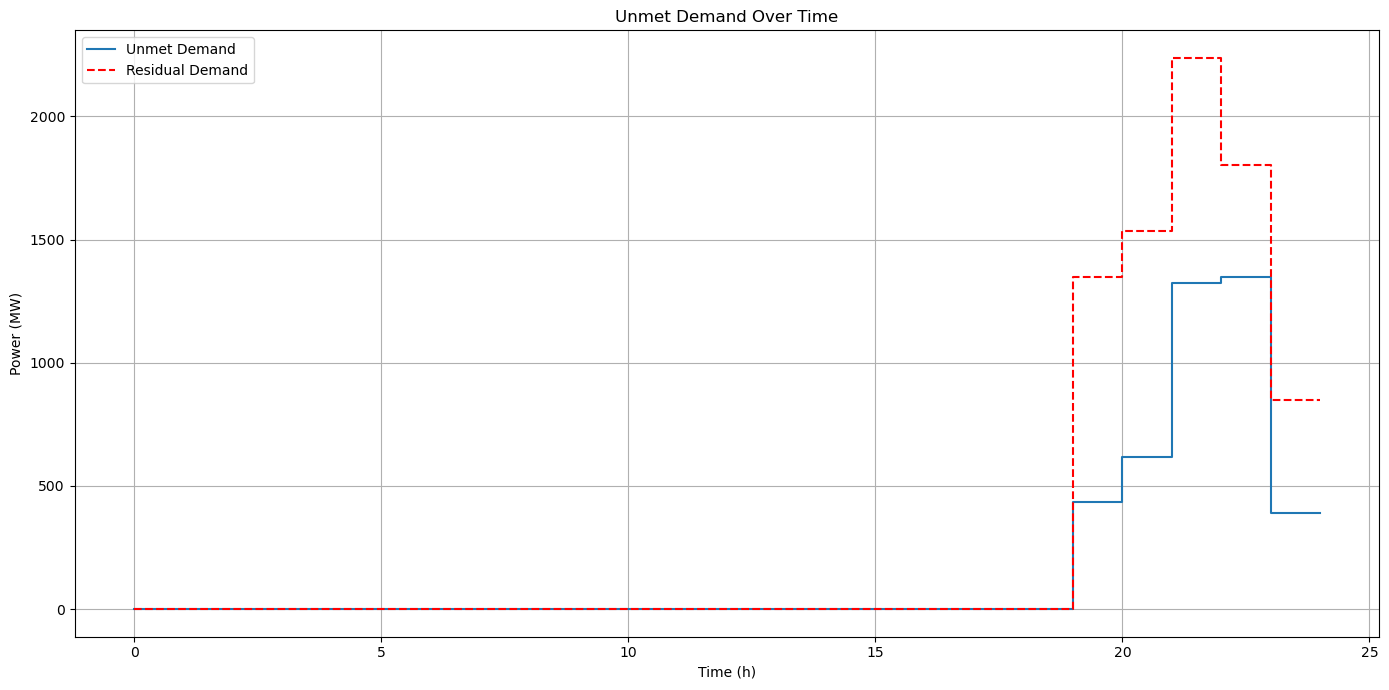

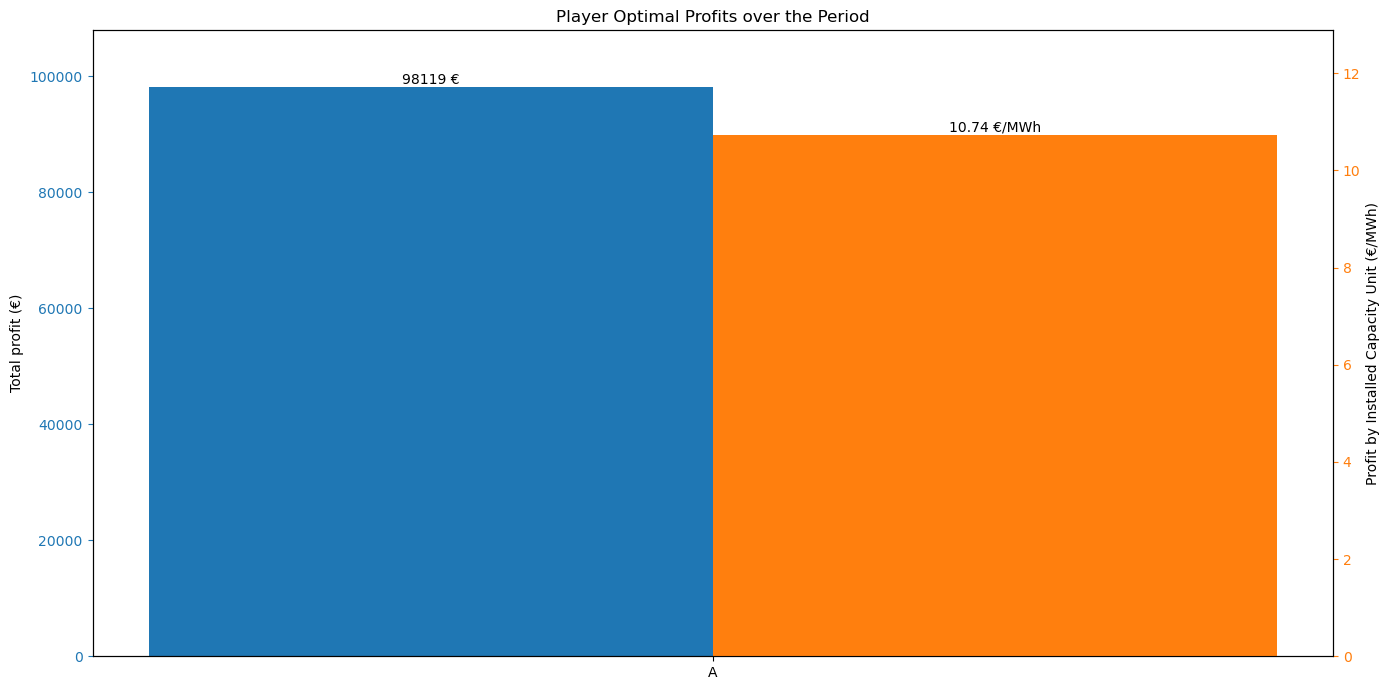

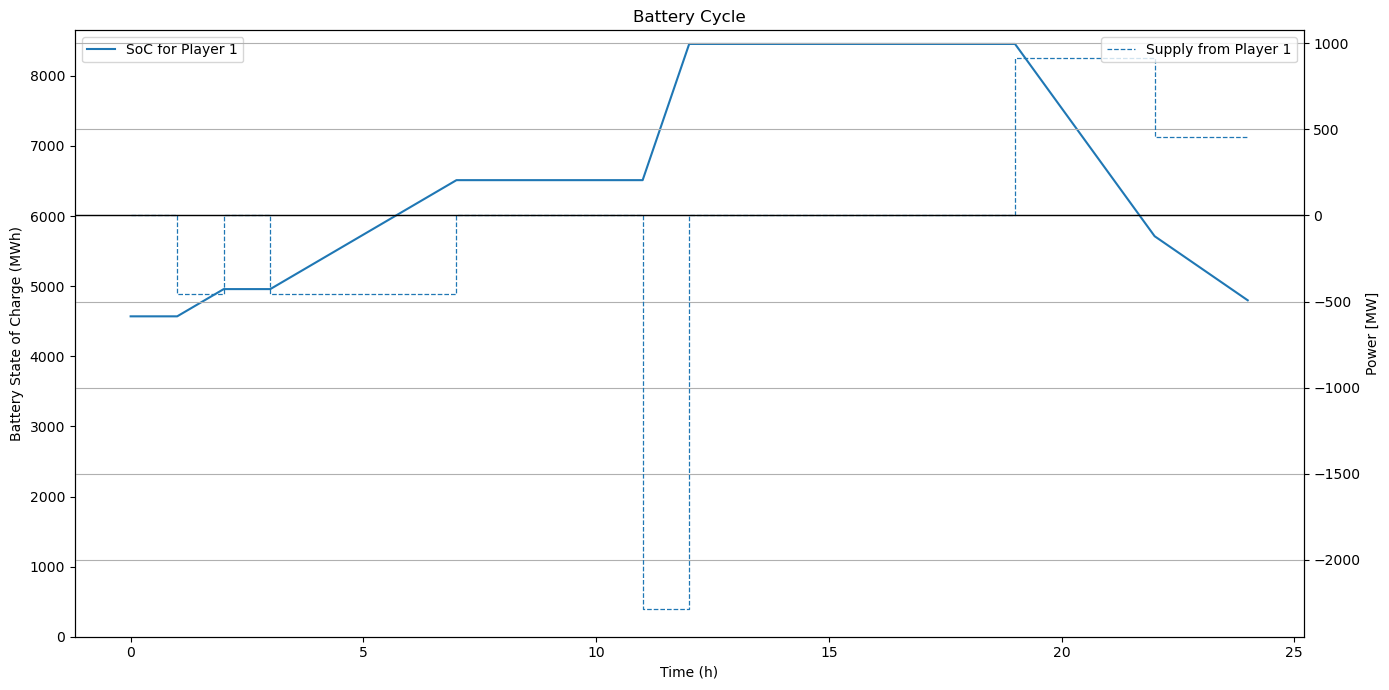

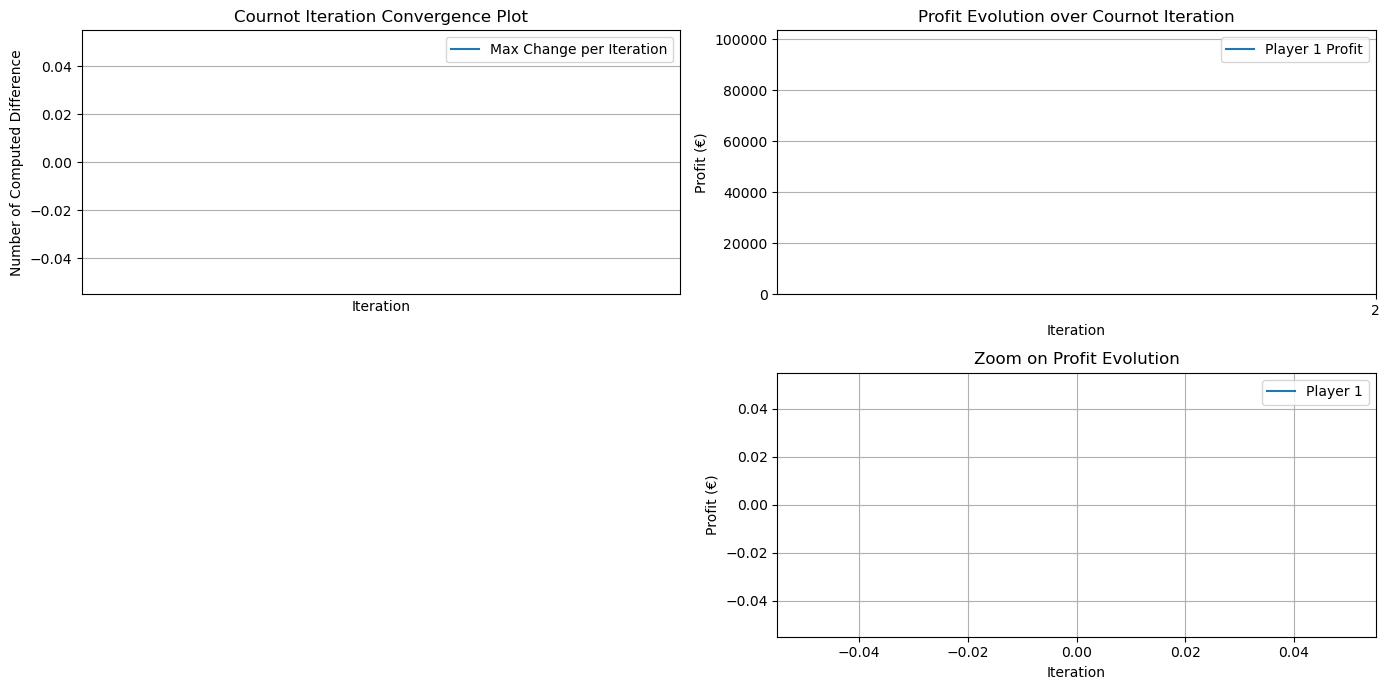

Running LowLoad - 2 players
  Player   OC   Eta   E_max   Q_max  \
0      A  0.5  0.85  3040.0  1523.0   
1      B  0.5  0.85  6090.0  3047.0   

                                             Q_steps  
0  [0.0, 152.3, 304.6, 456.9, 609.2, 761.5, 913.8...  
1  [0.0, 304.7, 609.4, 914.1, 1218.8, 1523.5, 182...  
Optimization was successful. It converged in 5 iterations.


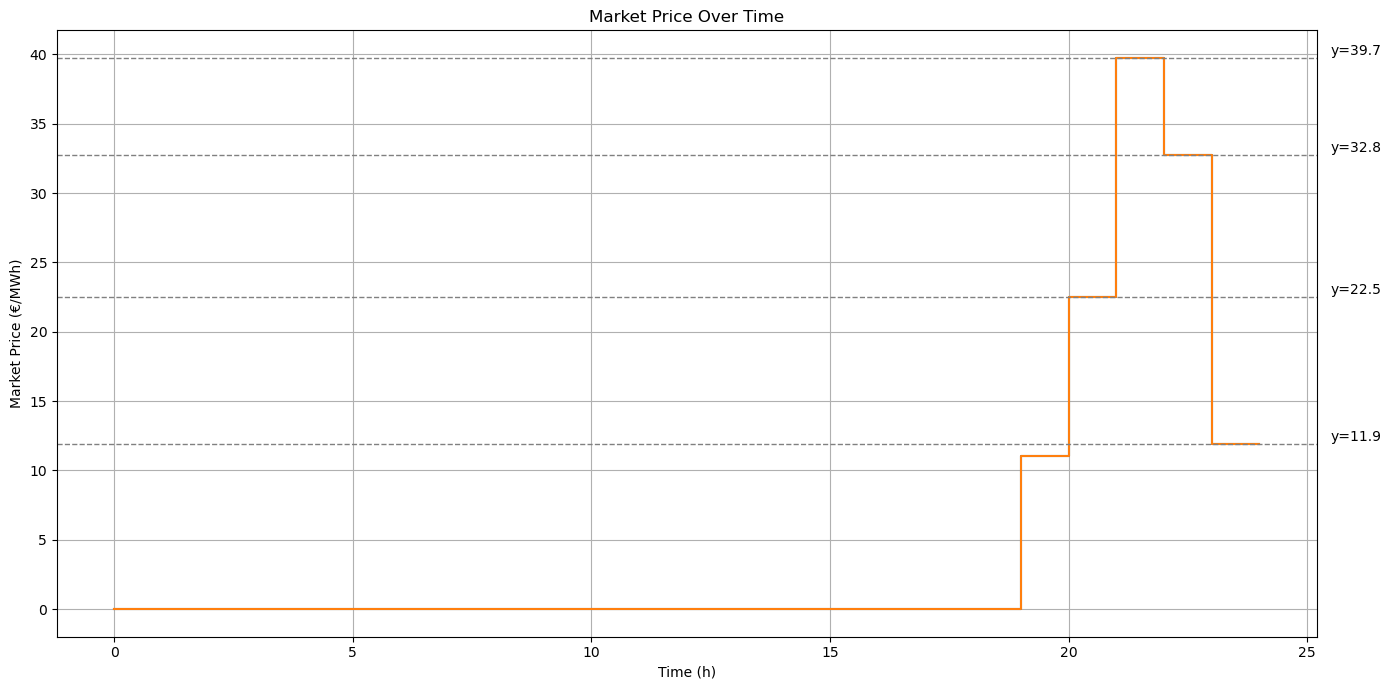

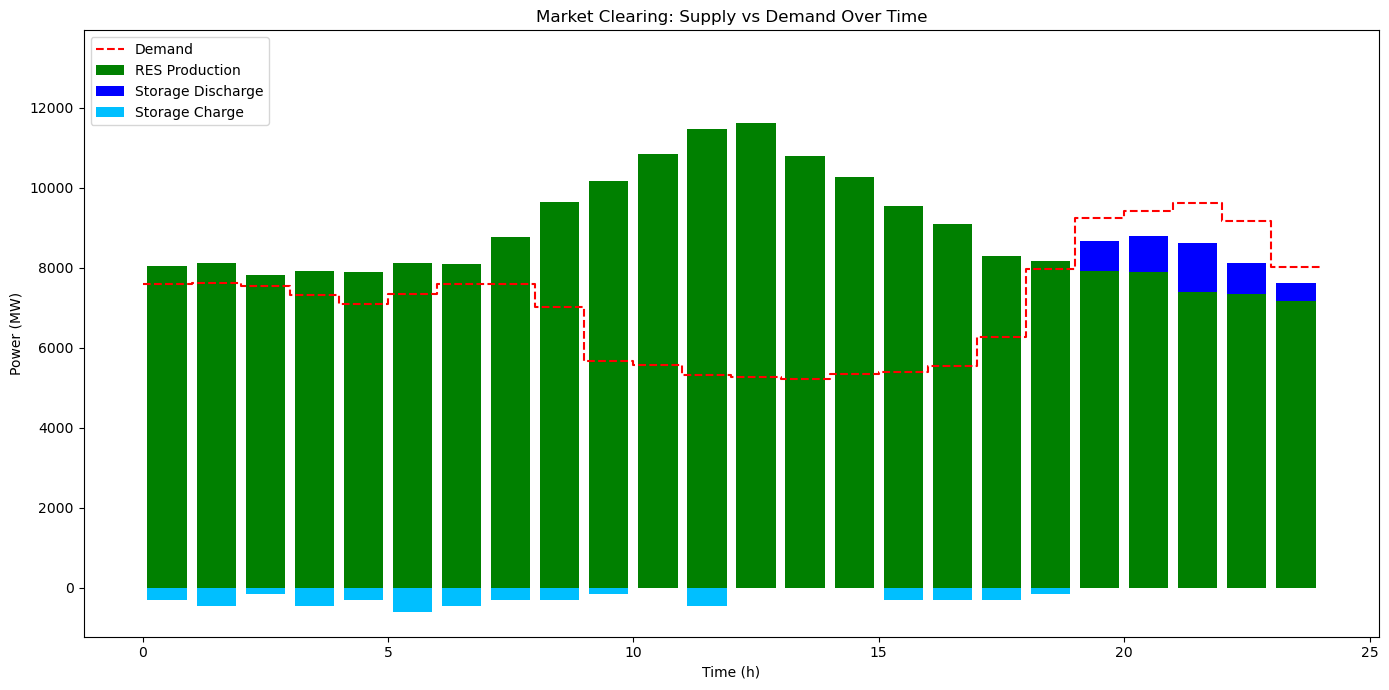

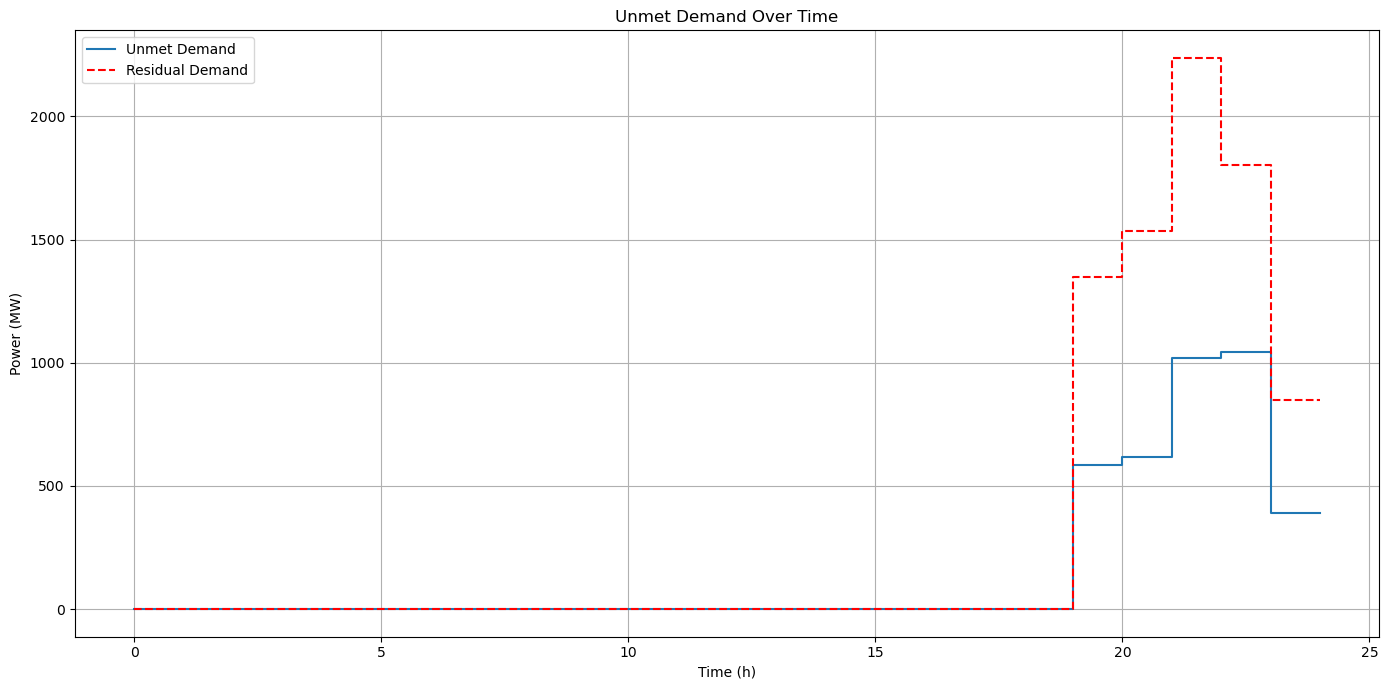

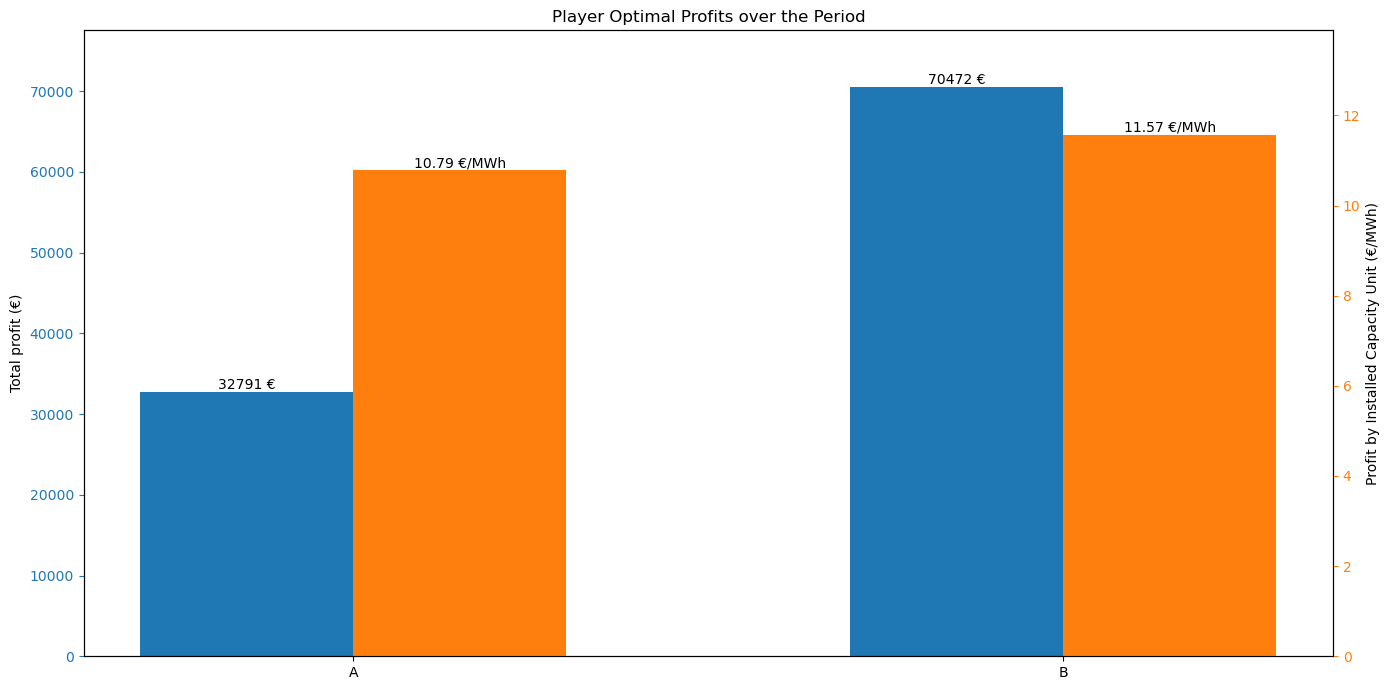

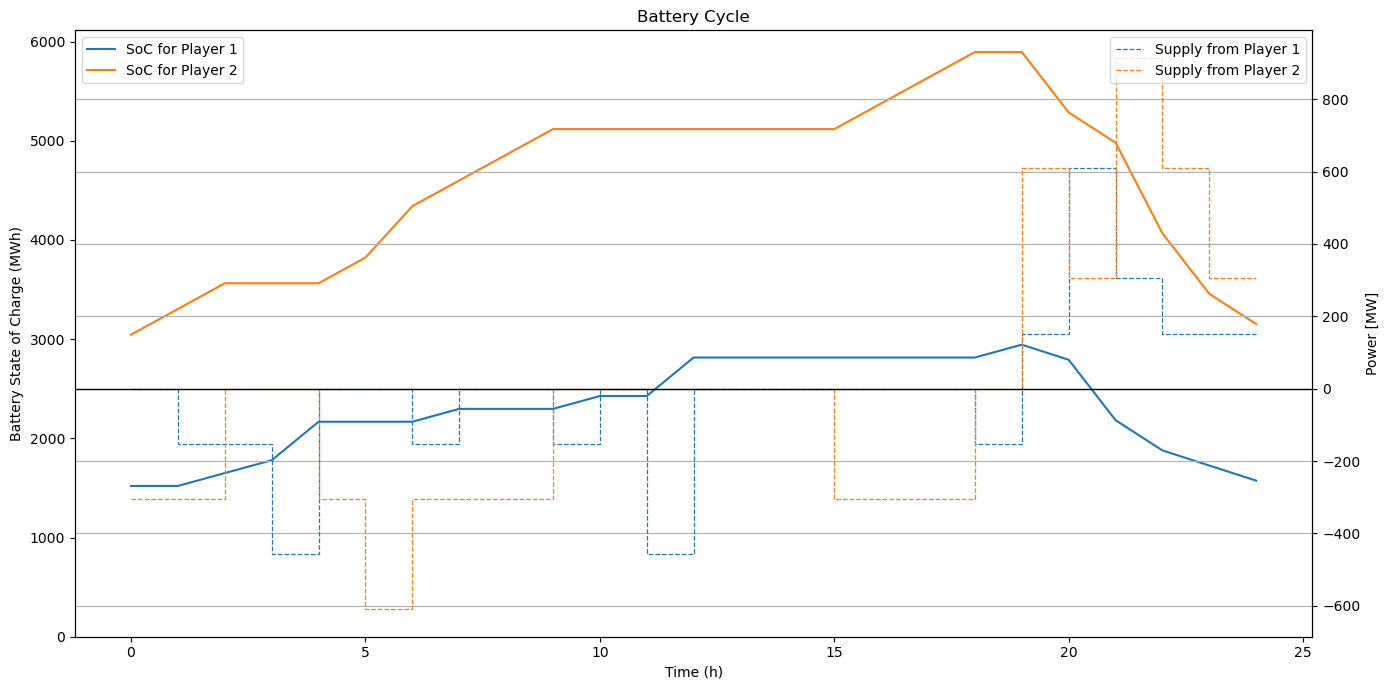

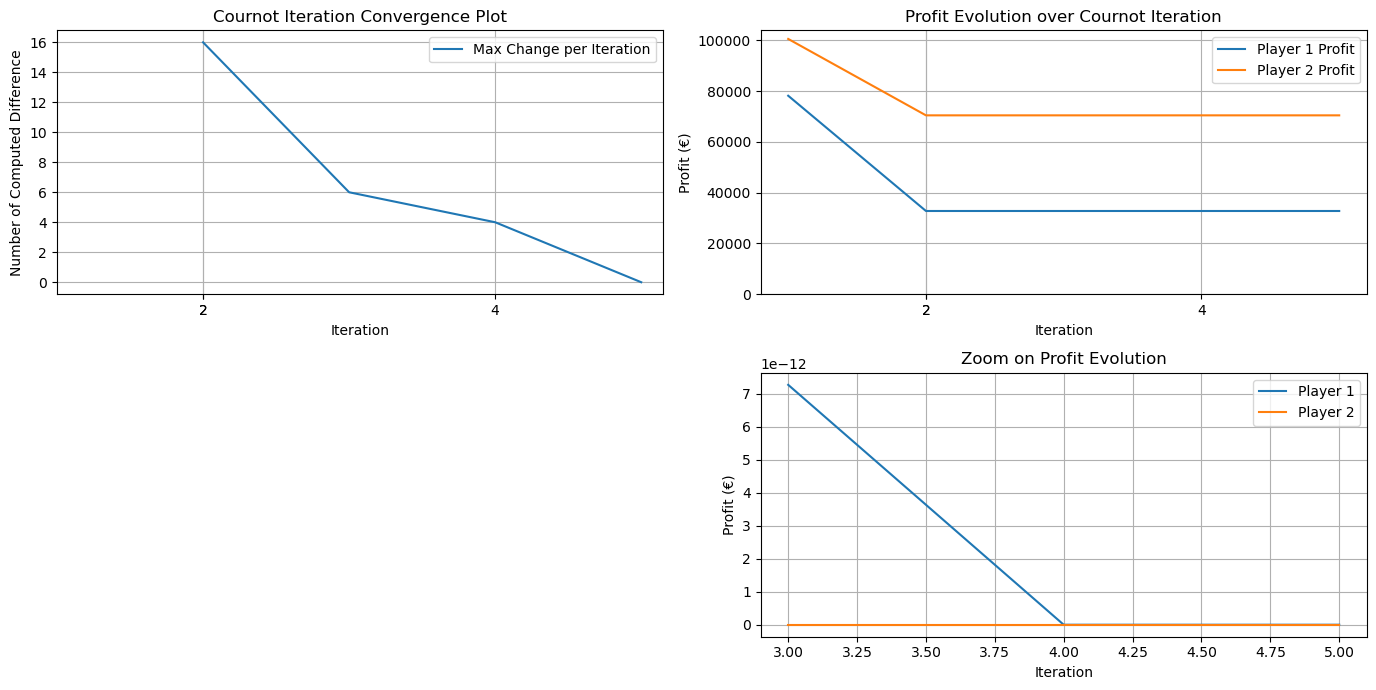

Running LowLoad - 4 players
  Player   OC   Eta   E_max   Q_max  \
0      A  0.5  0.85   910.0   457.0   
1      B  0.5  0.85  1820.0   914.0   
2      C  0.5  0.85  2740.0  1371.0   
3      D  0.5  0.85  3650.0  1828.0   

                                             Q_steps  
0  [0.0, 45.7, 91.4, 137.1, 182.8, 228.5, 274.2, ...  
1  [0.0, 91.4, 182.8, 274.2, 365.6, 457.0, 548.4,...  
2  [0.0, 137.1, 274.2, 411.3, 548.4, 685.5, 822.6...  
3  [0.0, 182.8, 365.6, 548.4, 731.2, 914.0, 1096....  
Convergence has not been reached. Let's try again by fixing player A outputs.
Convergence has not been reached. Let's try again by fixing player B outputs.
Optimization was successful. It converged in 221 iterations.


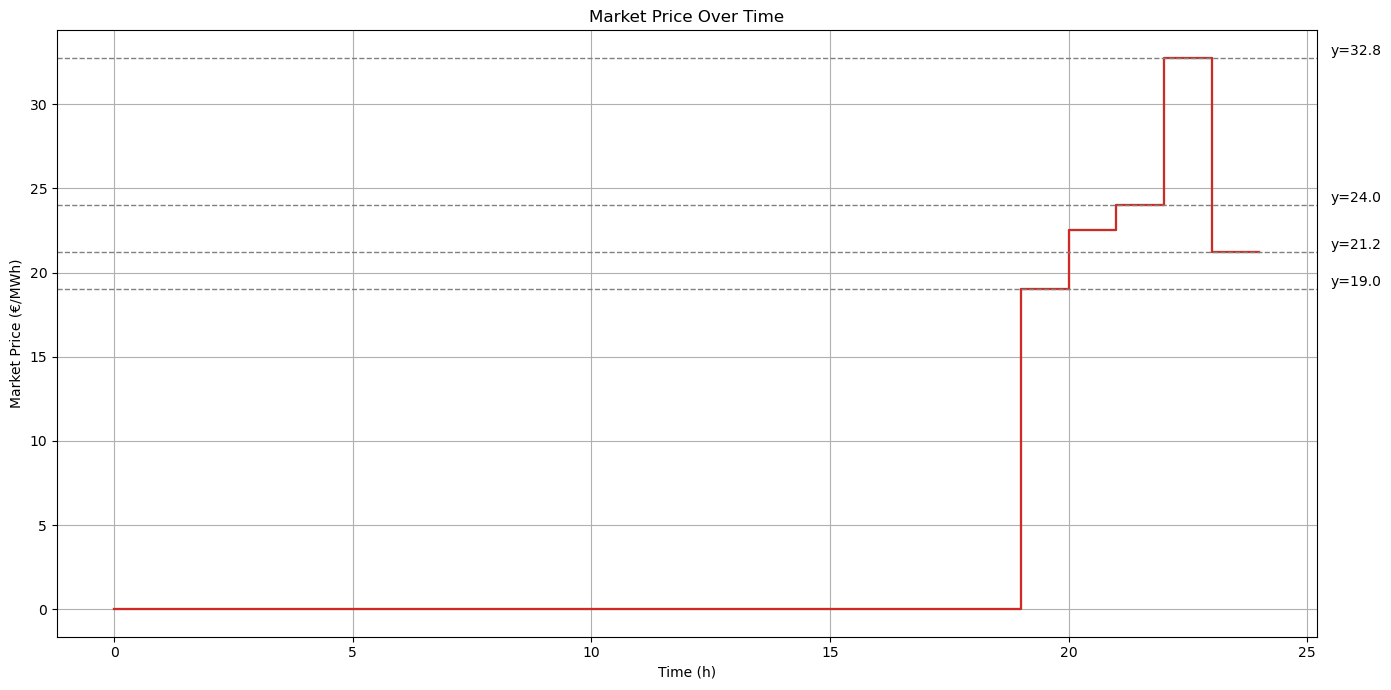

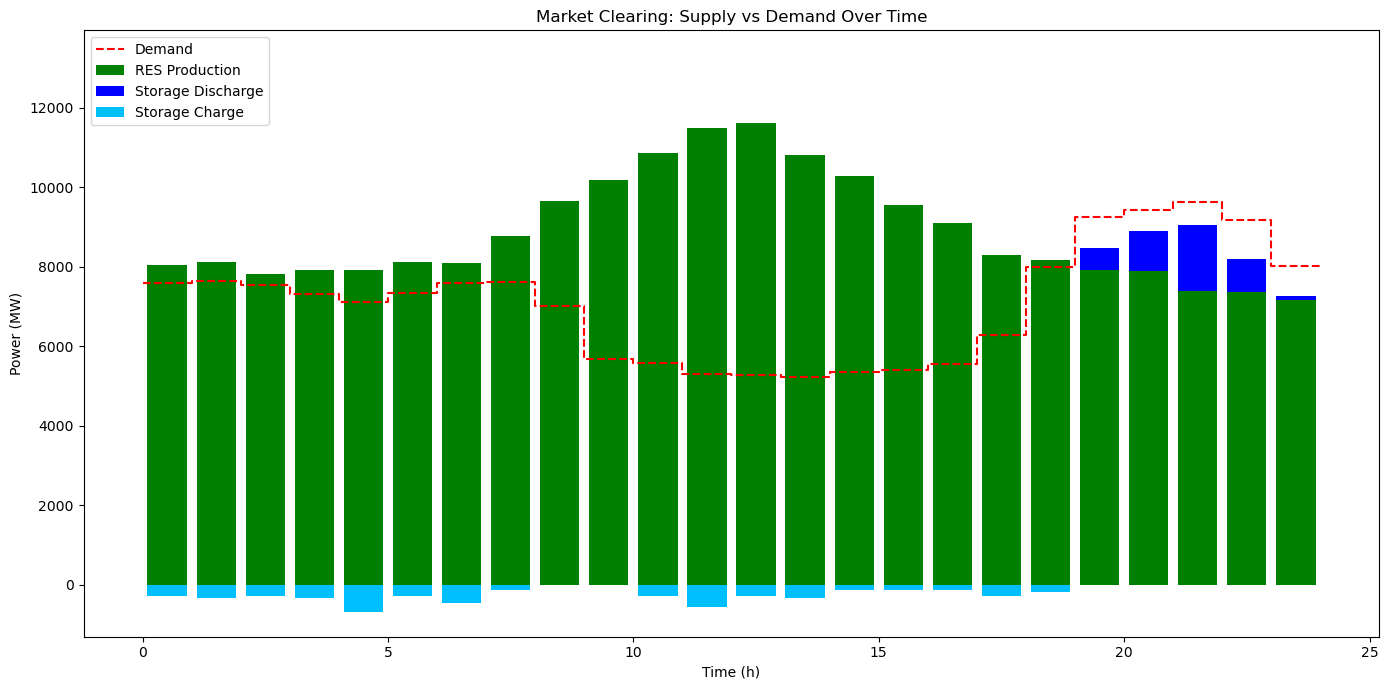

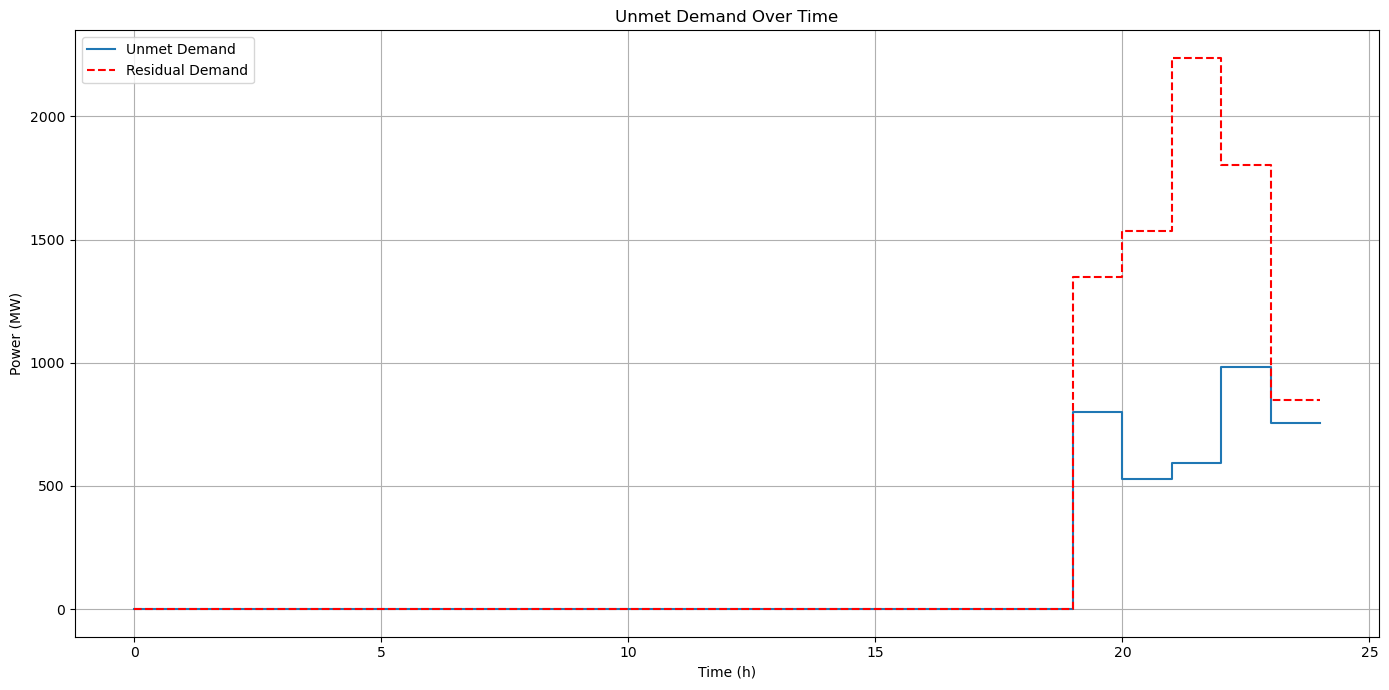

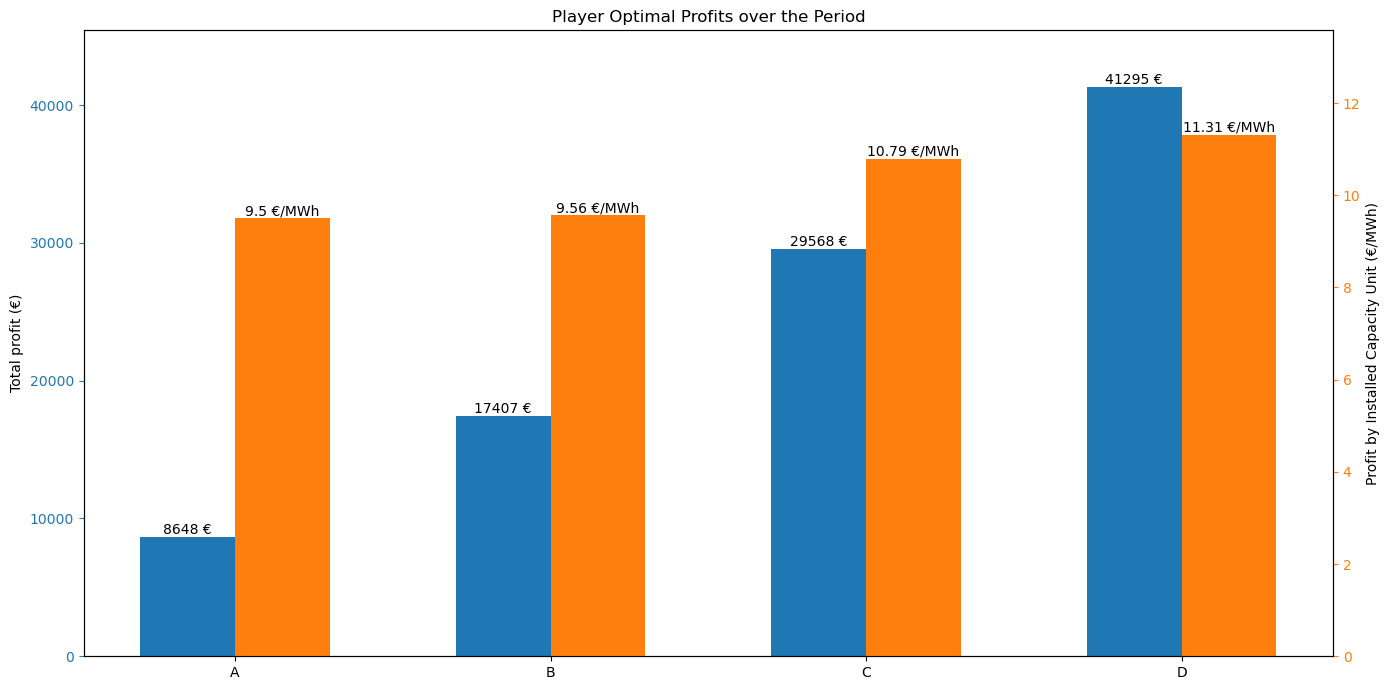

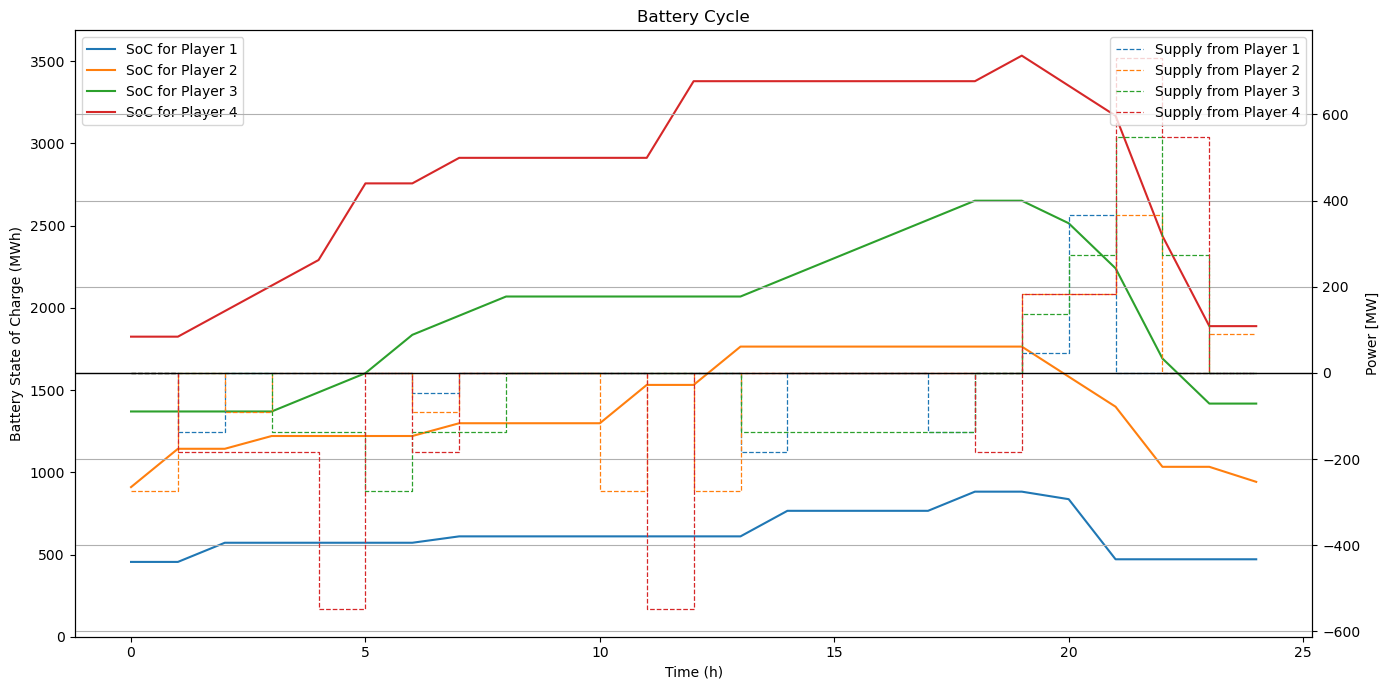

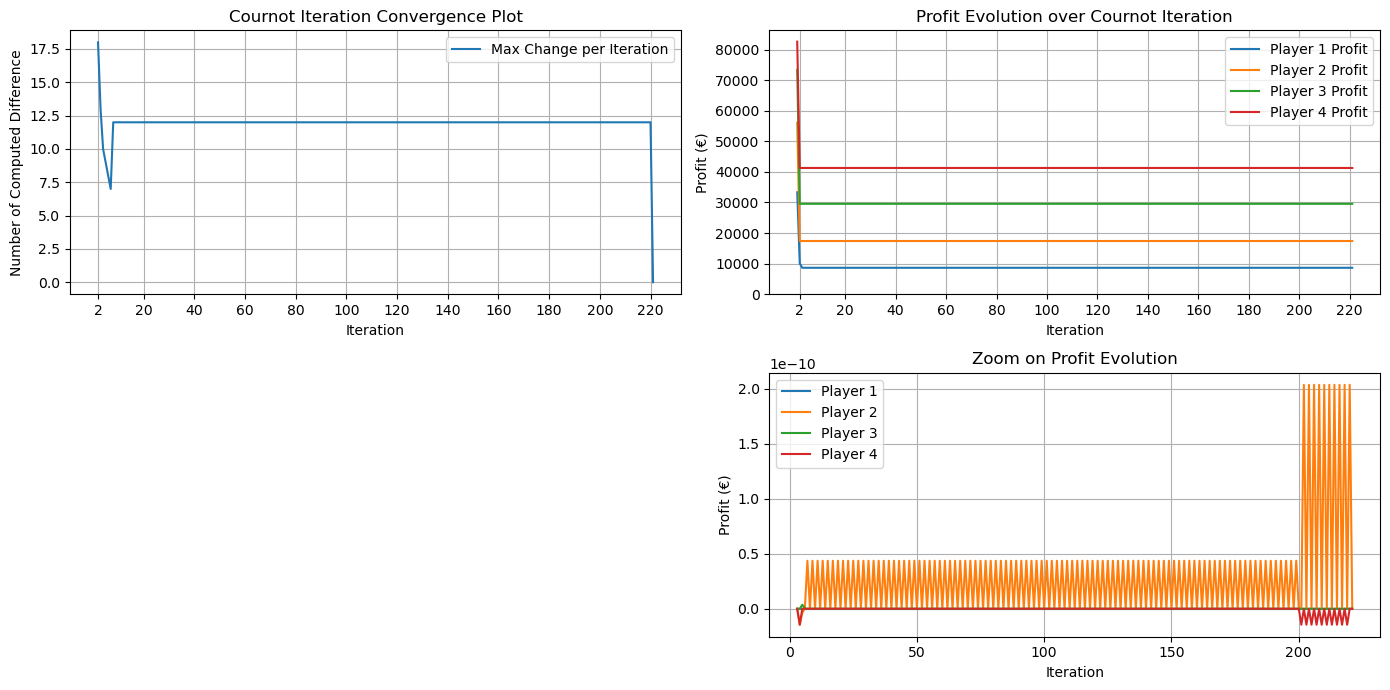

Running LowLoad - 6 players
  Player   OC   Eta   E_max   Q_max  \
0      A  0.5  0.85   450.0   228.0   
1      B  0.5  0.85   910.0   457.0   
2      C  0.5  0.85   910.0   457.0   
3      D  0.5  0.85  1370.0   685.0   
4      E  0.5  0.85  2280.0  1142.0   
5      F  0.5  0.85  3190.0  1599.0   

                                             Q_steps  
0  [0.0, 22.8, 45.6, 68.4, 91.2, 114.0, 136.8, 15...  
1  [0.0, 45.7, 91.4, 137.1, 182.8, 228.5, 274.2, ...  
2  [0.0, 45.7, 91.4, 137.1, 182.8, 228.5, 274.2, ...  
3  [0.0, 68.5, 137.0, 205.5, 274.0, 342.5, 411.0,...  
4  [0.0, 114.2, 228.4, 342.6, 456.8, 571.0, 685.2...  
5  [0.0, 159.9, 319.8, 479.7, 639.6, 799.5, 959.4...  
Convergence has not been reached. Let's try again by fixing player A outputs.
Convergence has not been reached. Let's try again by fixing player B outputs.
Convergence has not been reached. Let's try again by fixing player C outputs.
Optimization was successful. It converged in 244 iterations.


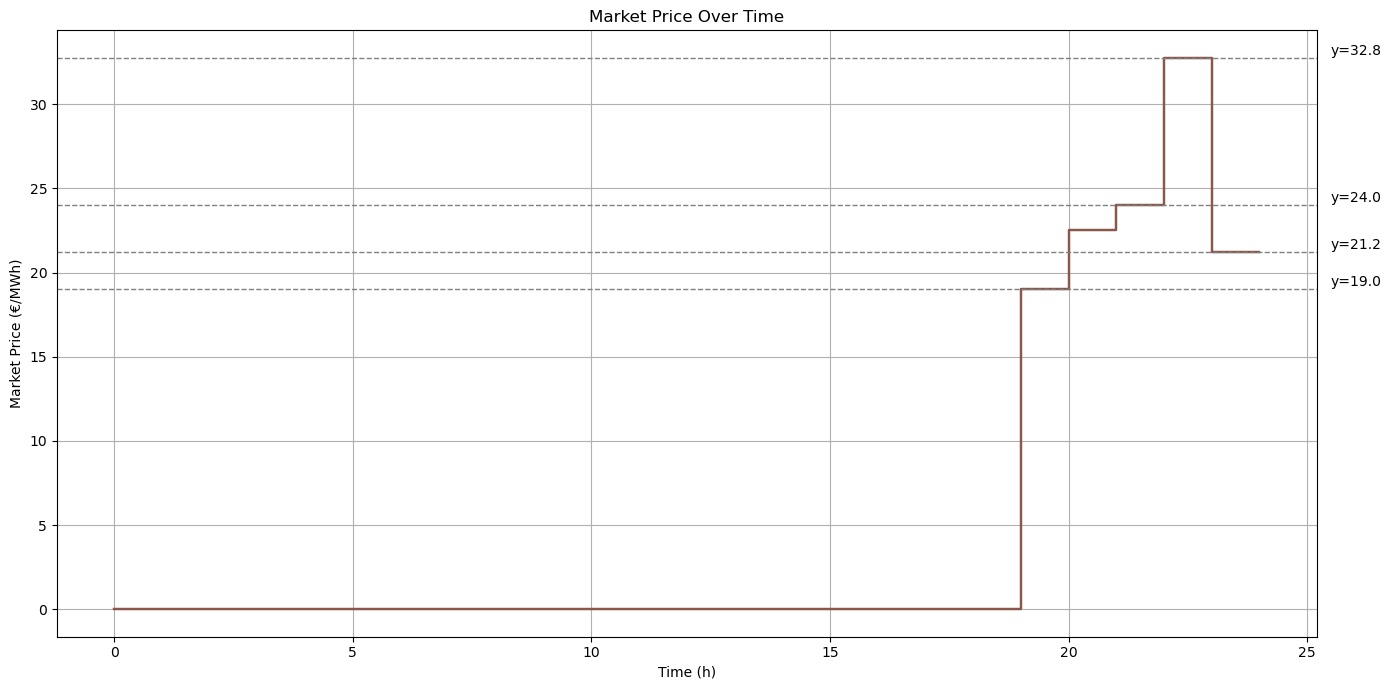

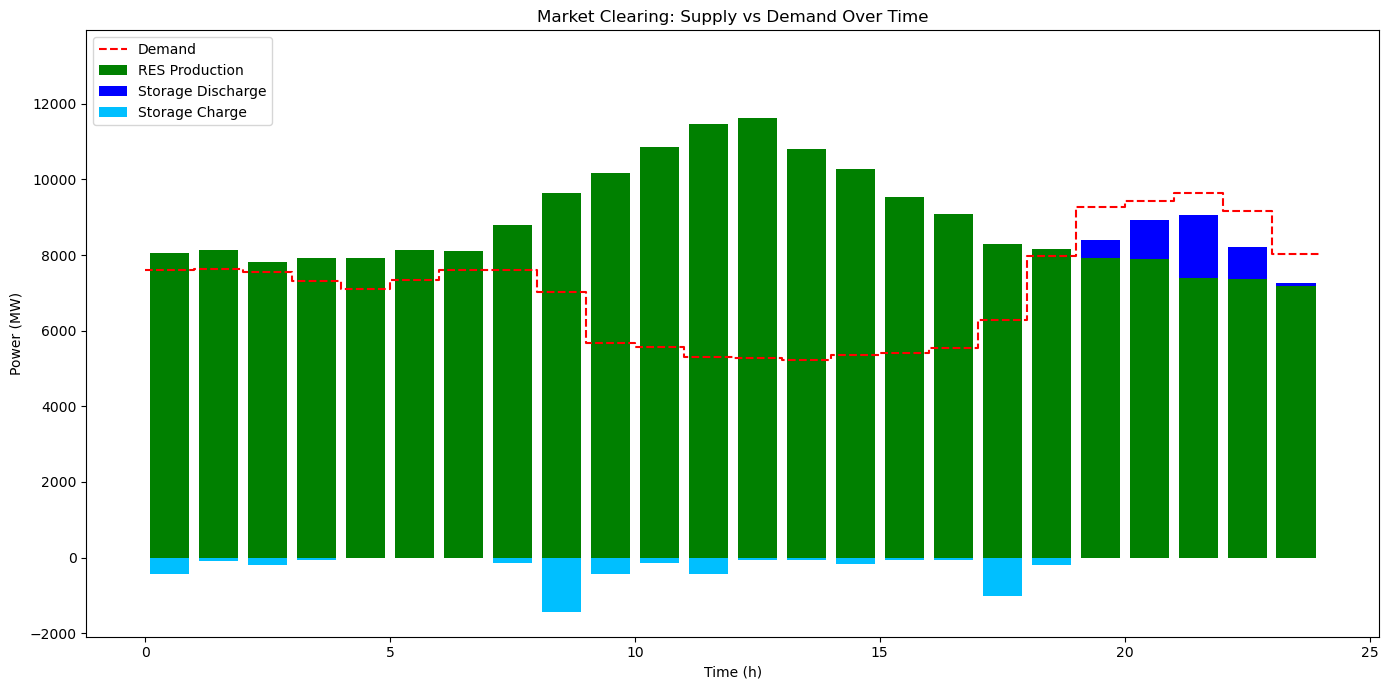

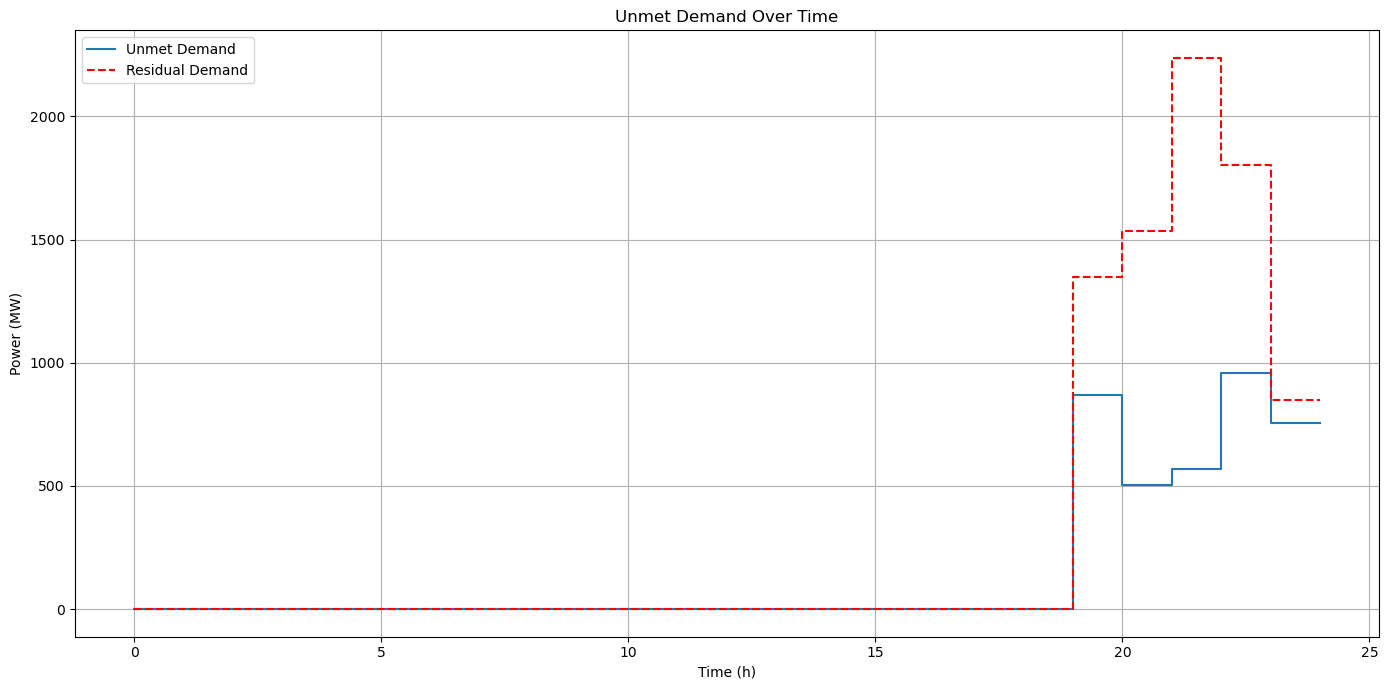

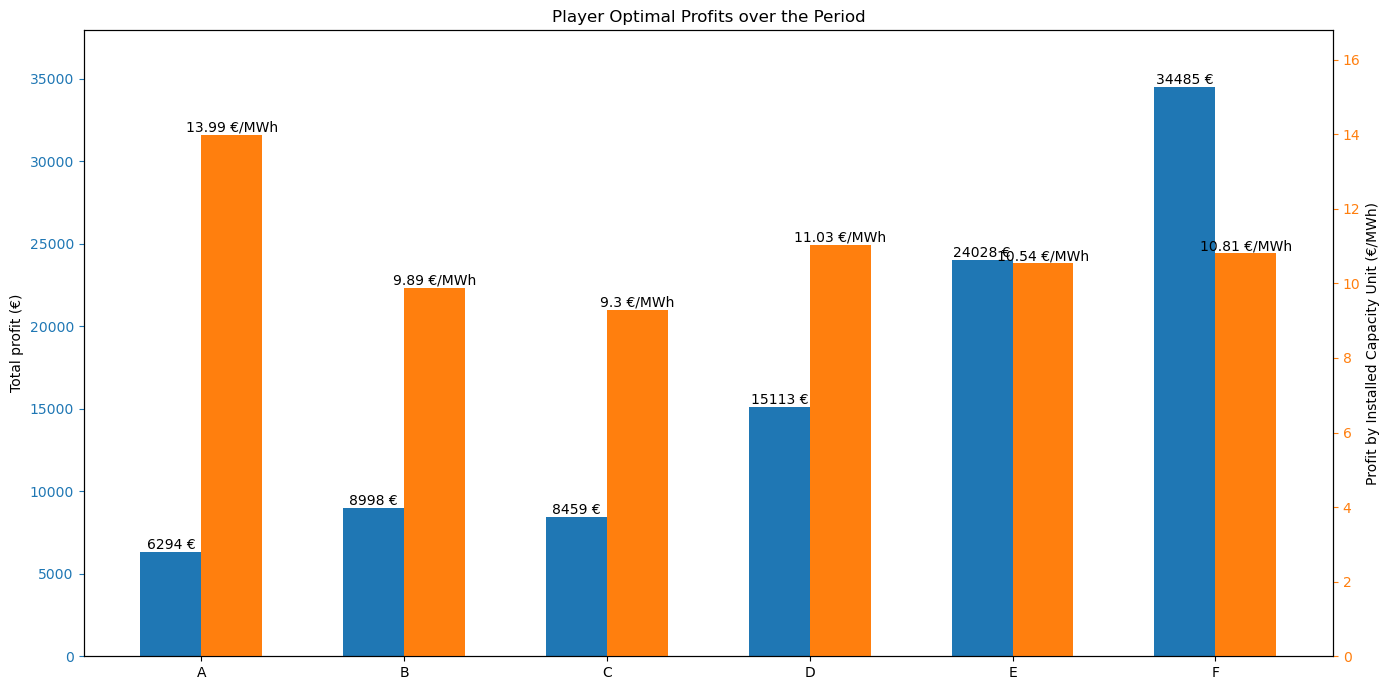

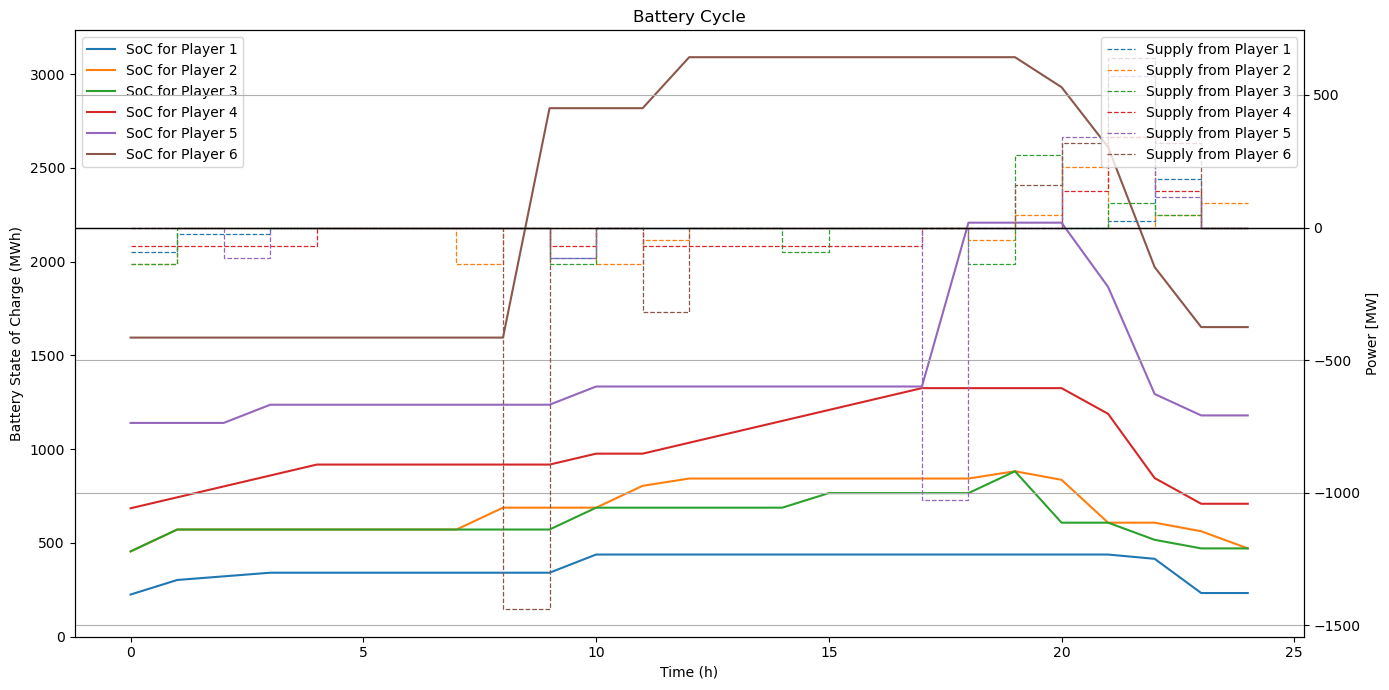

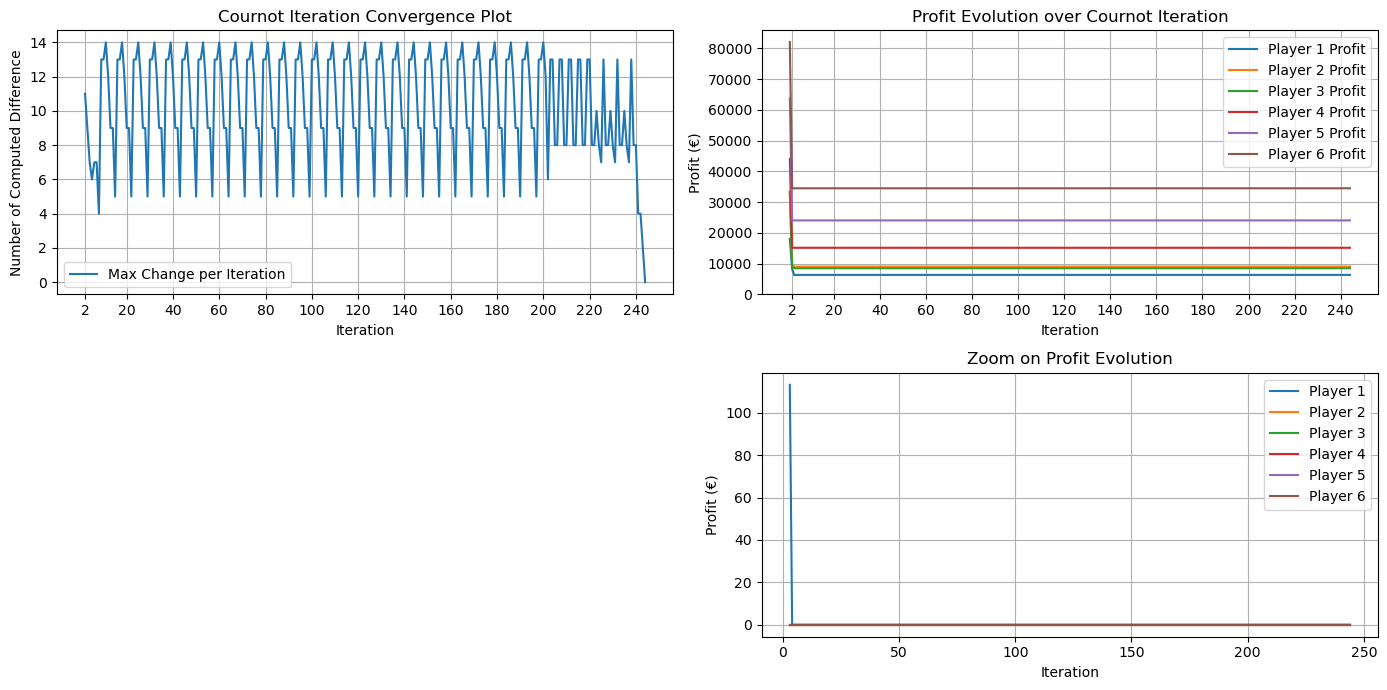

Running LowLoad - 8 players
  Player   OC   Eta   E_max   Q_max  \
0      A  0.5  0.85   450.0   228.0   
1      B  0.5  0.85   450.0   228.0   
2      C  0.5  0.85   910.0   457.0   
3      D  0.5  0.85   910.0   457.0   
4      E  0.5  0.85   910.0   457.0   
5      F  0.5  0.85  1370.0   685.0   
6      G  0.5  0.85  1820.0   914.0   
7      H  0.5  0.85  2280.0  1142.0   

                                             Q_steps  
0  [0.0, 22.8, 45.6, 68.4, 91.2, 114.0, 136.8, 15...  
1  [0.0, 22.8, 45.6, 68.4, 91.2, 114.0, 136.8, 15...  
2  [0.0, 45.7, 91.4, 137.1, 182.8, 228.5, 274.2, ...  
3  [0.0, 45.7, 91.4, 137.1, 182.8, 228.5, 274.2, ...  
4  [0.0, 45.7, 91.4, 137.1, 182.8, 228.5, 274.2, ...  
5  [0.0, 68.5, 137.0, 205.5, 274.0, 342.5, 411.0,...  
6  [0.0, 91.4, 182.8, 274.2, 365.6, 457.0, 548.4,...  
7  [0.0, 114.2, 228.4, 342.6, 456.8, 571.0, 685.2...  
Optimization was successful. It converged in 21 iterations.


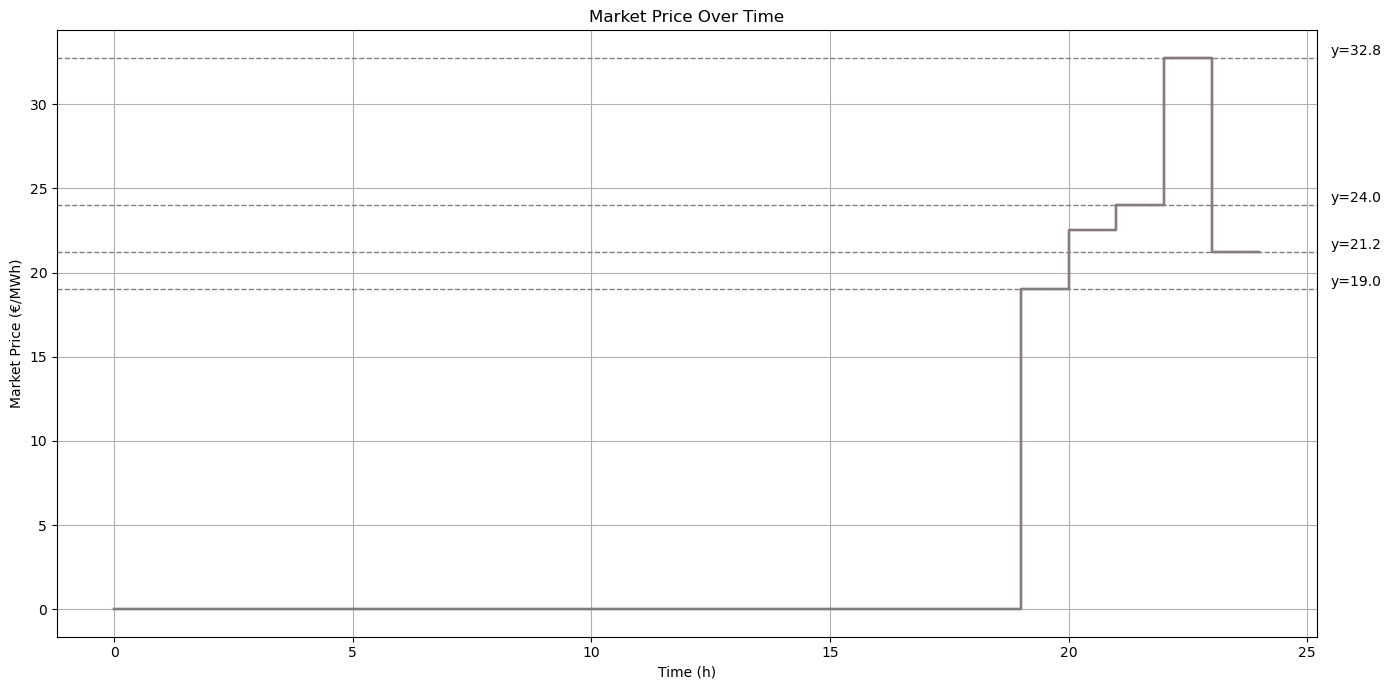

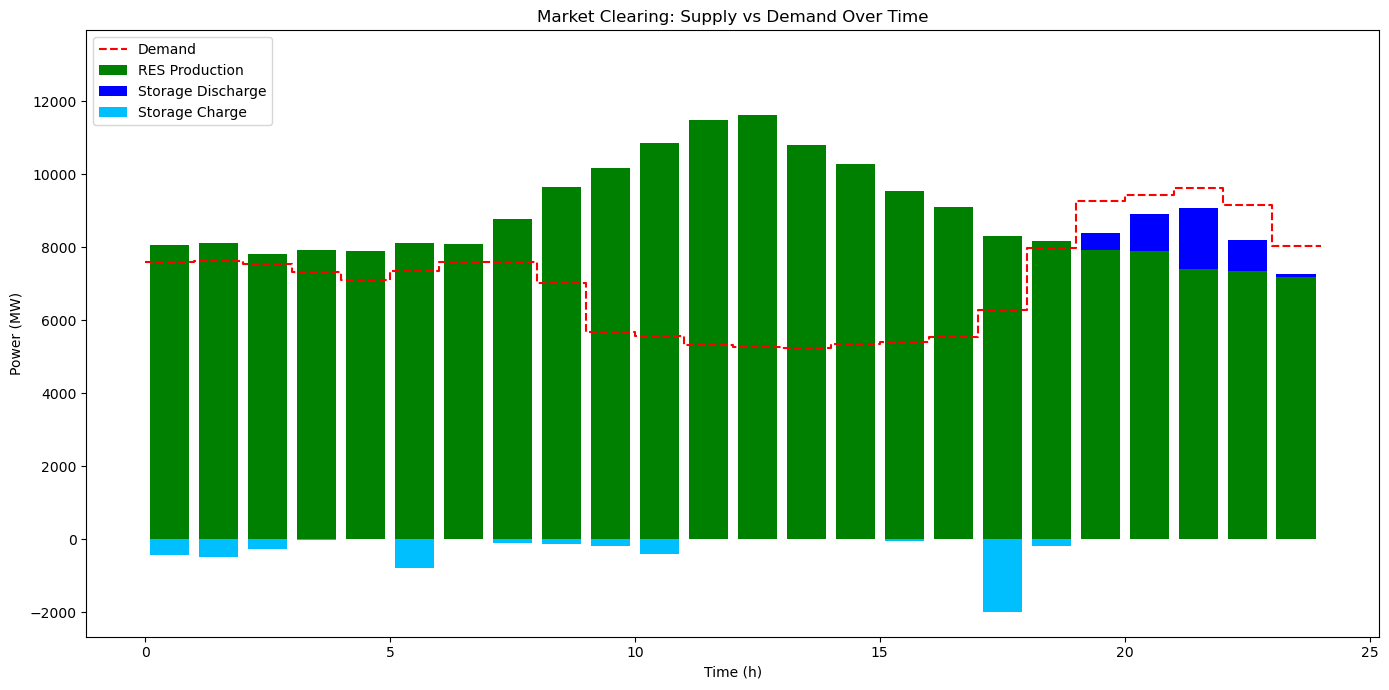

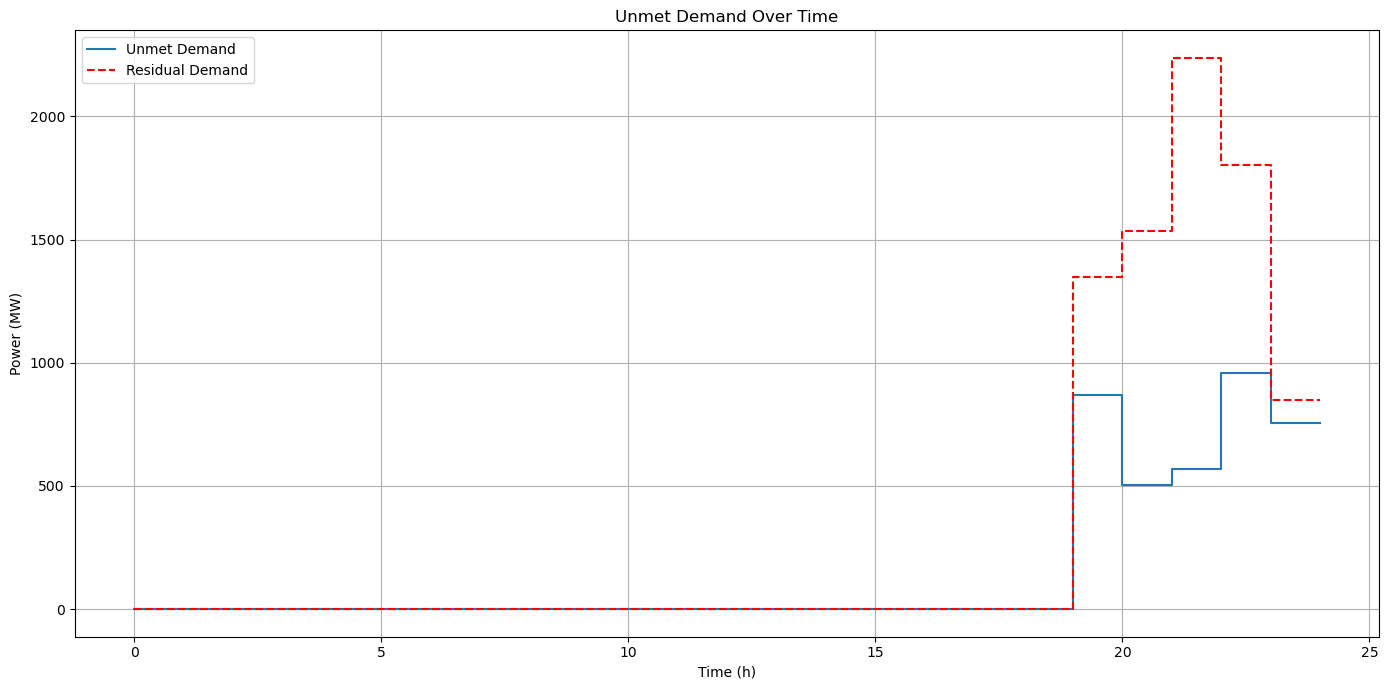

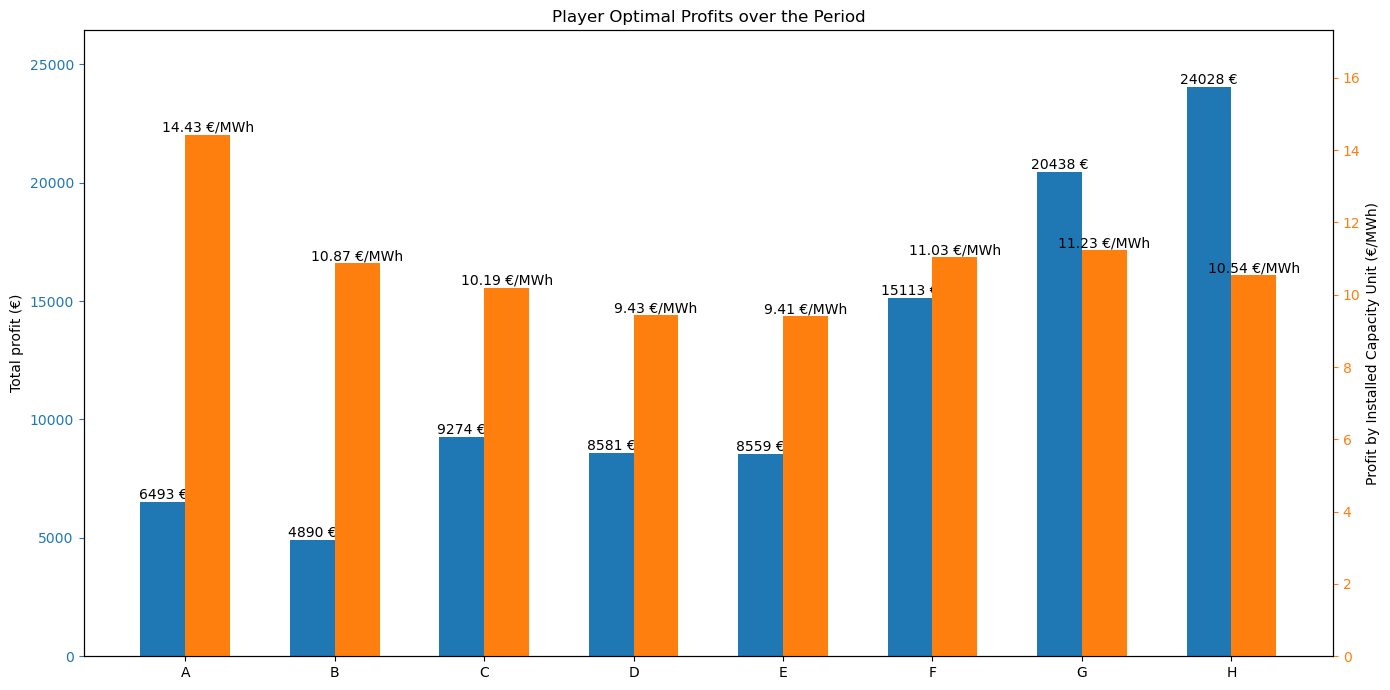

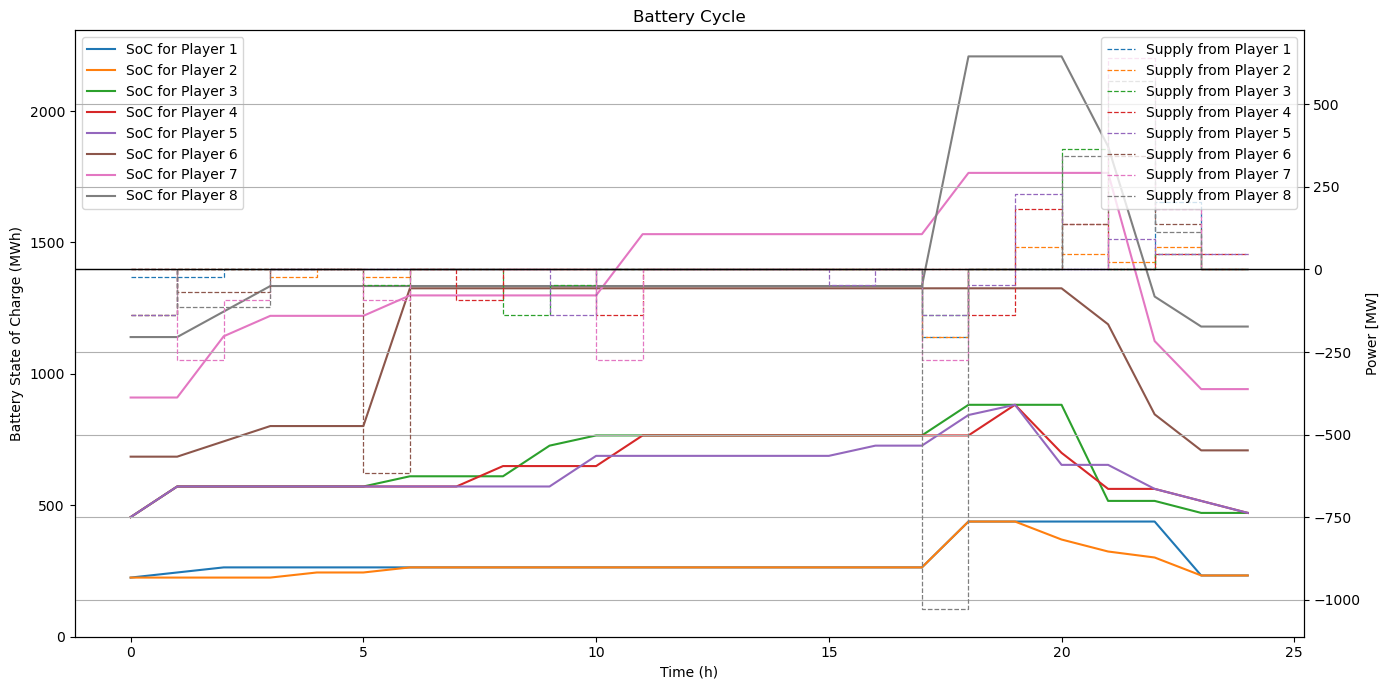

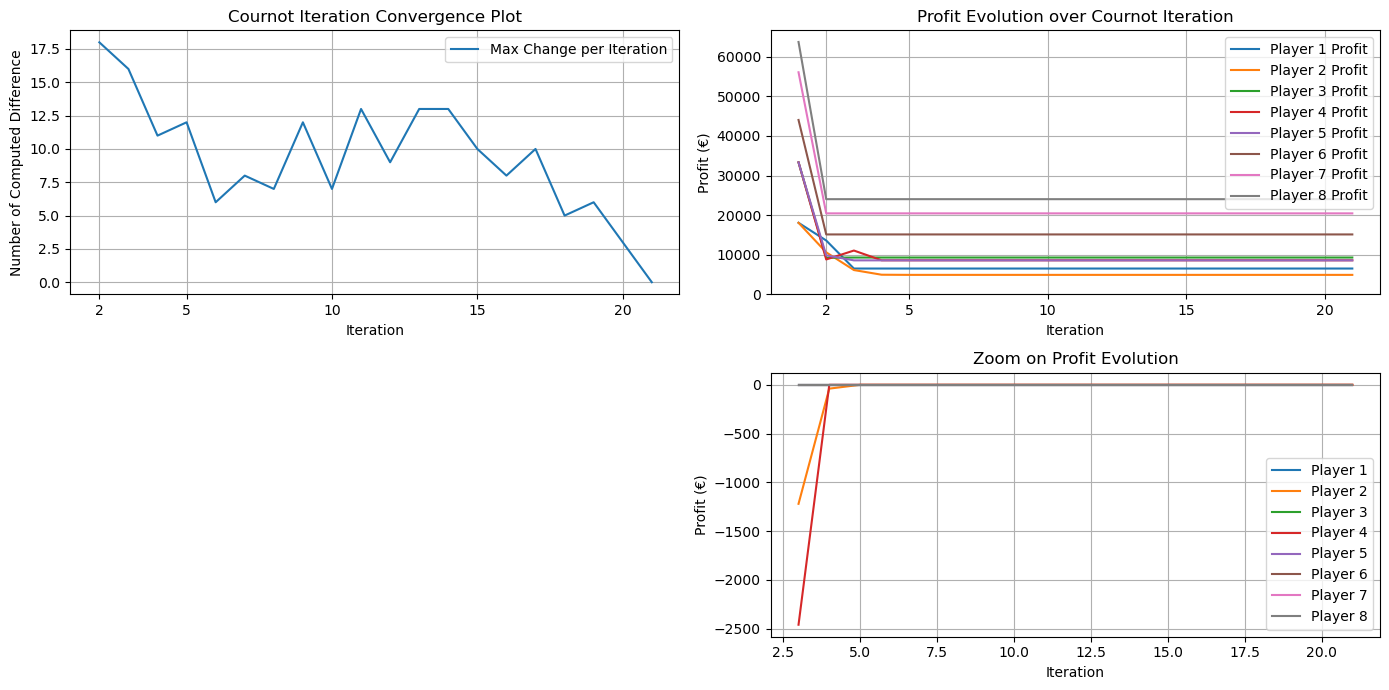

In [11]:
for season in seasons:
    results[season] = {}
    for n_players in player_counts:
        print(f"Running {season} - {n_players} players")
        output = main(season=season, n_players=n_players, storage_capacity=storage_capacity)
        results[season][n_players] = output


Running Winter - No player

Running Summer - No player

Running LowLoad - No player


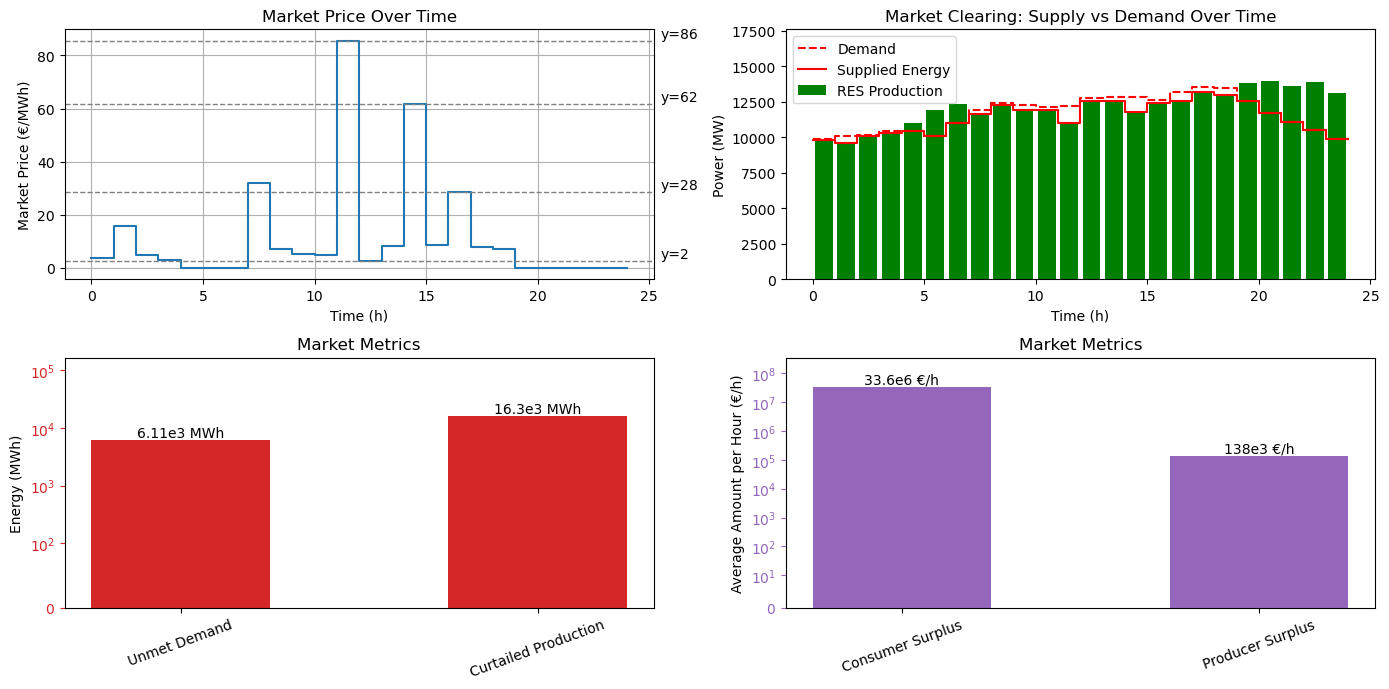

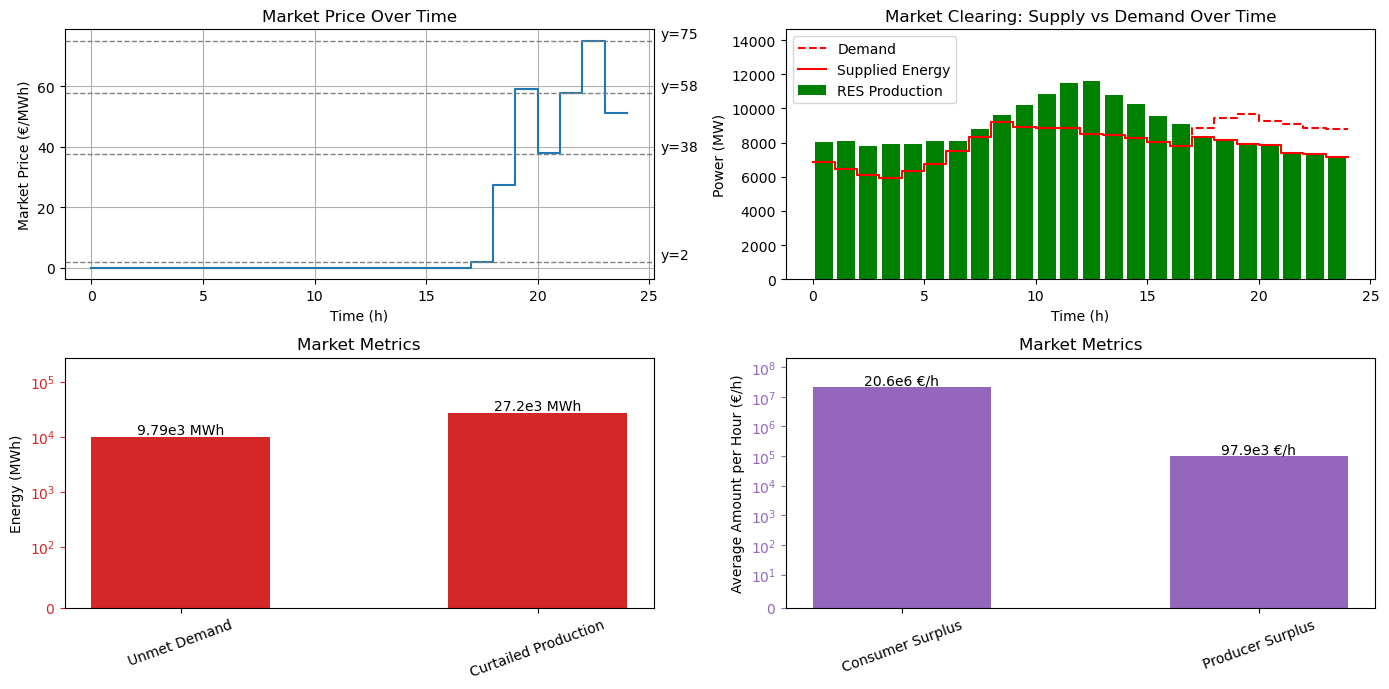

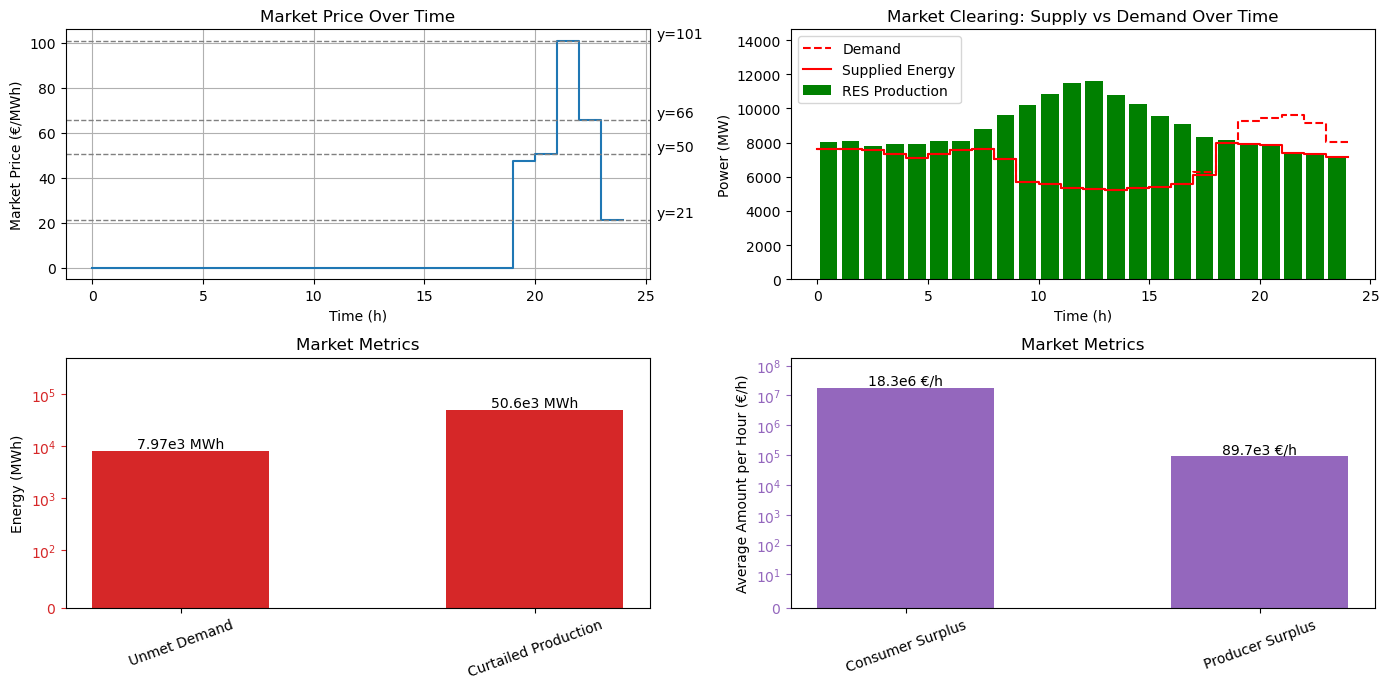

In [12]:
# NO storage player
for season in seasons:
    print(f"\nRunning {season} - No player")
    output = main(season=season, n_players=0, plots=True)

    results[season][0] = {}
    results[season][0][0] = {}
    results[season][0][0][1] = output["price"]
    results[season][0][0][3] = output["price"]
    results[season][0][0][7] = output["consumer_surplus"]
    results[season][0][0][8] = output["producer_surplus"]
    results[season][0][0][9] = output["unmet_demand"]
    results[season][0][0][10] = output["curtailed_supply"]

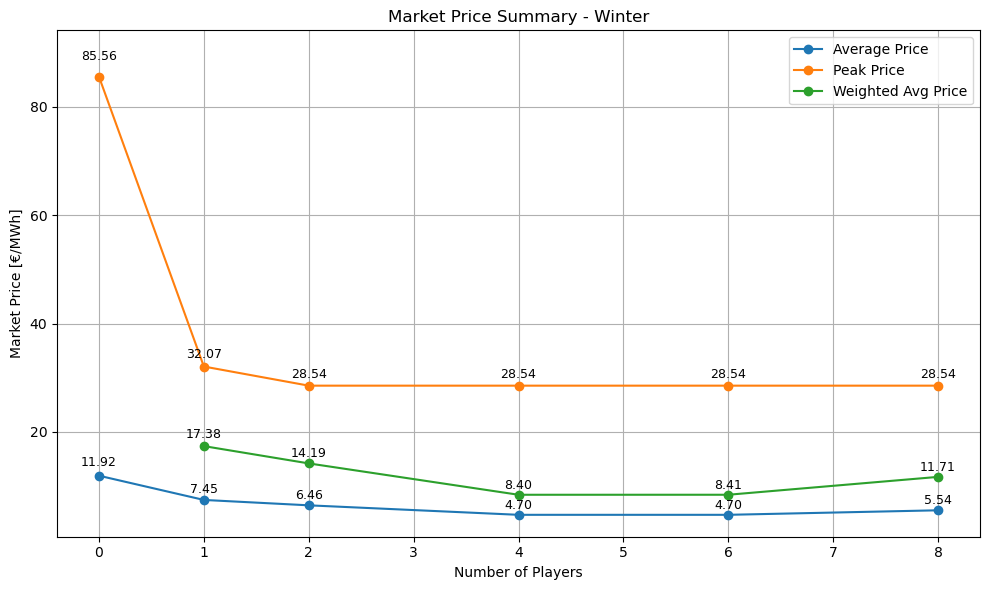

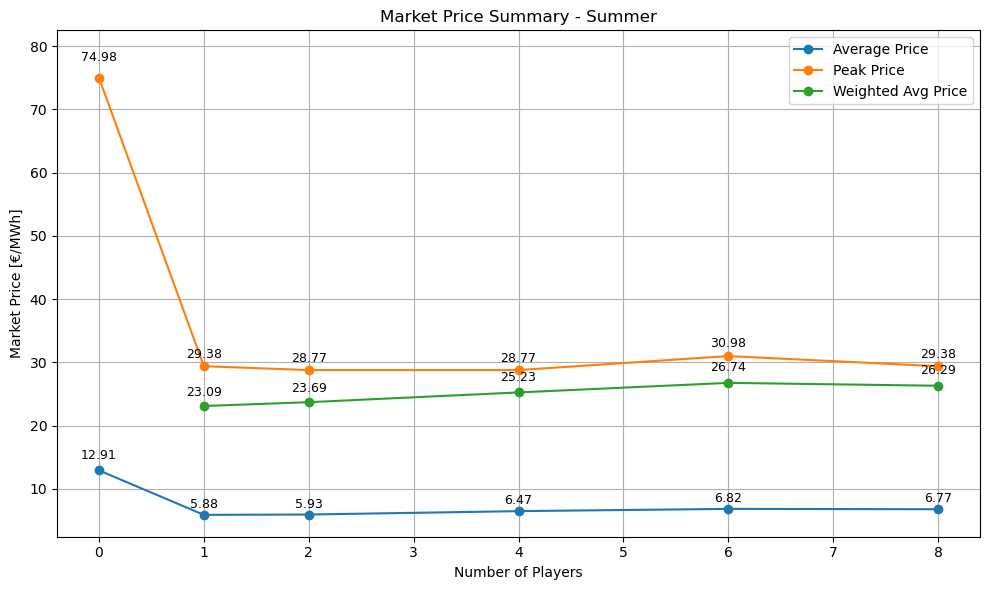

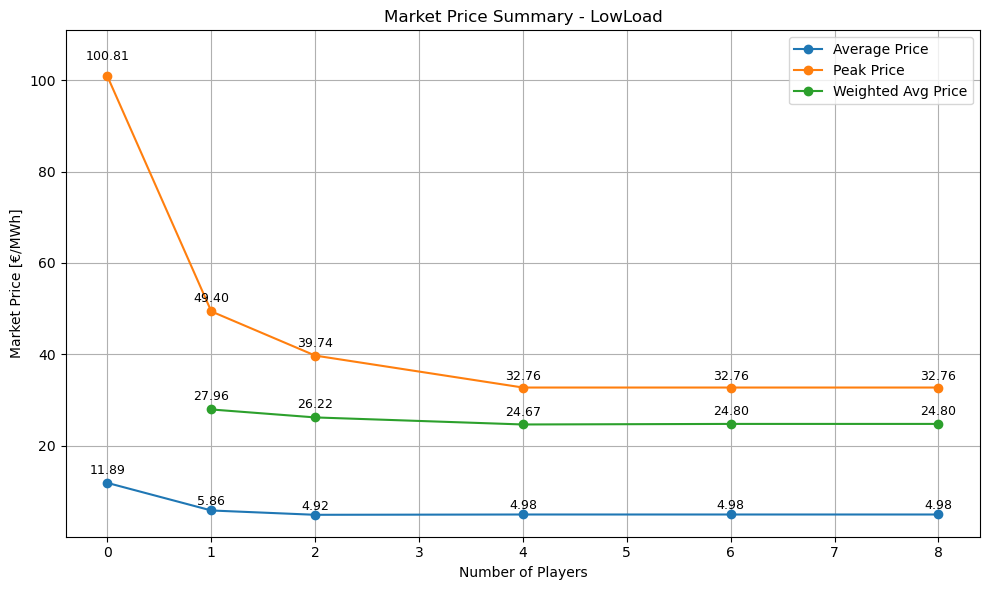

In [ ]:
# Toggle to save figures
SAVE_FIGS = False
# seasons = ["Winter"]
seasons = ['Winter', 'Summer', 'LowLoad']

for season in seasons:
    plot_market_price_summary(results, season=season, selected_hours=[], save=SAVE_FIGS)

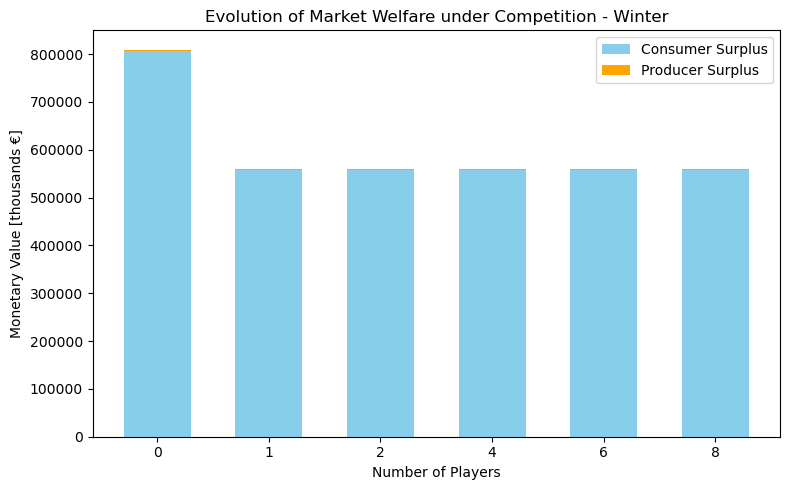

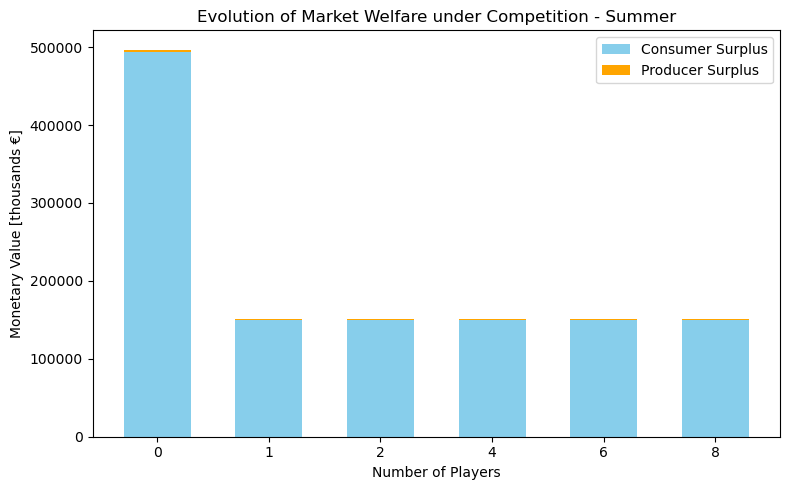

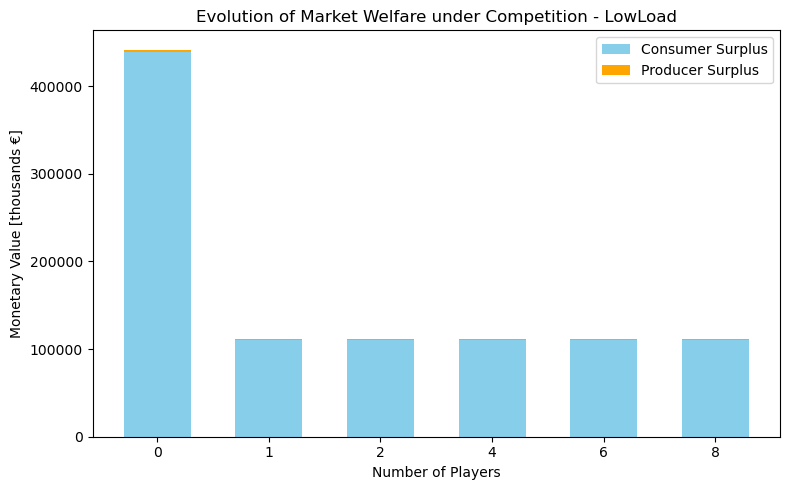

In [14]:
for season in seasons:
    plot_stacked_welfare(results, season=season, save=SAVE_FIGS)

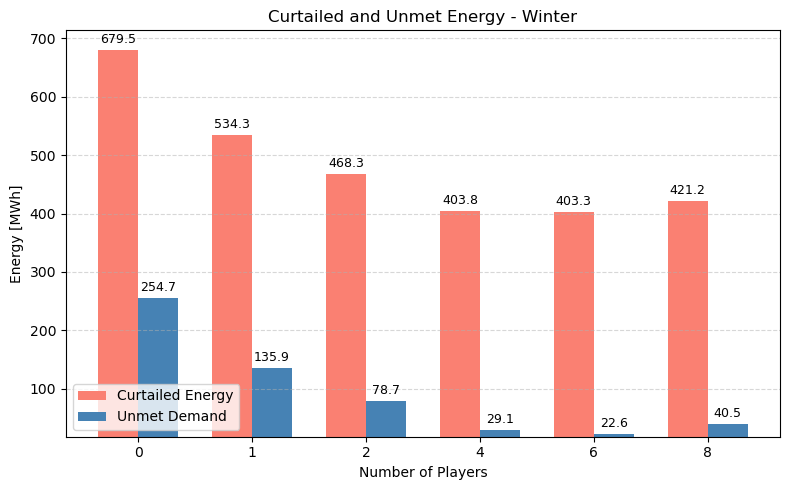

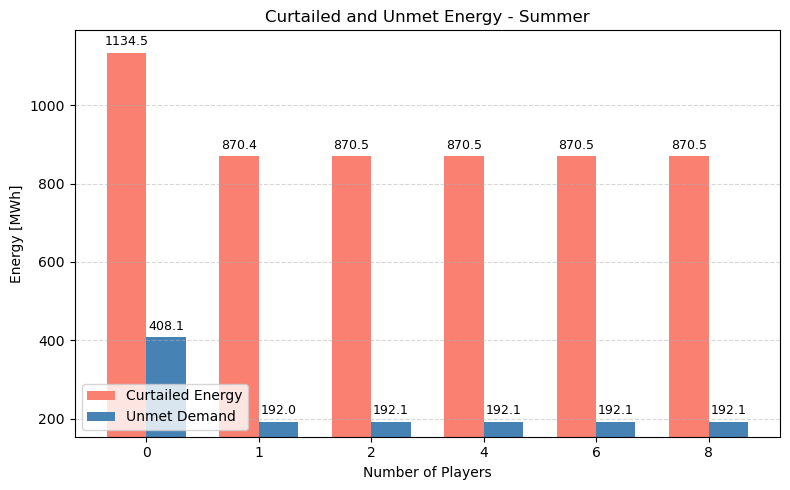

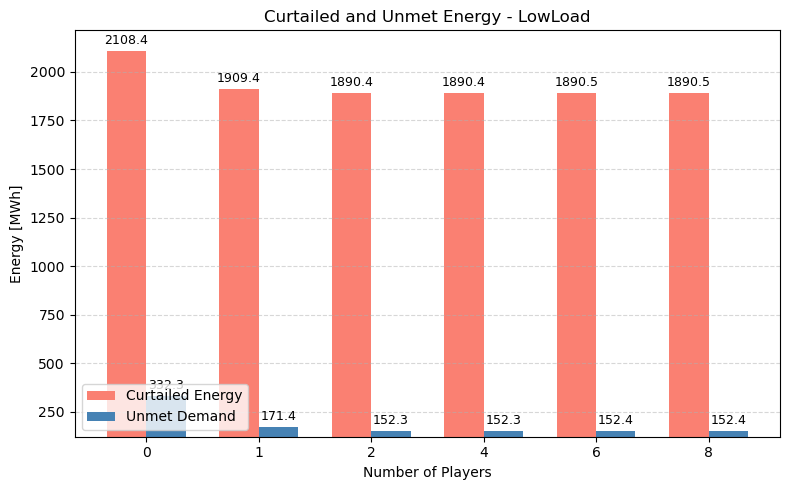

In [15]:
for season in seasons:
    plot_curtail_unmet_groupedbars(results, season=season, save=SAVE_FIGS)

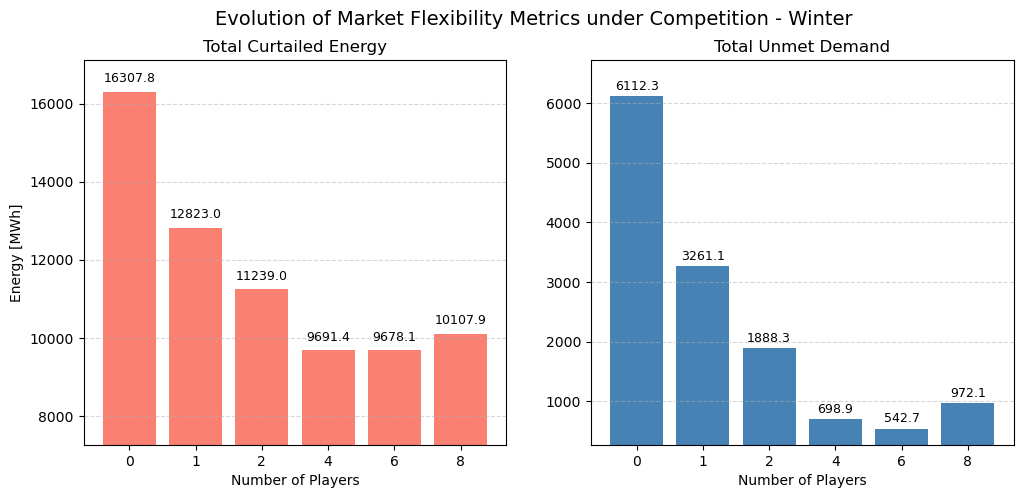

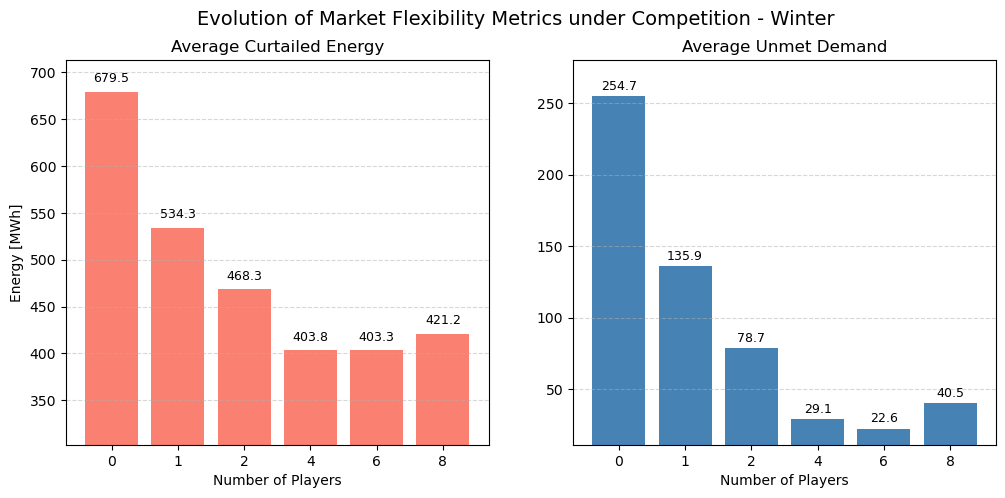

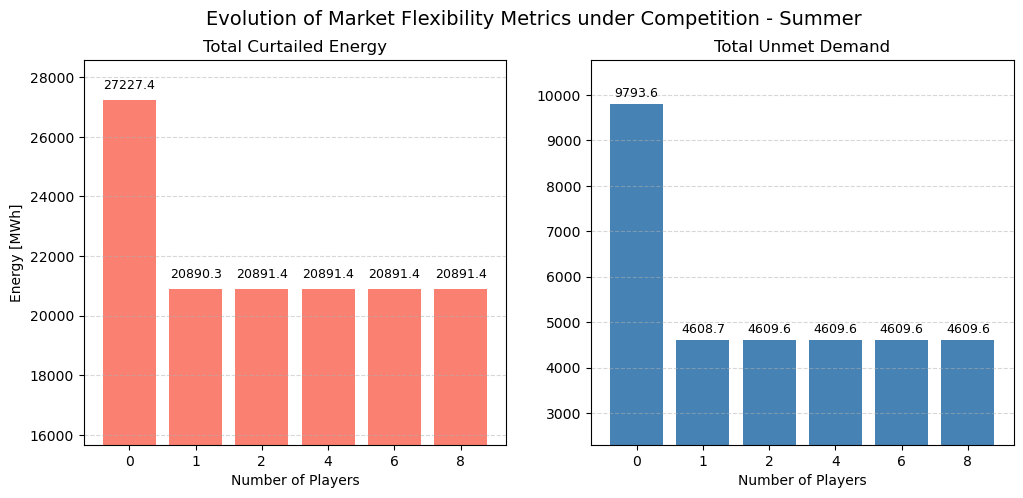

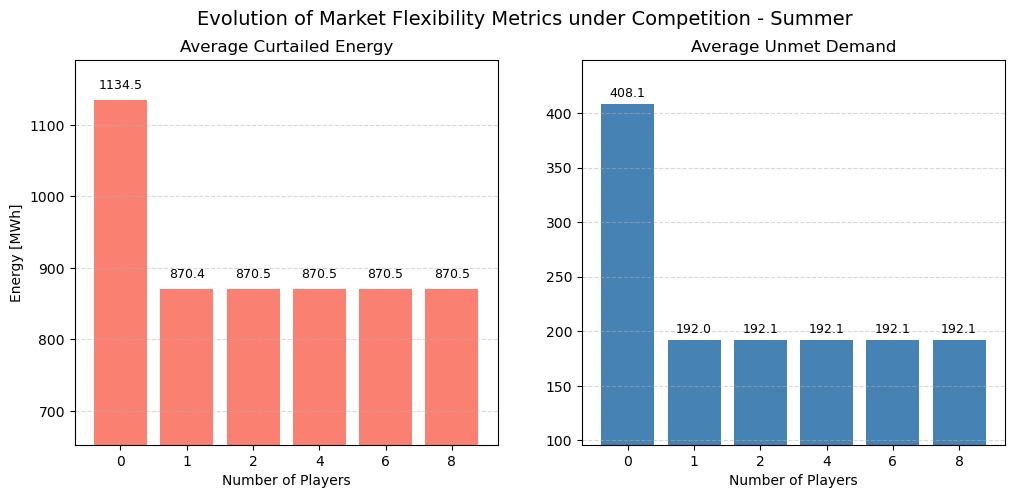

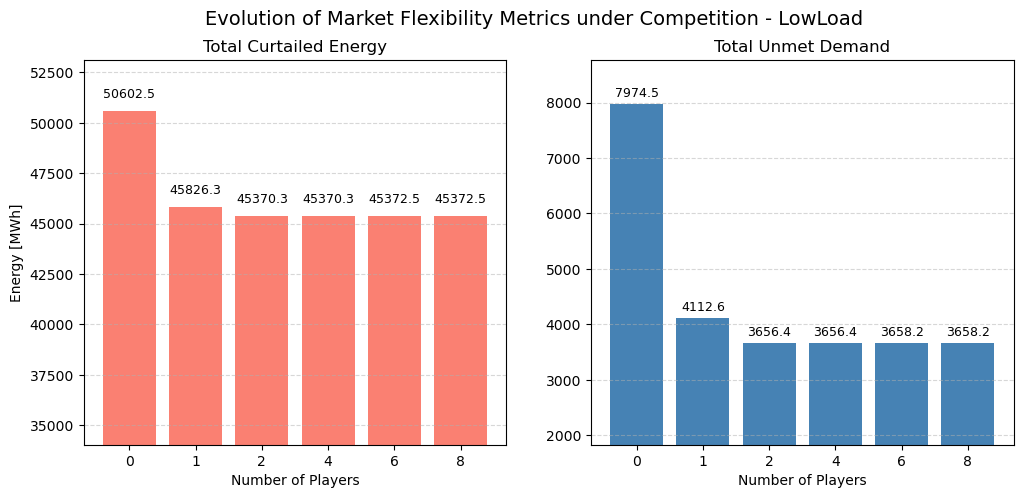

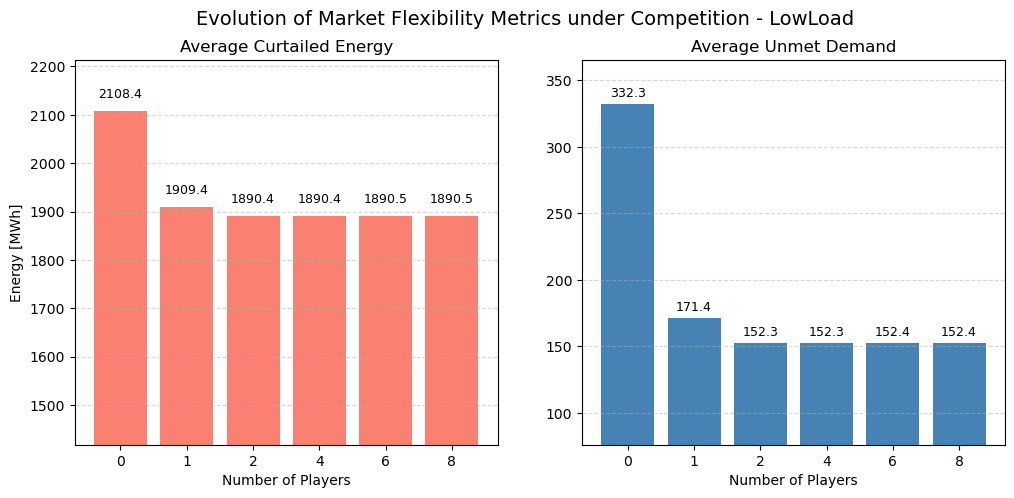

In [16]:
for season in seasons:
    plot_curtailment_and_unmet_subplots(results, season=season, mode="Total", save=SAVE_FIGS)
    plot_curtailment_and_unmet_subplots(results, season=season, mode="Average", save=SAVE_FIGS)

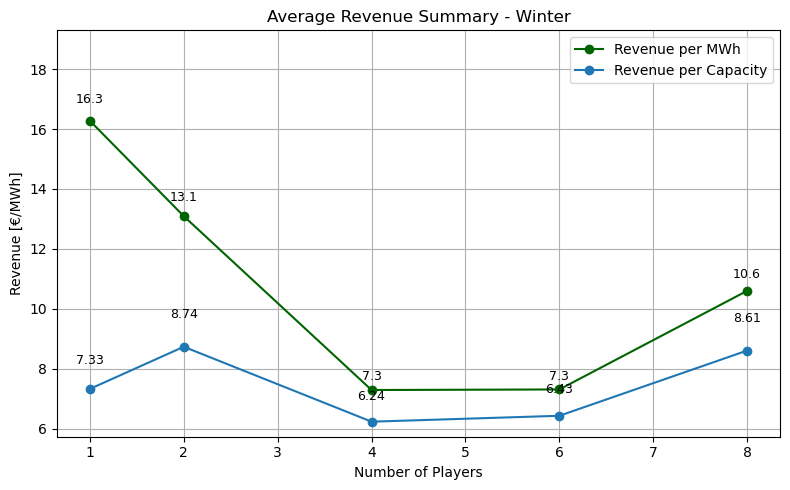

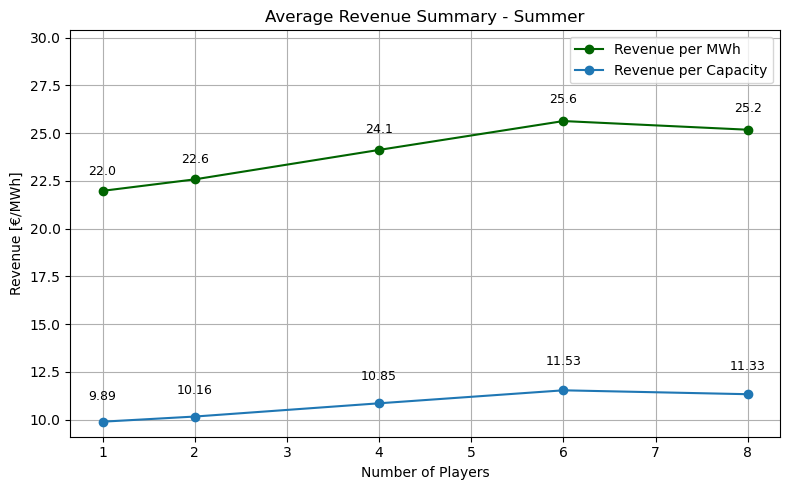

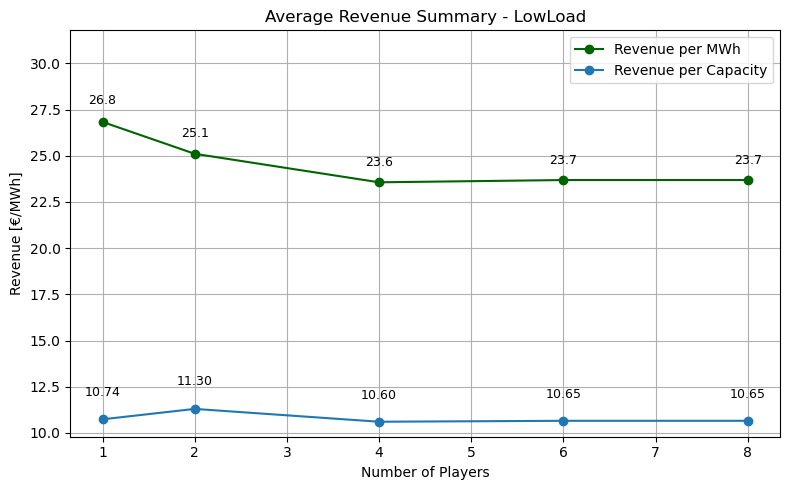

In [17]:
for season in seasons:
    plot_revenue_per_mwh(results, season=season, save=SAVE_FIGS)

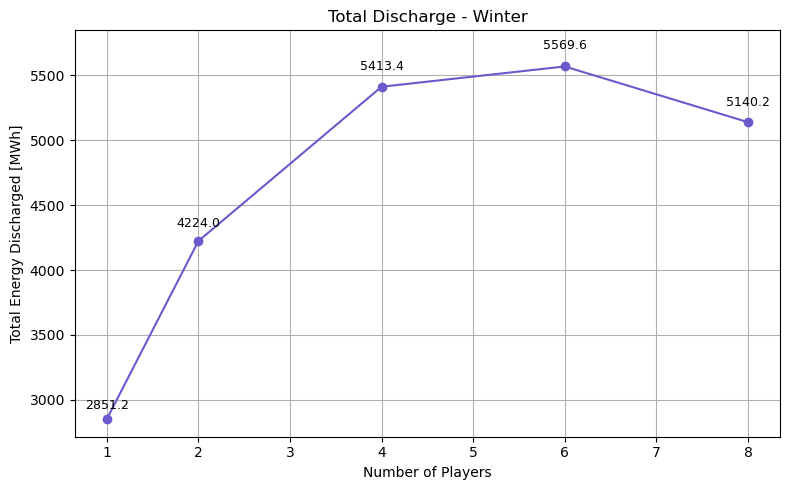

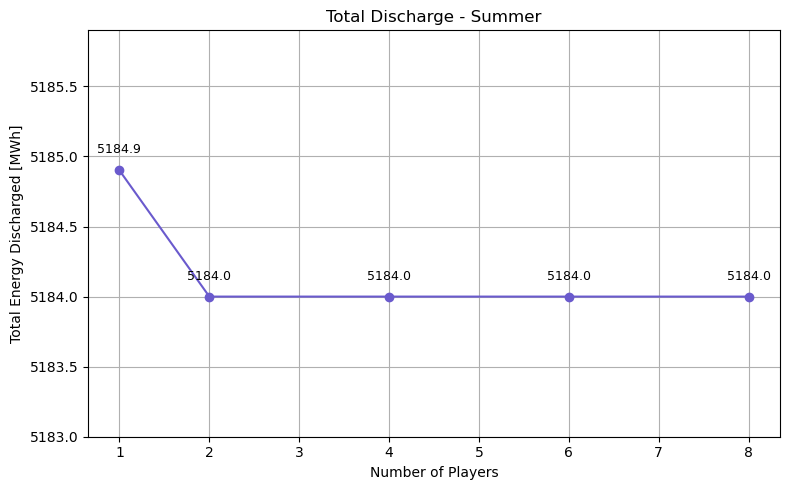

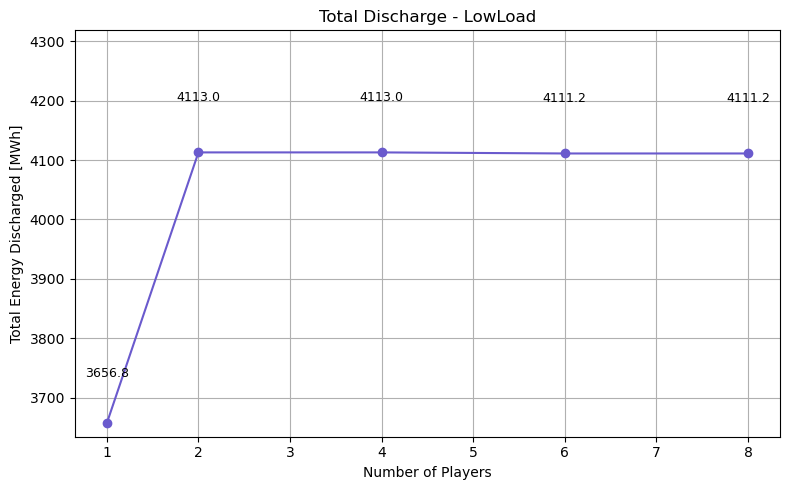

In [18]:
for season in seasons:
    plot_total_discharge(results, season=season, save=SAVE_FIGS)


### Trial: more detailed resolution in the power rate discretization 

> TOO LONG + OCCASIONAL DIVERGENCE

In [19]:
# # --- Store results for a bigger N ---
# results_20N = {}

# for season in seasons:
#     results_20N[season] = {}
#     for n_players in player_counts:
#         print(f"Running {season} - {n_players} players")
#         output = main(season=season, n_players=n_players, N=20)
#         results_20N[season][n_players] = output
